In [75]:
import math as mt

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import chi2
from scipy.spatial import distance

from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from patsy import dmatrices


from sklearn.preprocessing import StandardScaler

from scipy.stats import skew, kurtosis

from IPython.display import HTML
import random

import warnings

In [4]:
# Load the dataset
data = pd.read_csv('data/Boston.csv')
data = data.rename(columns={'Unnamed: 0' : 'idx'})

# Display the first few rows of the dataset
data.head()

idx  crim    zn  indus  chas  nox   rm   age  dis  rad  tax  ptratio  \
0    1  0.01 18.00   2.31     0 0.54 6.58 65.20 4.09    1  296    15.30   
1    2  0.03  0.00   7.07     0 0.47 6.42 78.90 4.97    2  242    17.80   
2    3  0.03  0.00   7.07     0 0.47 7.18 61.10 4.97    2  242    17.80   
3    4  0.03  0.00   2.18     0 0.46 7.00 45.80 6.06    3  222    18.70   
4    5  0.07  0.00   2.18     0 0.46 7.15 54.20 6.06    3  222    18.70   

   black  lstat  medv  
0 396.90   4.98 24.00  
1 396.90   9.14 21.60  
2 392.83   4.03 34.70  
3 394.63   2.94 33.40  
4 396.90   5.33 36.20

In [5]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   idx      506 non-null    int64  
 1   crim     506 non-null    float64
 2   zn       506 non-null    float64
 3   indus    506 non-null    float64
 4   chas     506 non-null    int64  
 5   nox      506 non-null    float64
 6   rm       506 non-null    float64
 7   age      506 non-null    float64
 8   dis      506 non-null    float64
 9   rad      506 non-null    int64  
 10  tax      506 non-null    int64  
 11  ptratio  506 non-null    float64
 12  black    506 non-null    float64
 13  lstat    506 non-null    float64
 14  medv     506 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


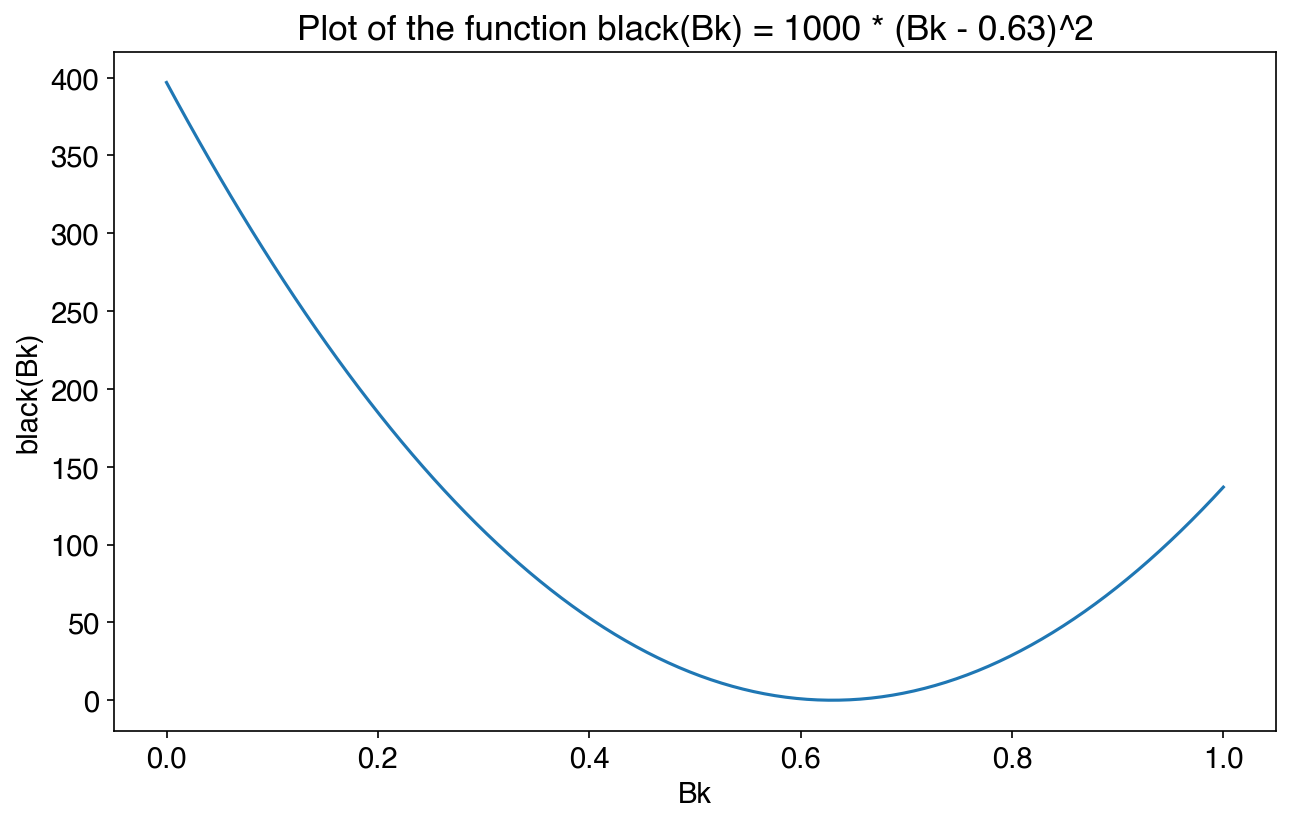

In [6]:
# Explain feature 'black' in terms of the proportion of black people in town b

def black(b):
    return 1000*(b-0.63)**2

x = np.linspace(0, 1, 100)
y = black(x)

plt.plot(x, y)
plt.xlabel('Bk')
plt.ylabel('black(Bk)')
plt.title('Plot of the function black(Bk) = 1000 * (Bk - 0.63)^2')
plt.savefig('BlackFunction.png')

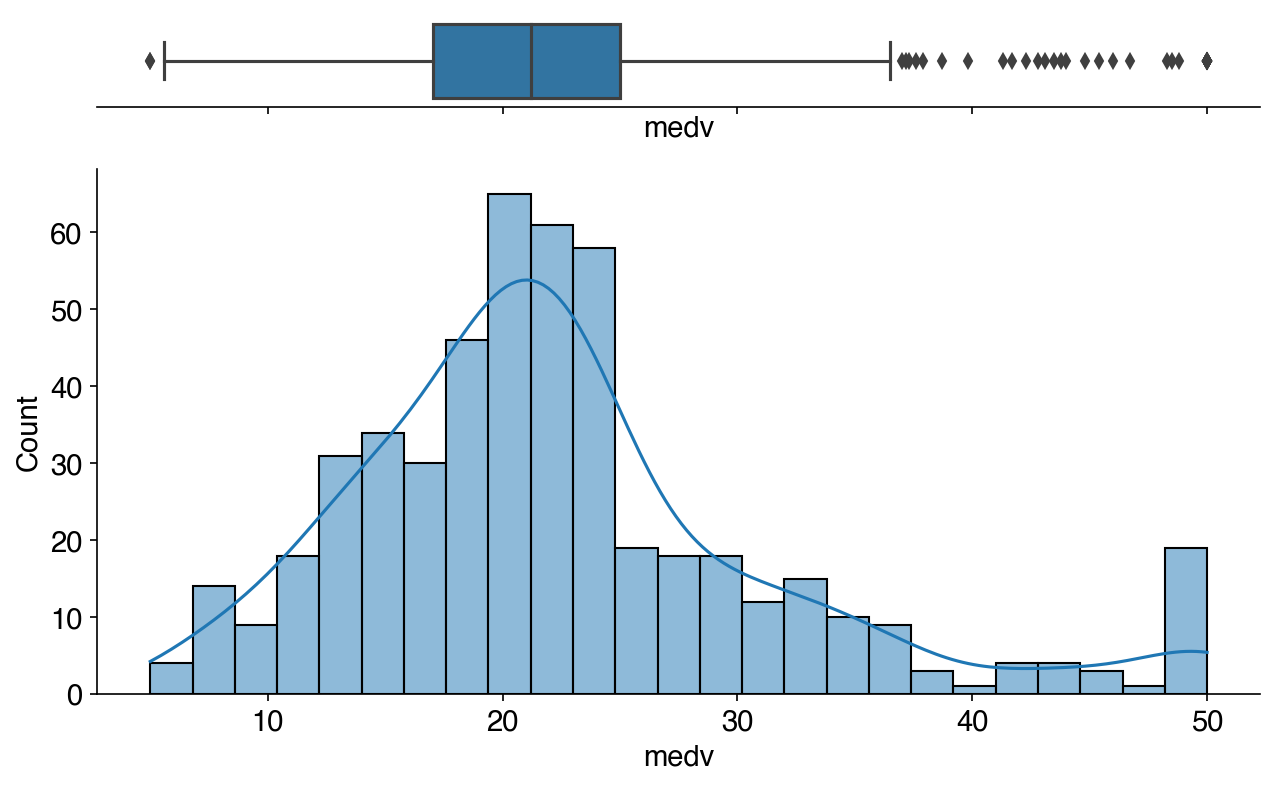

In [7]:
# Plot distribution of 'medv'

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=data.medv, ax=ax_box)
sns.histplot(x=data.medv, bins=25, kde=True, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

plt.savefig('DistributionRightCensoring-1.png')

In [8]:
# 'medv' is right censored: remove the points artificially stack at medv = 50 --> 16 points are removed
data = data[data['medv'] != 50]

# For simplicity, transform rad into a categorical variable
data['rad'] = pd.cut(data['rad'], bins=[0, 4, 8, 24], labels=['low', 'medium', 'high'])

# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 505
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   idx      490 non-null    int64   
 1   crim     490 non-null    float64 
 2   zn       490 non-null    float64 
 3   indus    490 non-null    float64 
 4   chas     490 non-null    int64   
 5   nox      490 non-null    float64 
 6   rm       490 non-null    float64 
 7   age      490 non-null    float64 
 8   dis      490 non-null    float64 
 9   rad      490 non-null    category
 10  tax      490 non-null    int64   
 11  ptratio  490 non-null    float64 
 12  black    490 non-null    float64 
 13  lstat    490 non-null    float64 
 14  medv     490 non-null    float64 
dtypes: category(1), float64(11), int64(3)
memory usage: 58.0 KB


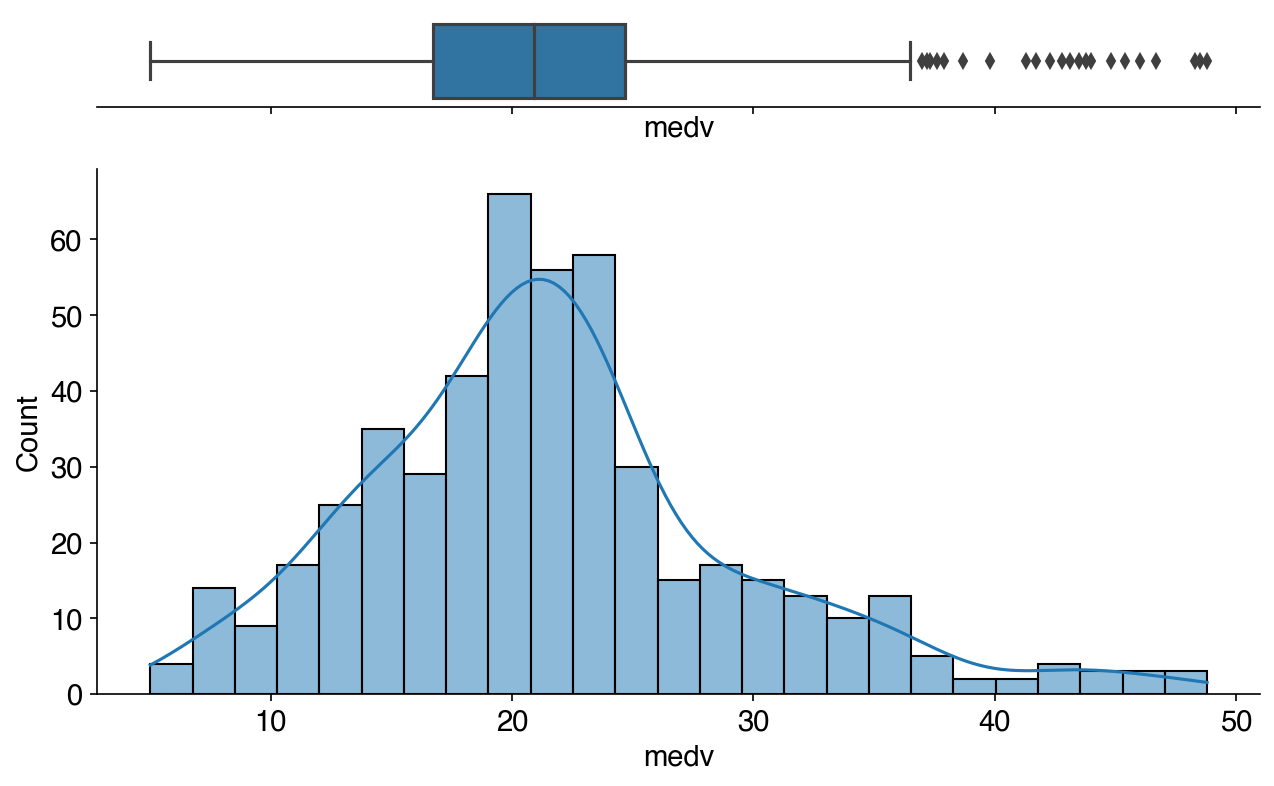

In [9]:
# Plot the distribution for the new dataset

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=data.medv, ax=ax_box)
sns.histplot(x=data.medv, bins=25, kde=True, ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

plt.savefig('DistributionRightCensoring-2.png')

In [10]:
# Define various subsets of variables

list_var = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'black', 'lstat', 'medv']

num_var = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax',
       'ptratio', 'black', 'lstat', 'medv']

cat_var = ['chas', 'rad']

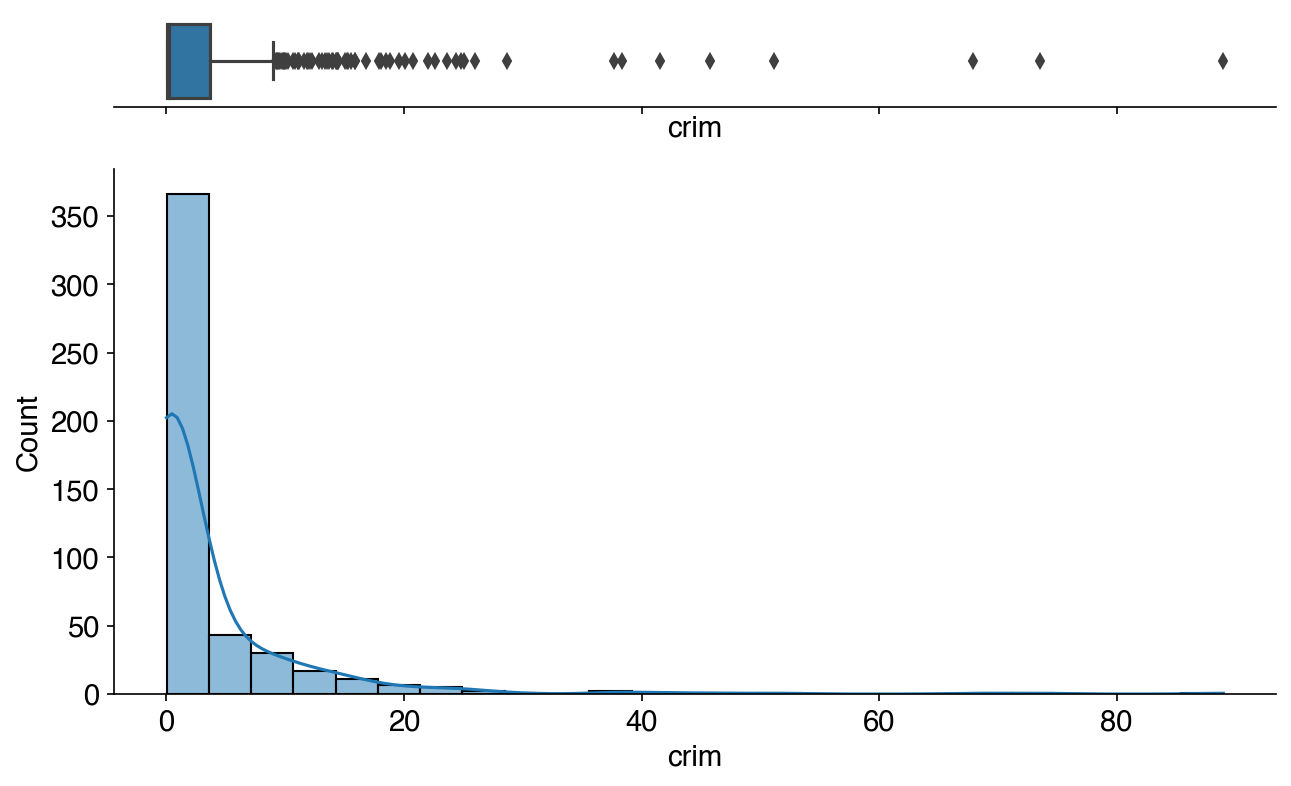

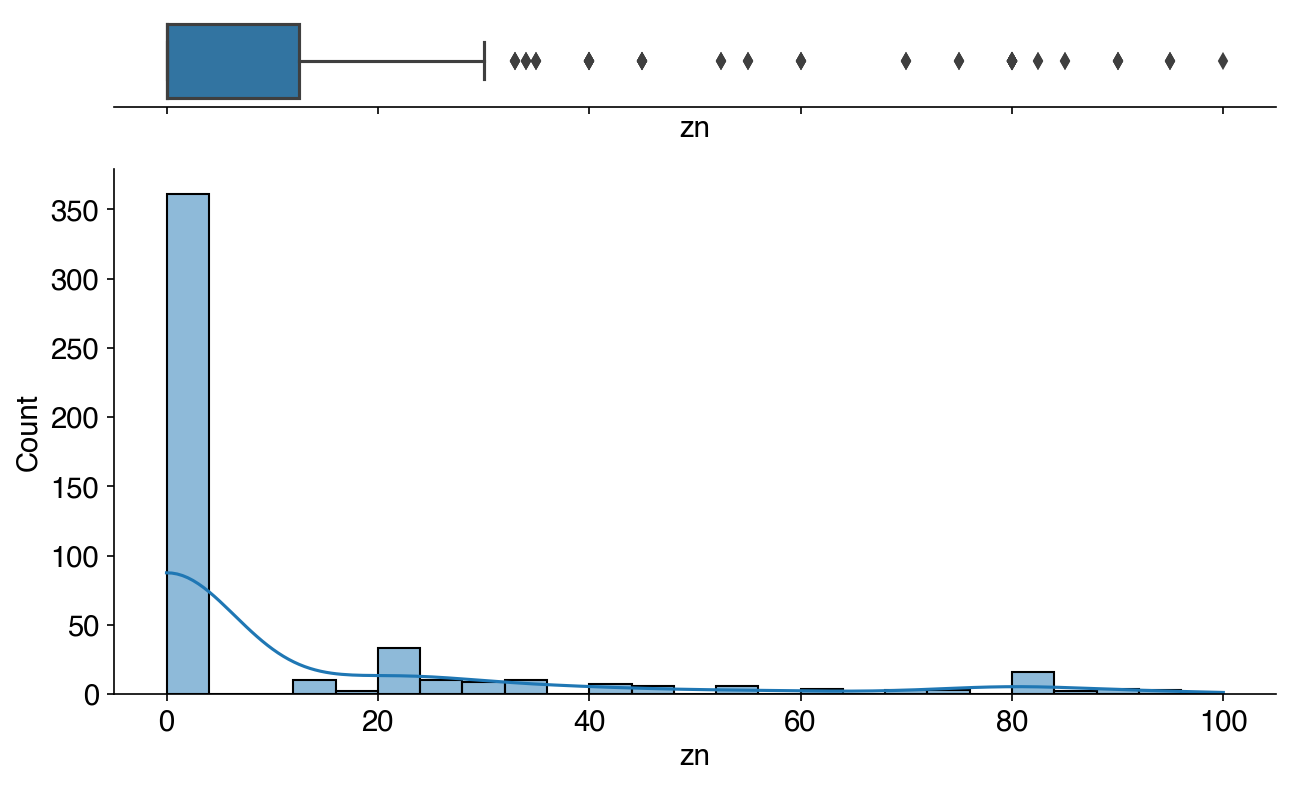

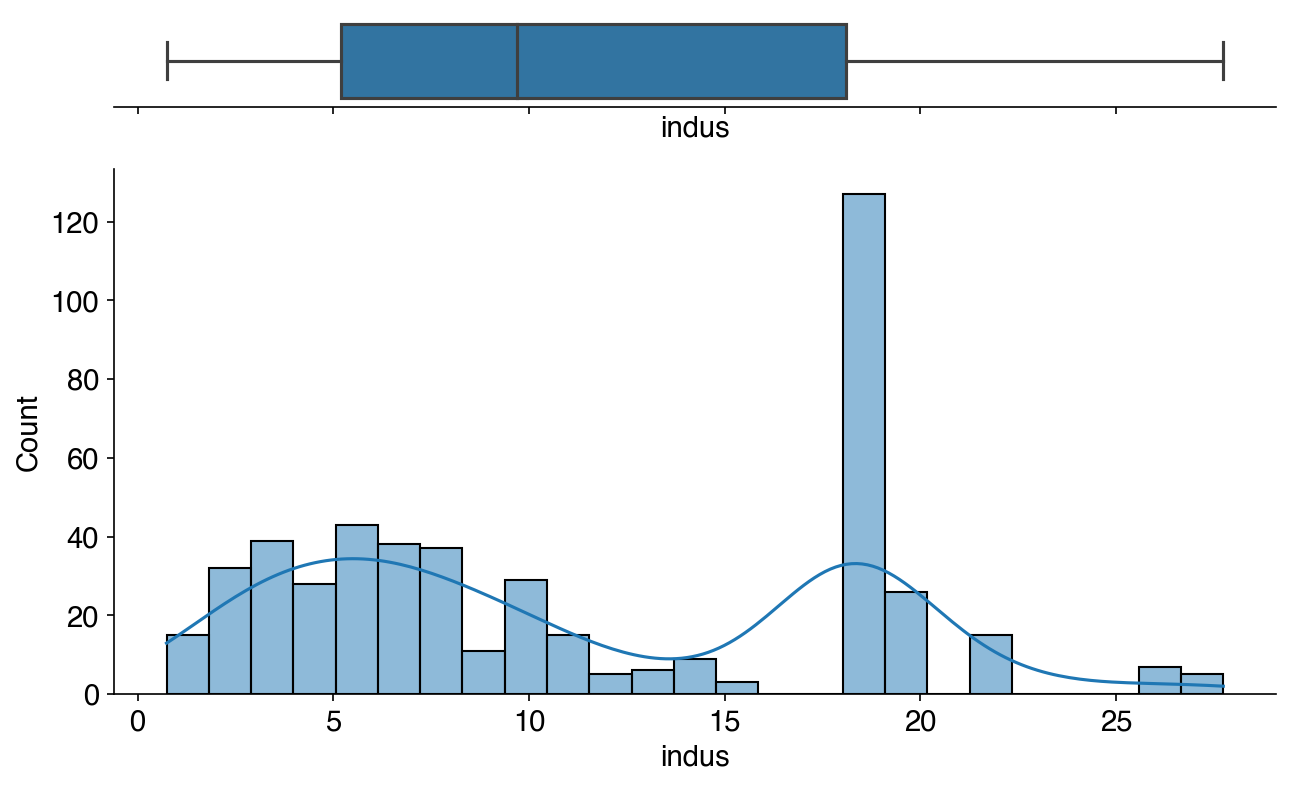

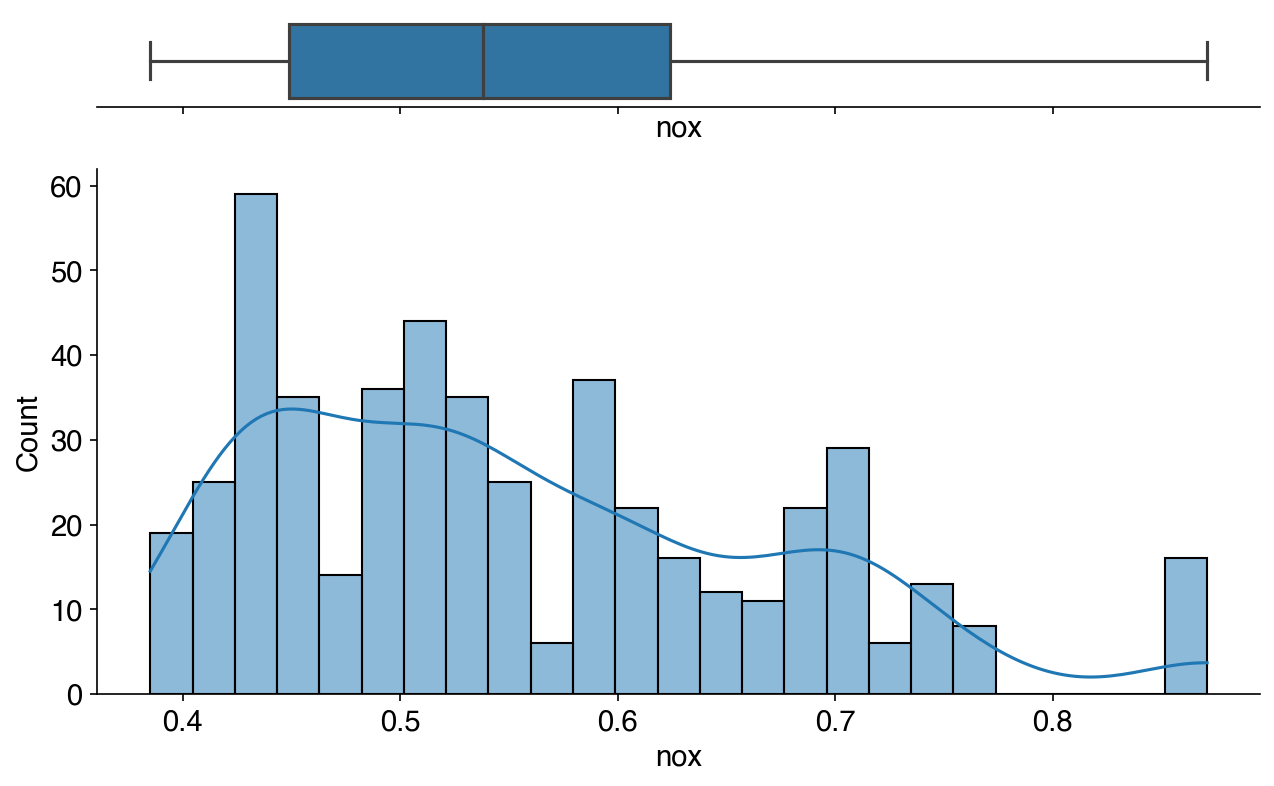

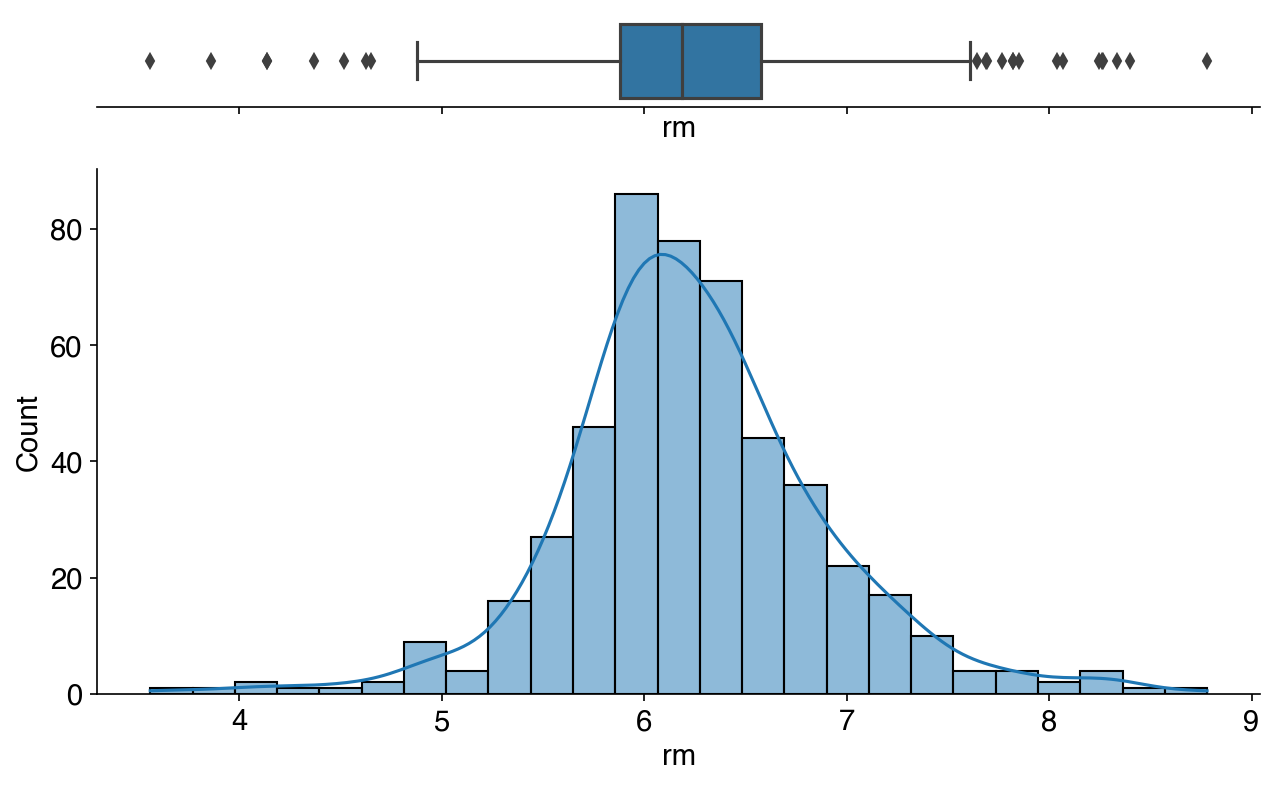

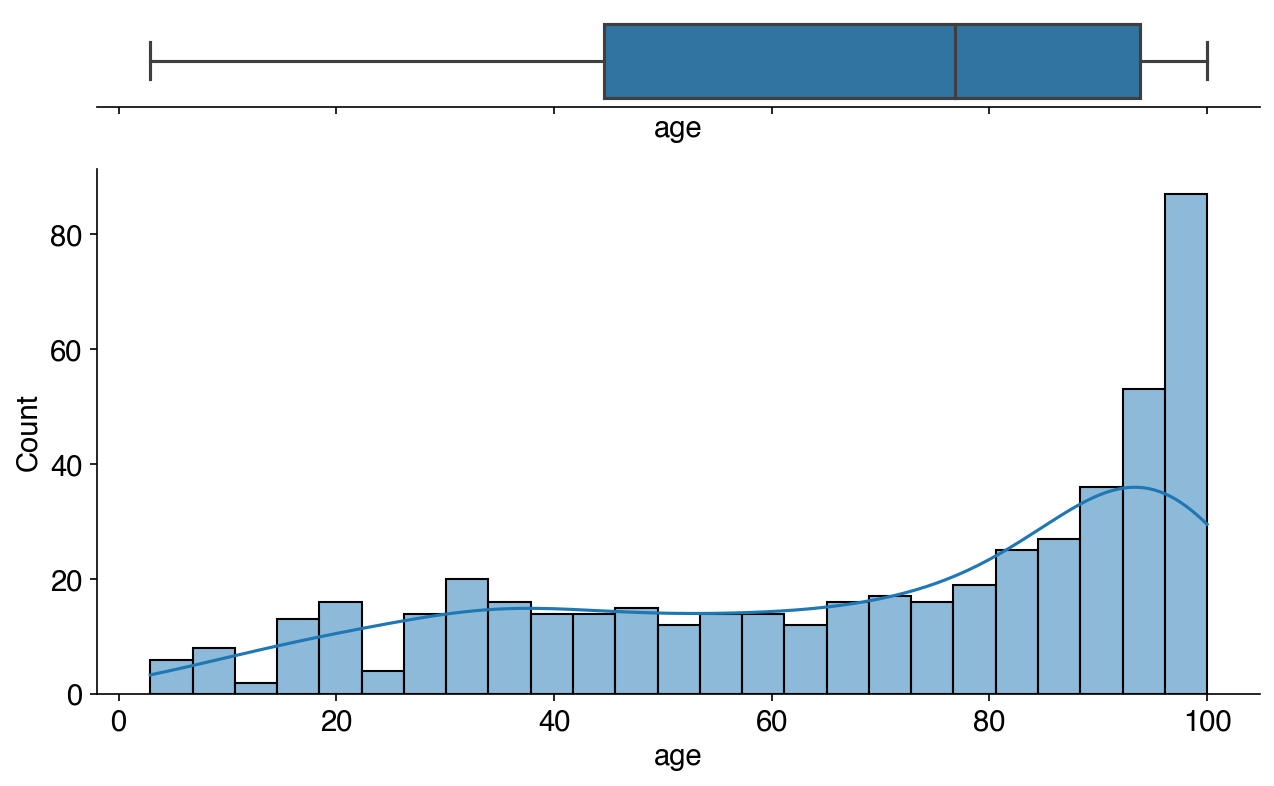

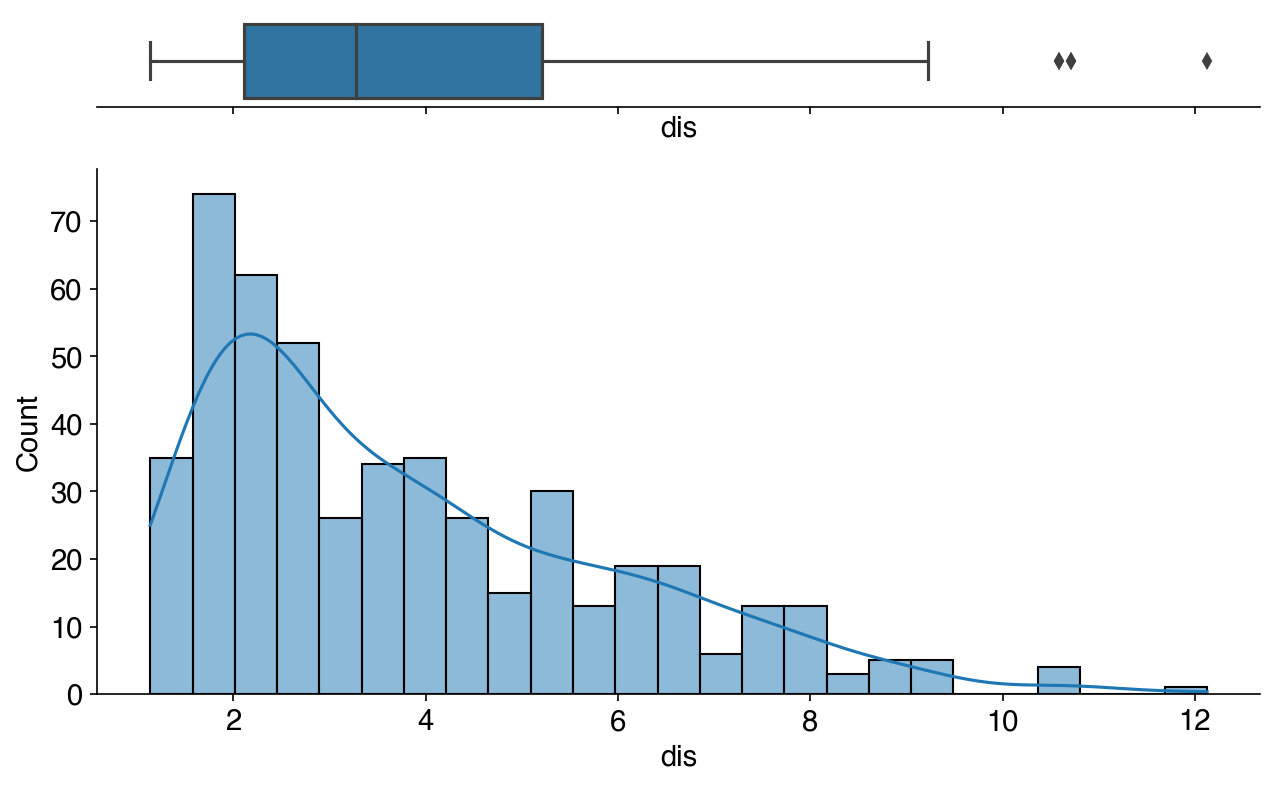

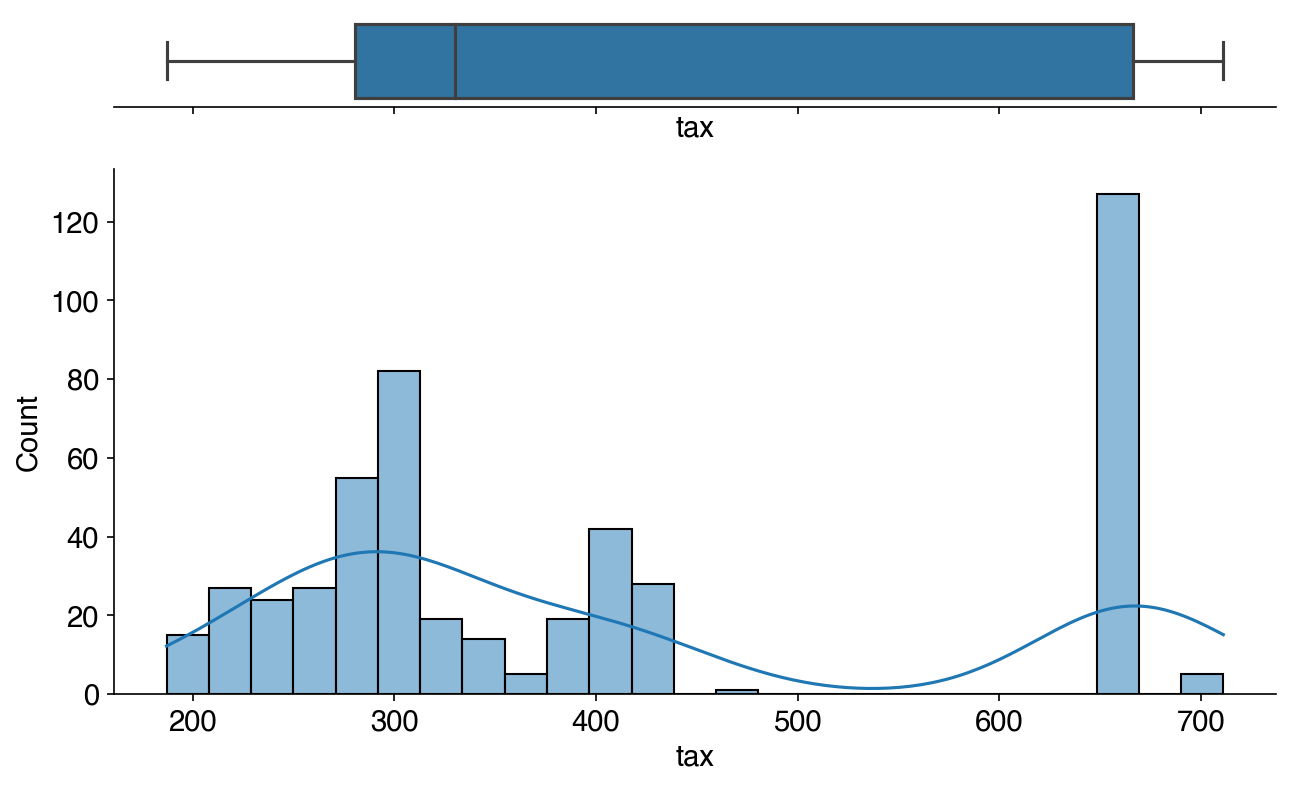

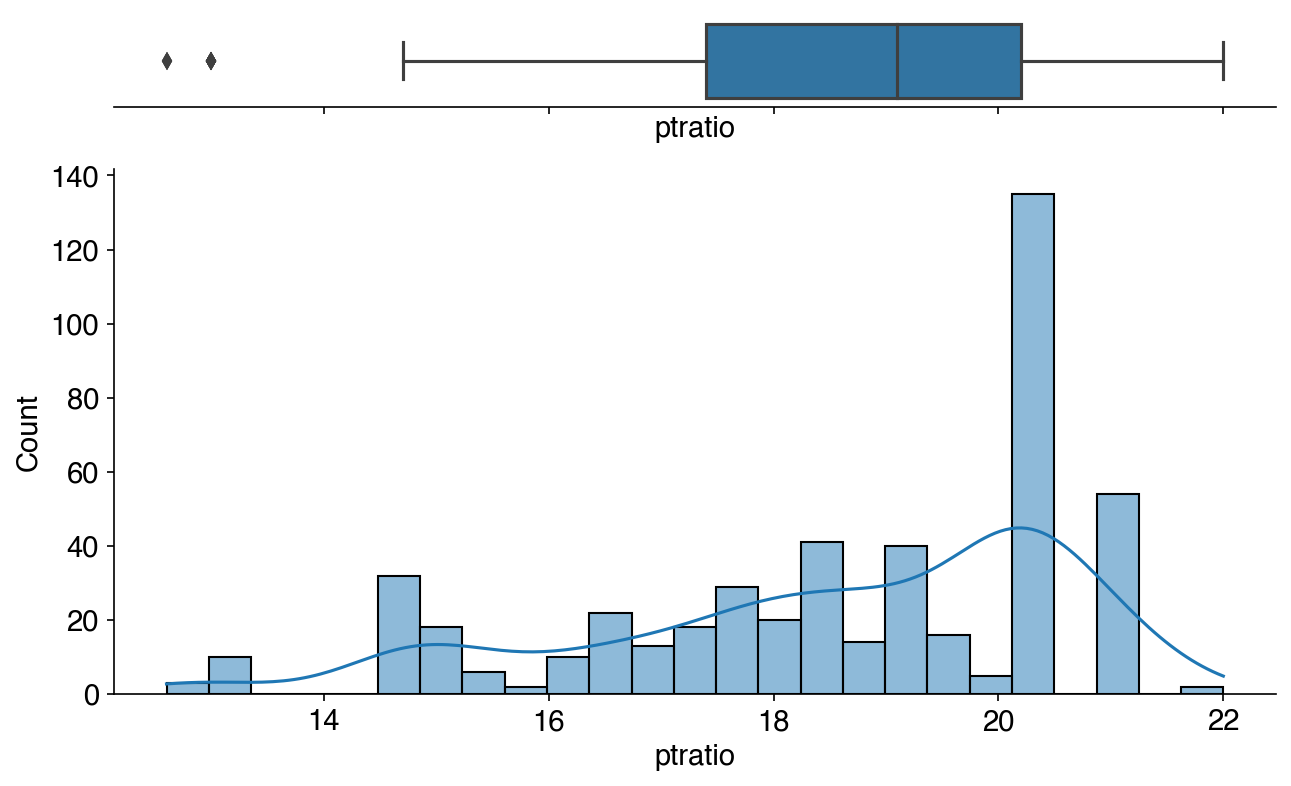

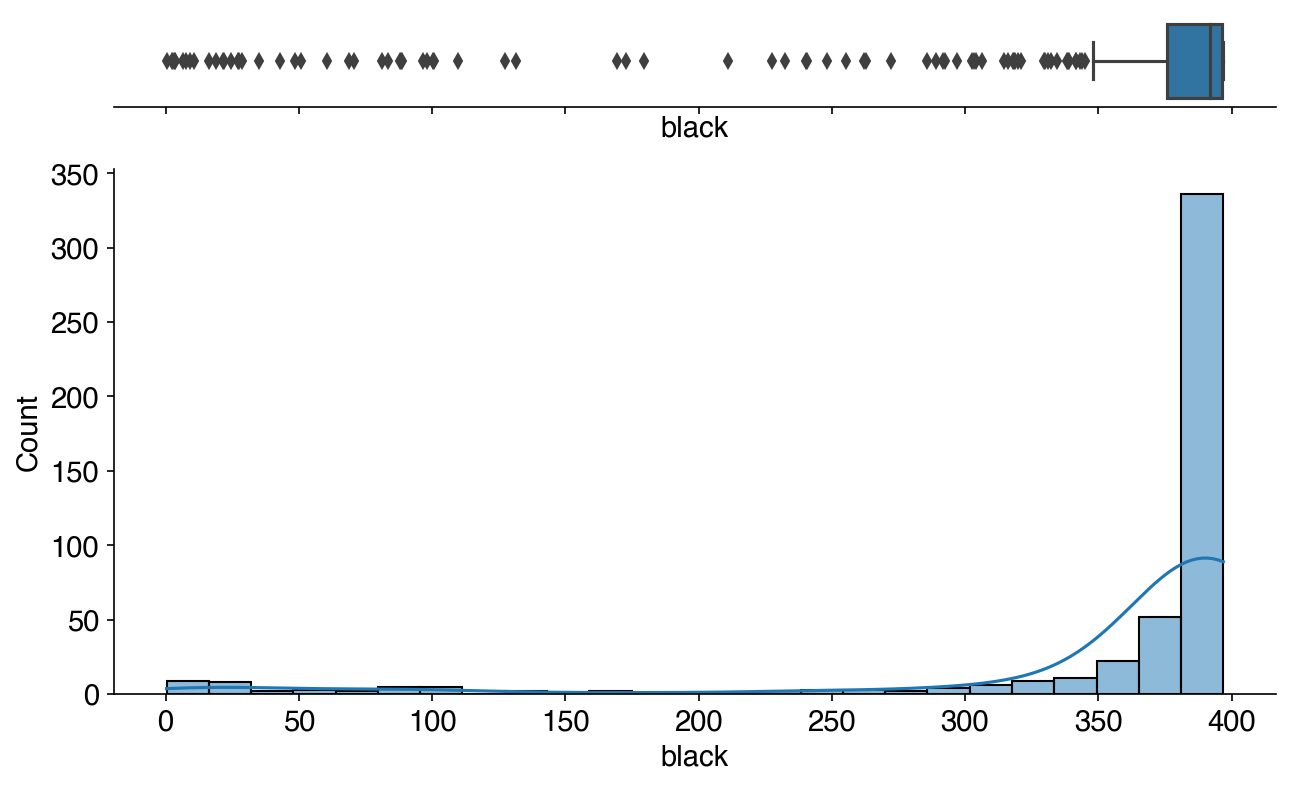

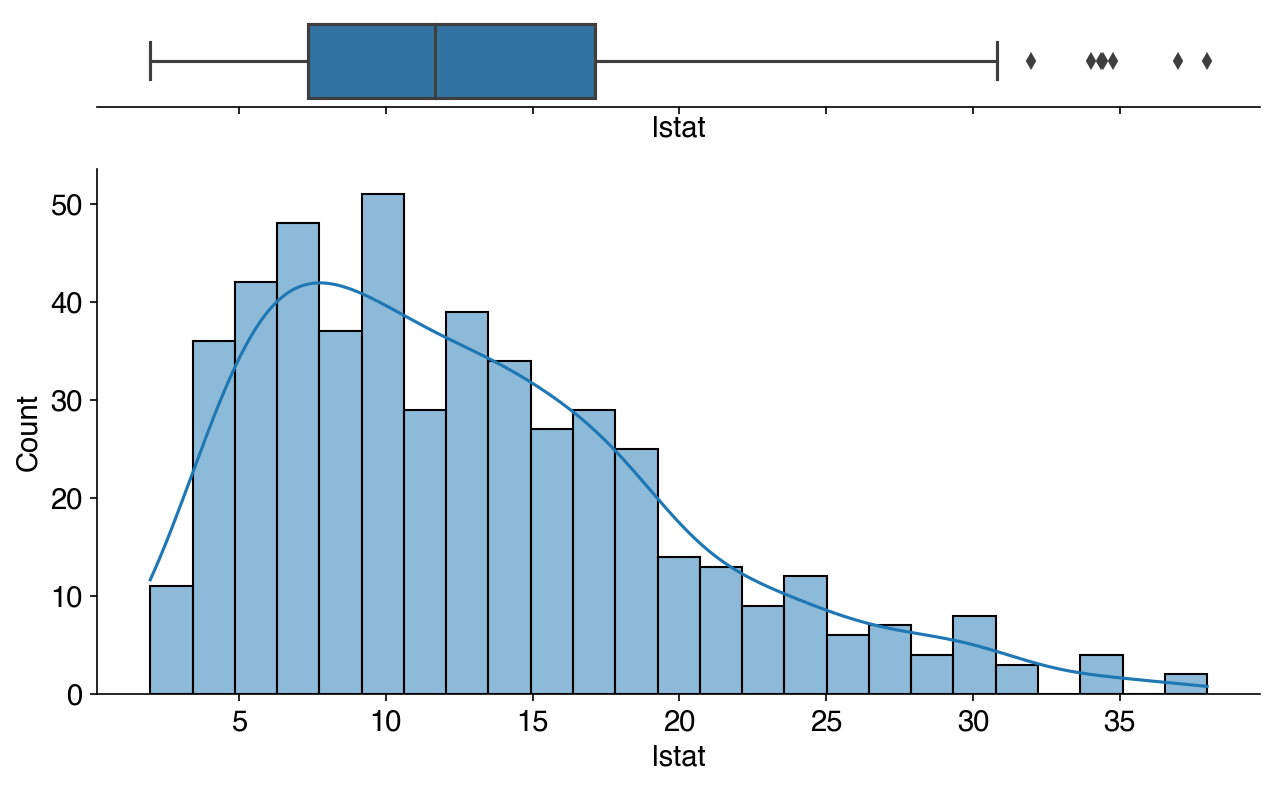

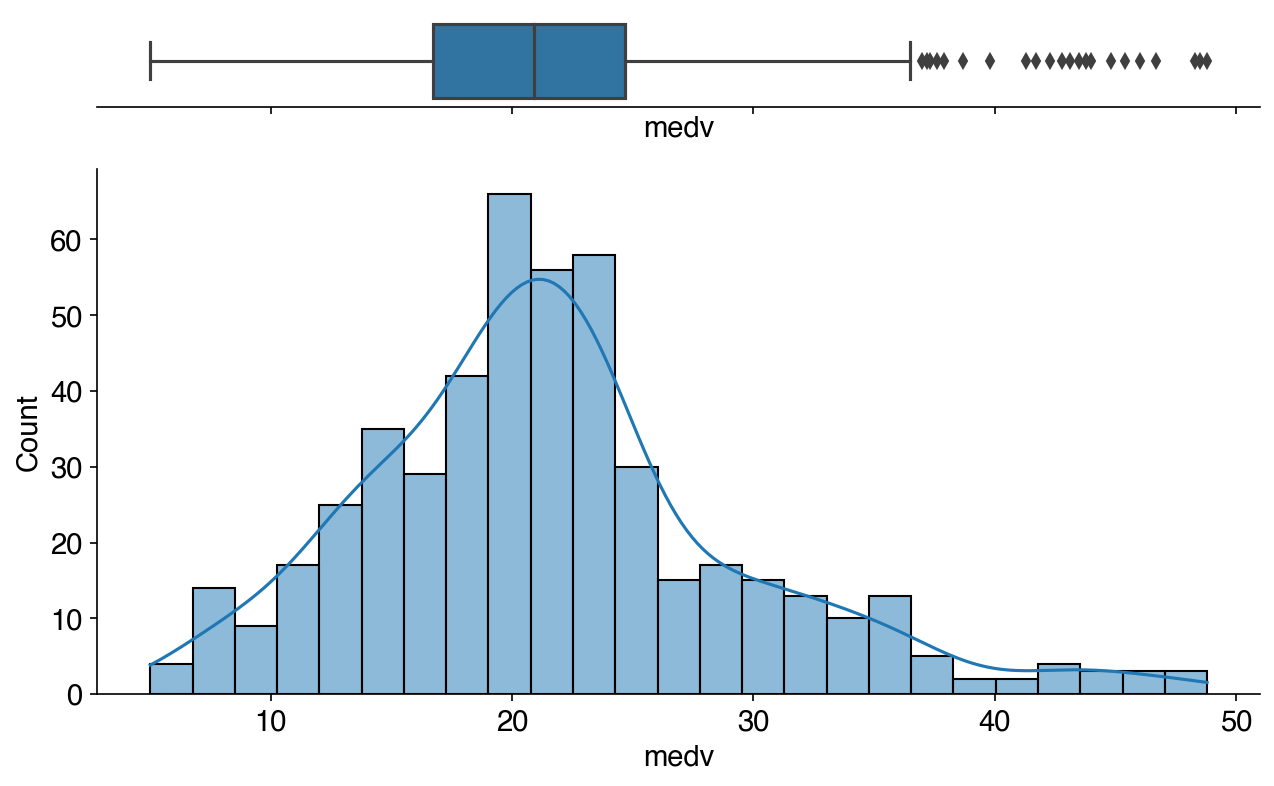

In [44]:
# Display the distribution plots for numerical variables

for i in range(len(num_var)):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=data.loc[:,num_var[i]], ax=ax_box)
    sns.histplot(x=data.loc[:,num_var[i]], bins=25, kde=True, ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    plt.savefig('Distribution' + num_var[i] + '.png')

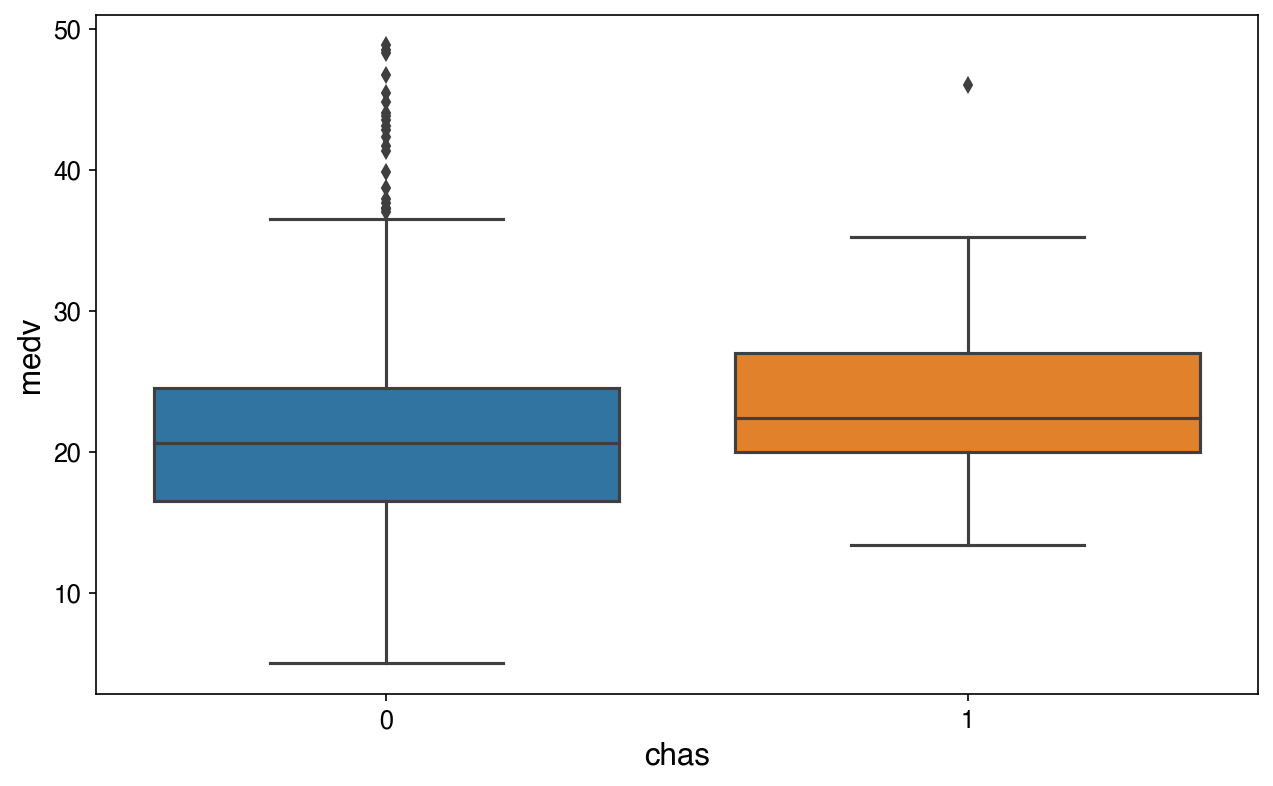

In [82]:
# Boxplot for the categorical variable chas

sns.boxplot(x="chas", y="medv", data=data)
plt.xlabel('chas', fontsize=15)
plt.ylabel('medv', fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('ChasDistribution.png')

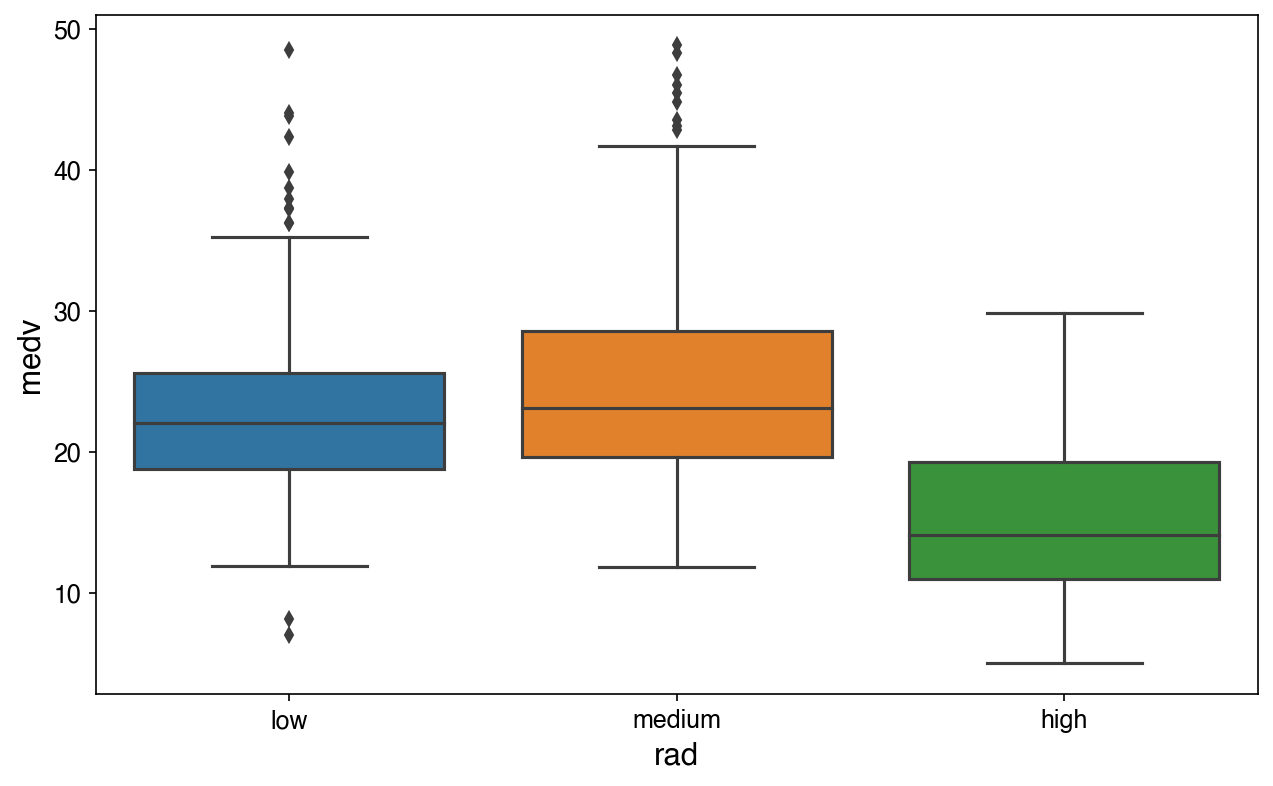

In [83]:
# Boxplot for the categorical variable rad

sns.boxplot(x="rad", y="medv", data=data)
plt.xlabel('rad', fontsize=15)
plt.ylabel('medv', fontsize=15)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('RadDistribution.png')

### Relevant bivariate plots

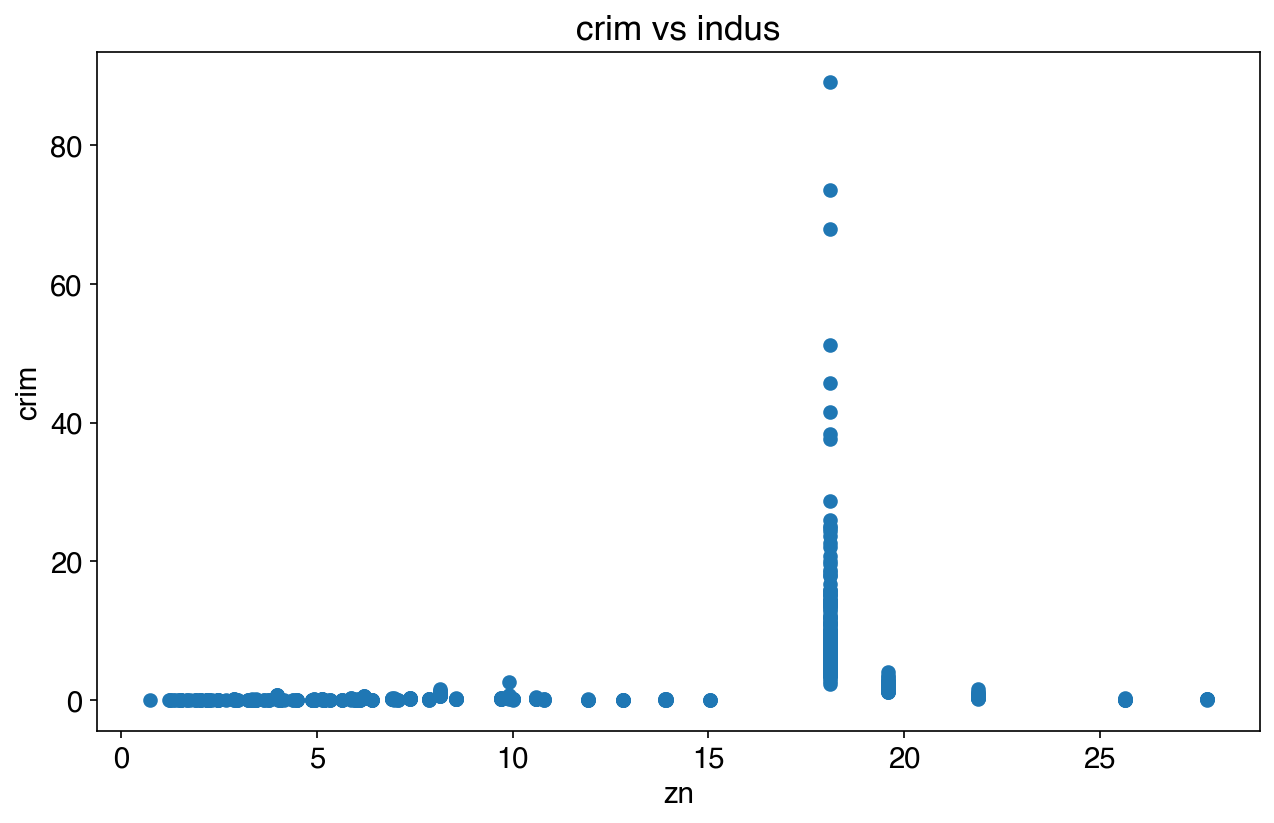

In [57]:
plt.scatter(data['indus'], data['crim'])
plt.title('crim vs indus')
plt.xlabel('zn')
plt.ylabel('crim')
plt.savefig('CrimVsIndus.png')
plt.show()

hide_toggle()

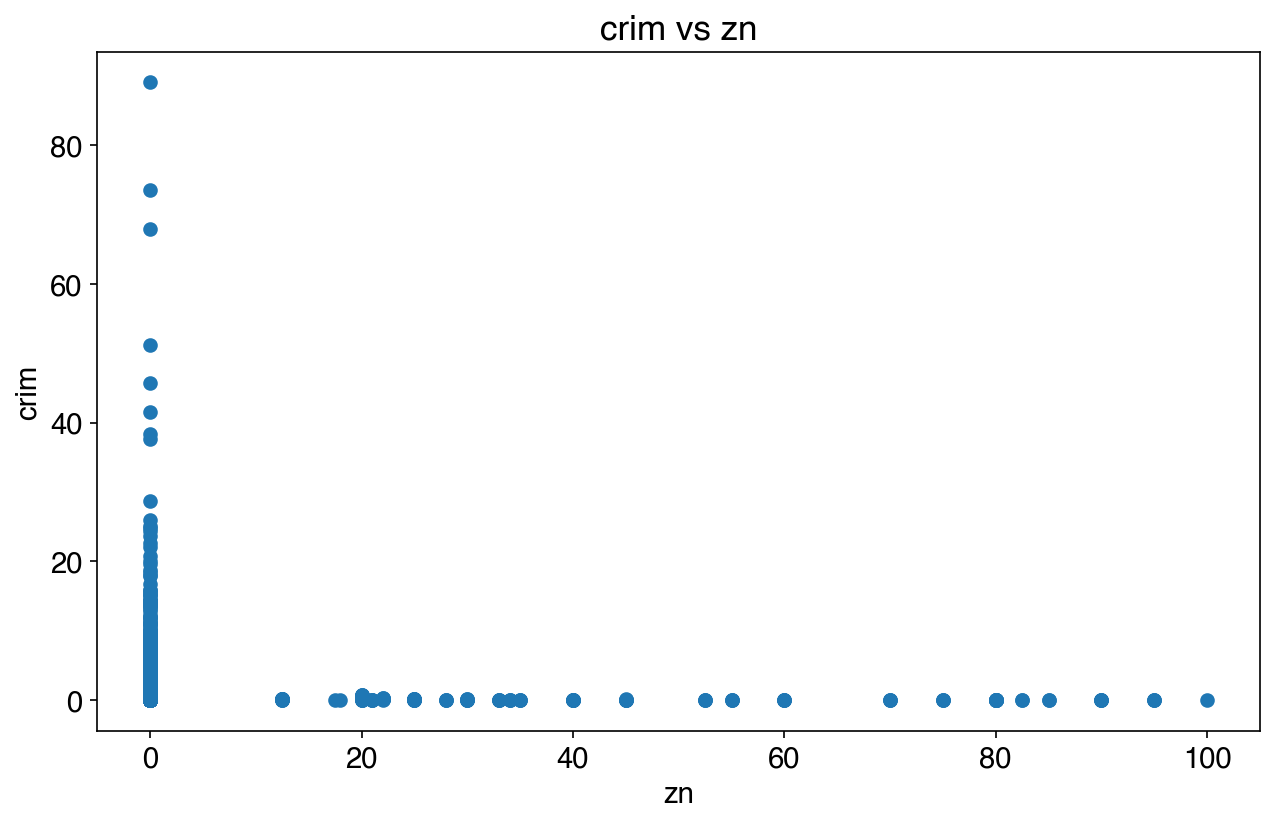

In [53]:
plt.scatter(data['zn'], data['crim'])
plt.title('crim vs zn')
plt.xlabel('zn')
plt.ylabel('crim')
plt.savefig('CrimVsZn.png')
plt.show()

hide_toggle()

In [12]:
# Potential outliers related to crim

crim_out = data[data.crim > 30]
crim_out

idx  crim   zn  indus  chas  nox   rm    age  dis   rad  tax  ptratio  \
380  381 88.98 0.00  18.10     0 0.67 6.97  91.90 1.42  high  666    20.20   
398  399 38.35 0.00  18.10     0 0.69 5.45 100.00 1.49  high  666    20.20   
404  405 41.53 0.00  18.10     0 0.69 5.53  85.40 1.61  high  666    20.20   
405  406 67.92 0.00  18.10     0 0.69 5.68 100.00 1.43  high  666    20.20   
410  411 51.14 0.00  18.10     0 0.60 5.76 100.00 1.41  high  666    20.20   
414  415 45.75 0.00  18.10     0 0.69 4.52 100.00 1.66  high  666    20.20   
418  419 73.53 0.00  18.10     0 0.68 5.96 100.00 1.80  high  666    20.20   
427  428 37.66 0.00  18.10     0 0.68 6.20  78.70 1.86  high  666    20.20   

     black  lstat  medv  
380 396.90  17.21 10.40  
398 396.90  30.59  5.00  
404 329.46  27.38  8.50  
405 384.97  22.98  5.00  
410   2.60  10.11 15.00  
414  88.27  36.98  7.00  
418  16.45  20.62  8.80  
427  18.82  14.52 10.90

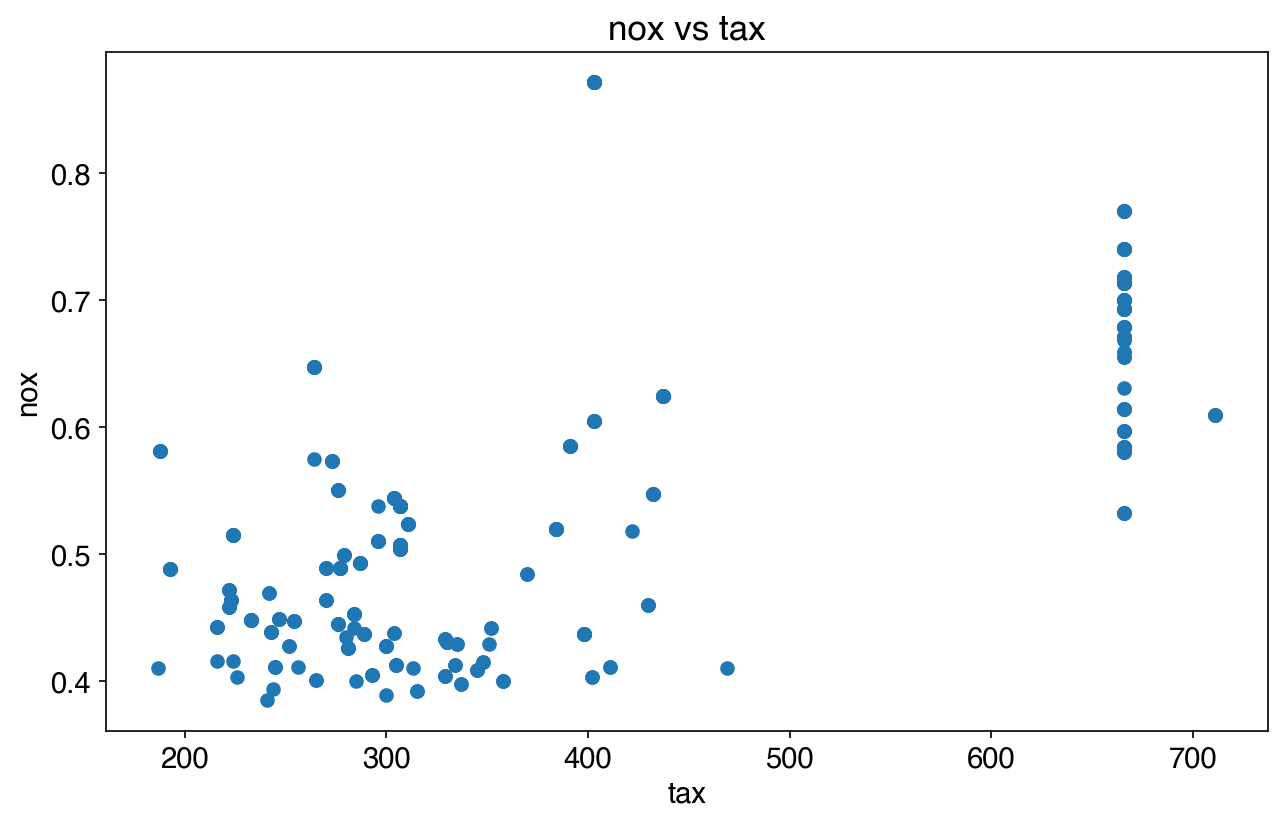

In [55]:
plt.scatter(data['tax'], data['nox'])
plt.title('nox vs tax')
plt.xlabel('tax')
plt.ylabel('nox')
plt.savefig('NoxVsTax.png')
plt.show()

hide_toggle()

In [14]:
# Potential outliers related to nox

nox_out = data[data.nox > 0.8]
nox_out

idx  crim   zn  indus  chas  nox   rm    age  dis     rad  tax  ptratio  \
142  143  3.32 0.00  19.58     1 0.87 5.40 100.00 1.32  medium  403    14.70   
143  144  4.10 0.00  19.58     0 0.87 5.47 100.00 1.41  medium  403    14.70   
144  145  2.78 0.00  19.58     0 0.87 4.90  97.80 1.35  medium  403    14.70   
145  146  2.38 0.00  19.58     0 0.87 6.13 100.00 1.42  medium  403    14.70   
146  147  2.16 0.00  19.58     0 0.87 5.63 100.00 1.52  medium  403    14.70   
147  148  2.37 0.00  19.58     0 0.87 4.93  95.70 1.46  medium  403    14.70   
148  149  2.33 0.00  19.58     0 0.87 5.19  93.80 1.53  medium  403    14.70   
149  150  2.73 0.00  19.58     0 0.87 5.60  94.90 1.53  medium  403    14.70   
150  151  1.66 0.00  19.58     0 0.87 6.12  97.30 1.62  medium  403    14.70   
151  152  1.50 0.00  19.58     0 0.87 5.40 100.00 1.59  medium  403    14.70   
152  153  1.13 0.00  19.58     1 0.87 5.01  88.00 1.61  medium  403    14.70   
153  154  2.15 0.00  19.58     0 0.87 5.71  98.50 1.62  medium  403    14.70   
154  155  1.41 0.00  19.58     1 0.87 6.13  96.00 1.75  medium  403    14.70   
155  156  3.54 0.00  19.58     1 0.87 6.15  82.60 1.75  medium  403    14.70   
156  157  2.45 0.00  19.58     0 0.87 5.27  94.00 1.74  medium  403    14.70   
159  160  1.43 0.00  19.58     0 0.87 6.51 100.00 1.77  medium  403    14.70   

     black  lstat  medv  
142 396.90  26.82 13.40  
143 396.90  26.42 15.60  
144 396.90  29.29 11.80  
145 172.91  27.80 13.80  
146 169.27  16.65 15.60  
147 391.71  29.53 14.60  
148 356.99  28.32 17.80  
149 351.85  21.45 15.40  
150 372.80  14.10 21.50  
151 341.60  13.28 19.60  
152 343.28  12.12 15.30  
153 261.95  15.79 19.40  
154 321.02  15.12 17.00  
155  88.01  15.02 15.60  
156  88.63  16.14 13.10  
159 364.31   7.39 23.30

In [15]:
# Potential outliers related to tax

tax_out = data[(data.tax > 700)]
tax_out

idx  crim   zn  indus  chas  nox   rm   age  dis  rad  tax  ptratio  \
488  489  0.15 0.00  27.74     0 0.61 5.45 92.70 1.82  low  711    20.10   
489  490  0.18 0.00  27.74     0 0.61 5.41 98.30 1.76  low  711    20.10   
490  491  0.21 0.00  27.74     0 0.61 5.09 98.00 1.82  low  711    20.10   
491  492  0.11 0.00  27.74     0 0.61 5.98 98.80 1.87  low  711    20.10   
492  493  0.11 0.00  27.74     0 0.61 5.98 83.50 2.11  low  711    20.10   

     black  lstat  medv  
488 395.09  18.06 15.20  
489 344.05  23.97  7.00  
490 318.43  29.68  8.10  
491 390.11  18.07 13.60  
492 396.90  13.35 20.10

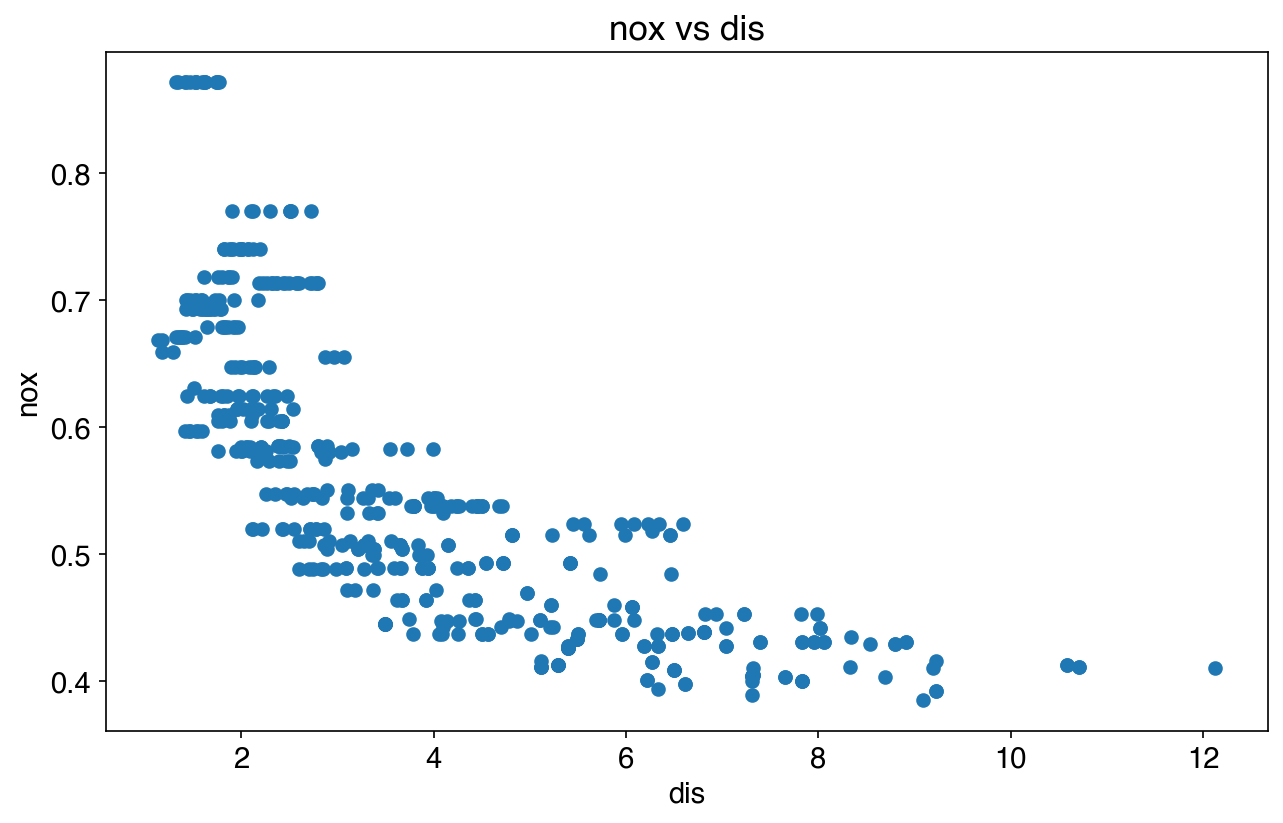

In [56]:
plt.scatter(data['dis'], data['nox'])
plt.title('nox vs dis')
plt.xlabel('dis')
plt.ylabel('nox')
plt.savefig('NoxVsDis.png')
plt.show()

hide_toggle()

In [17]:
# Potential outliers related to dis

dis_out = data[data.dis > 10]
dis_out

idx  crim    zn  indus  chas  nox   rm   age   dis     rad  tax  ptratio  \
351  352  0.08 60.00   1.69     0 0.41 6.58 35.90 10.71     low  411    18.30   
352  353  0.07 60.00   1.69     0 0.41 5.88 18.50 10.71     low  411    18.30   
353  354  0.02 90.00   2.02     0 0.41 6.73 36.10 12.13  medium  187    17.00   
354  355  0.04 80.00   1.91     0 0.41 5.66 21.90 10.59     low  334    22.00   
355  356  0.11 80.00   1.91     0 0.41 5.94 19.50 10.59     low  334    22.00   

     black  lstat  medv  
351 370.78   5.49 24.10  
352 392.33   7.79 18.60  
353 384.46   4.50 30.10  
354 382.80   8.05 18.20  
355 376.04   5.57 20.60

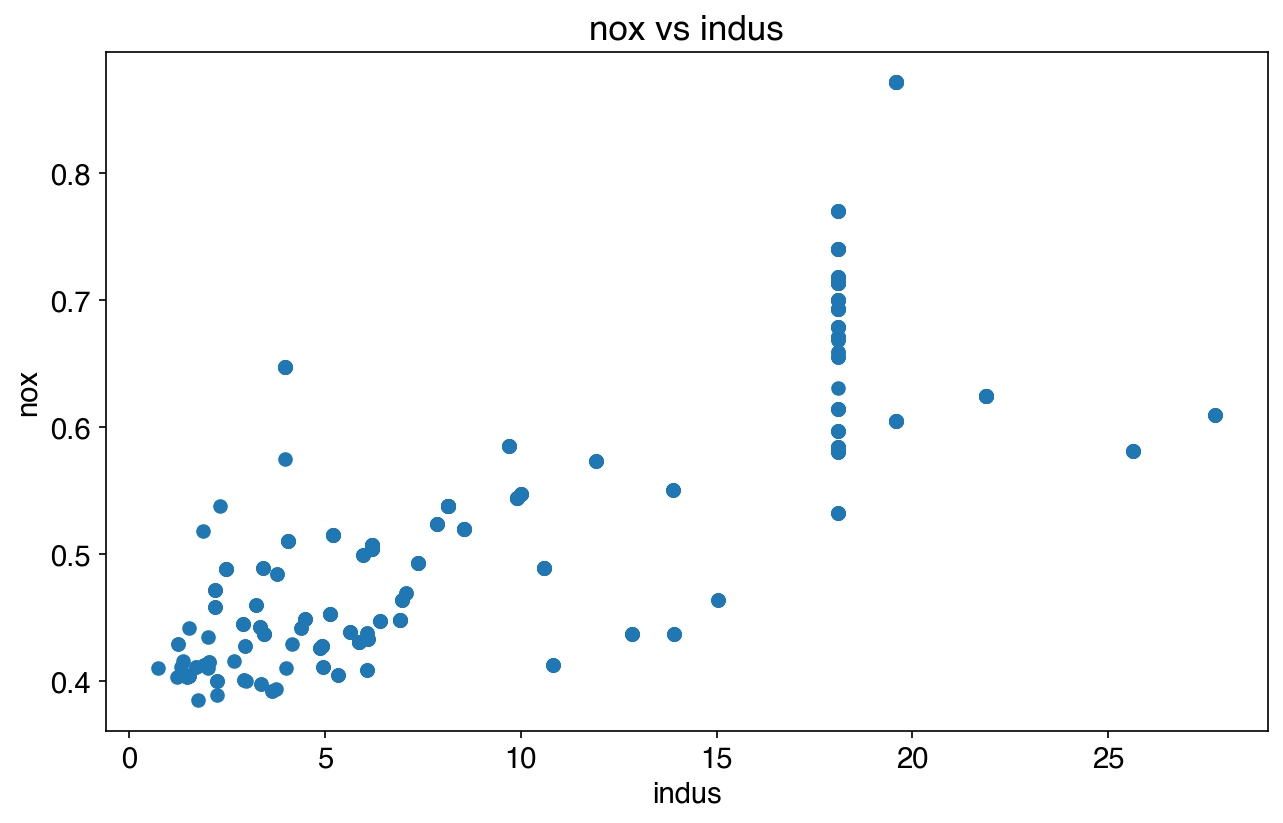

In [59]:
plt.scatter(data['indus'], data['nox'])
plt.title('nox vs indus')
plt.xlabel('indus')
plt.ylabel('nox')
plt.savefig('NoxVsIndus.png')
plt.show()

hide_toggle()

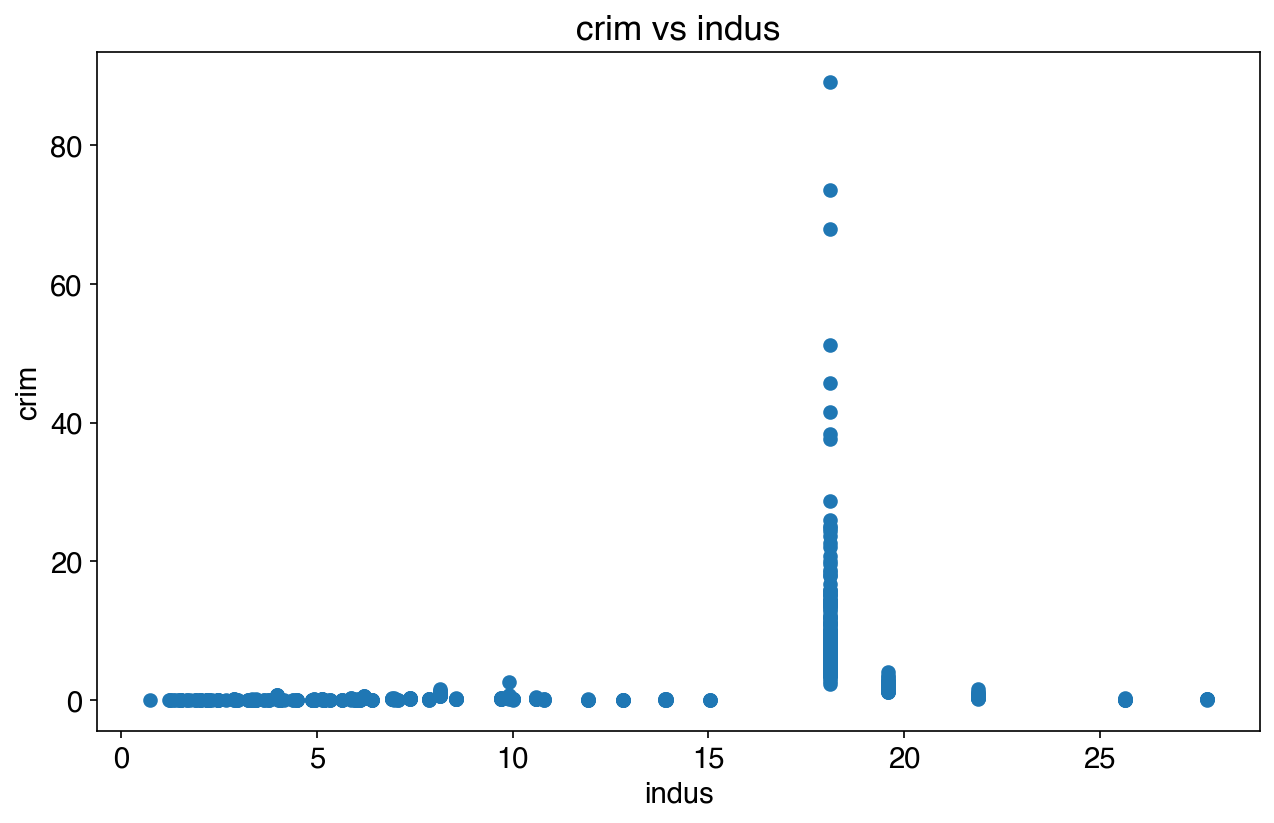

In [60]:
plt.scatter(data['indus'], data['crim'])
plt.title('crim vs indus')
plt.ylabel('crim')
plt.xlabel('indus')
plt.savefig('CrimVsIndus.png')
plt.show()

hide_toggle()

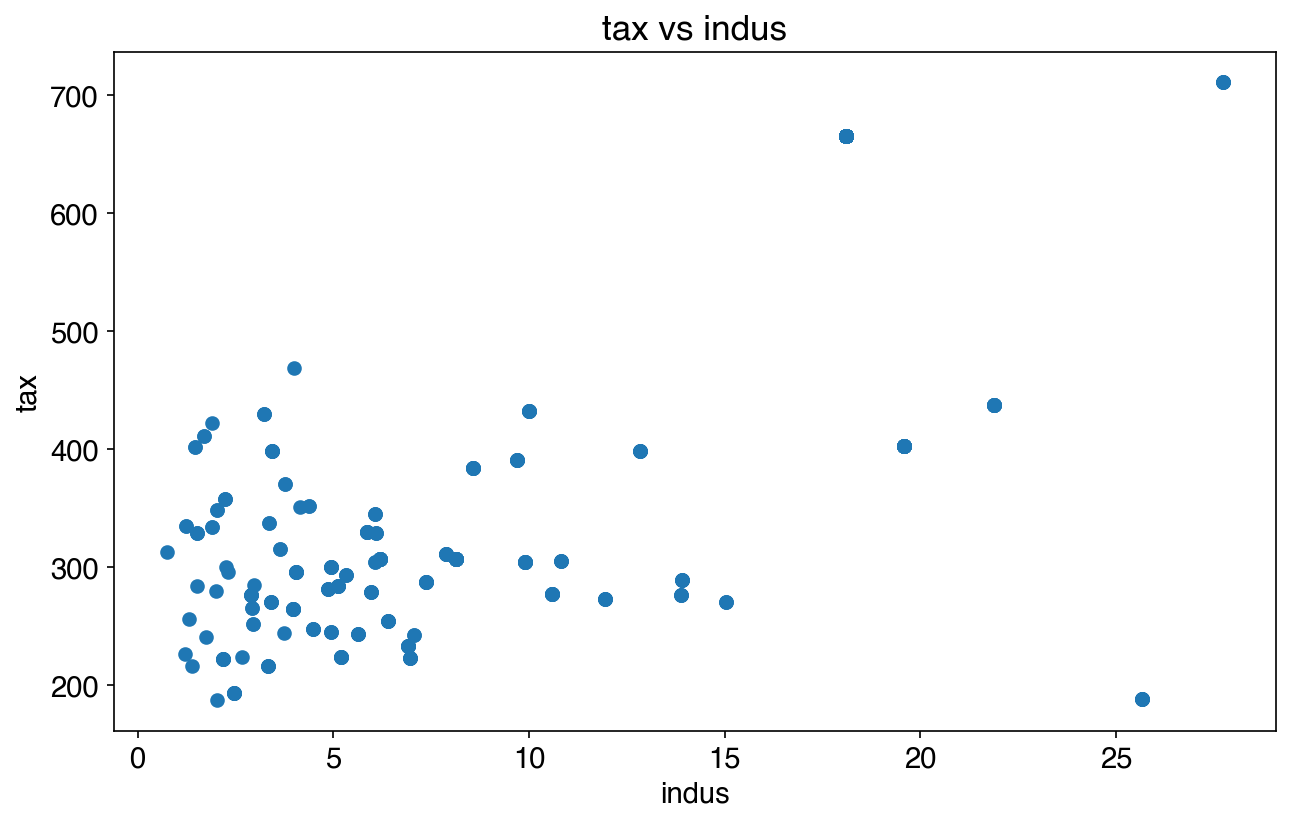

In [61]:
plt.scatter(data['indus'], data['tax'])
plt.title('tax vs indus')
plt.ylabel('tax')
plt.xlabel('indus')
plt.savefig('TaxVsIndus.png')
plt.show()

hide_toggle()

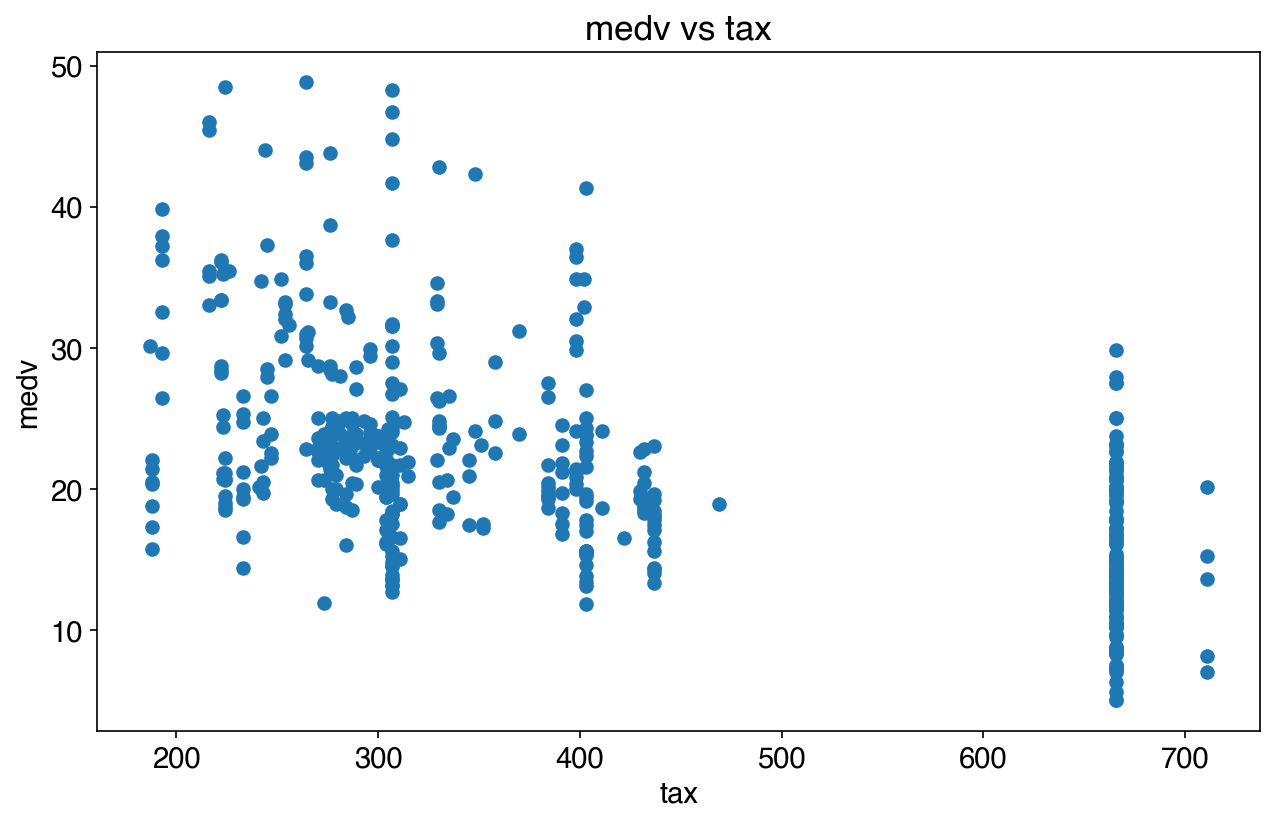

In [62]:
plt.scatter(data['tax'], data['medv'])
plt.title('medv vs tax')
plt.ylabel('medv')
plt.xlabel('tax')
plt.savefig('MedvVsTax.png')
plt.show()

hide_toggle()

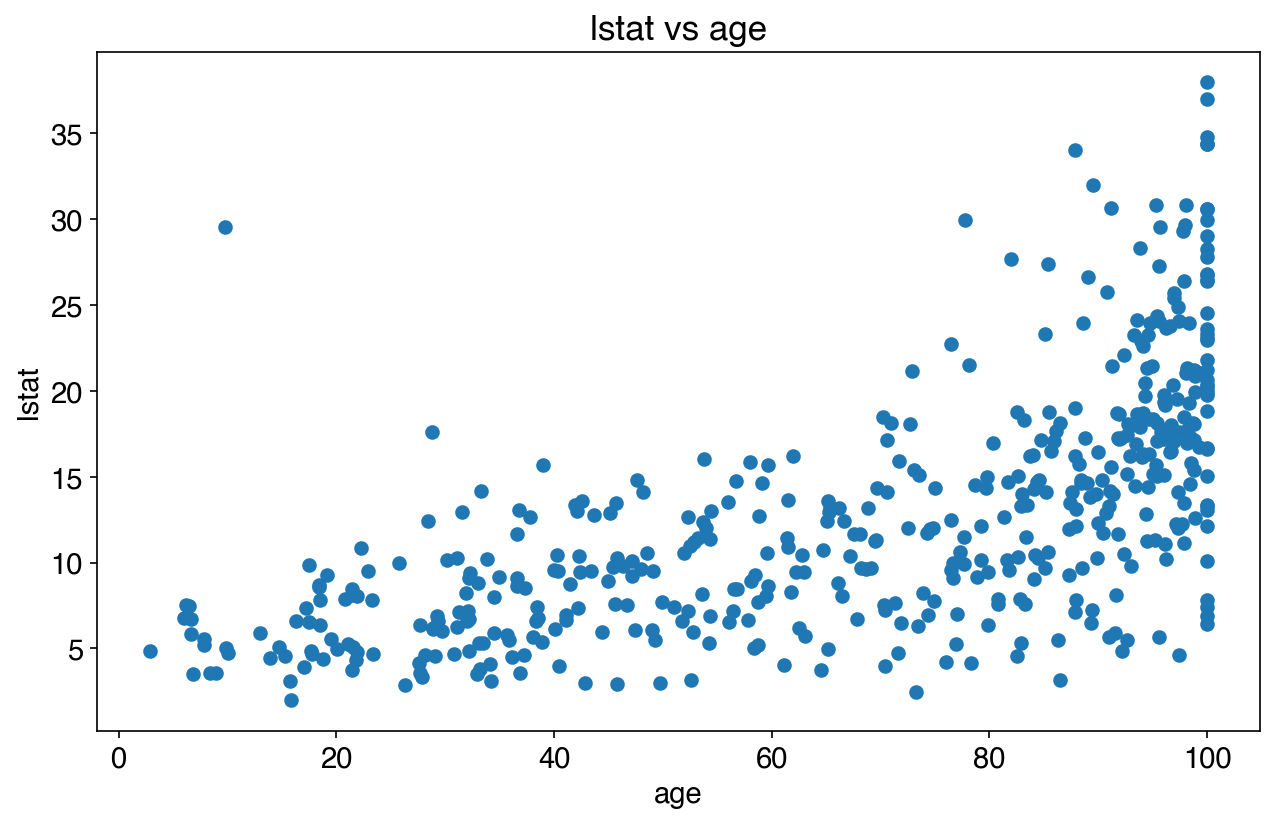

In [63]:
plt.scatter(data['age'], data['lstat'])
plt.title('lstat vs age')
plt.ylabel('lstat')
plt.xlabel('age')
plt.savefig('LstatVsAge.png')
plt.show()

hide_toggle()

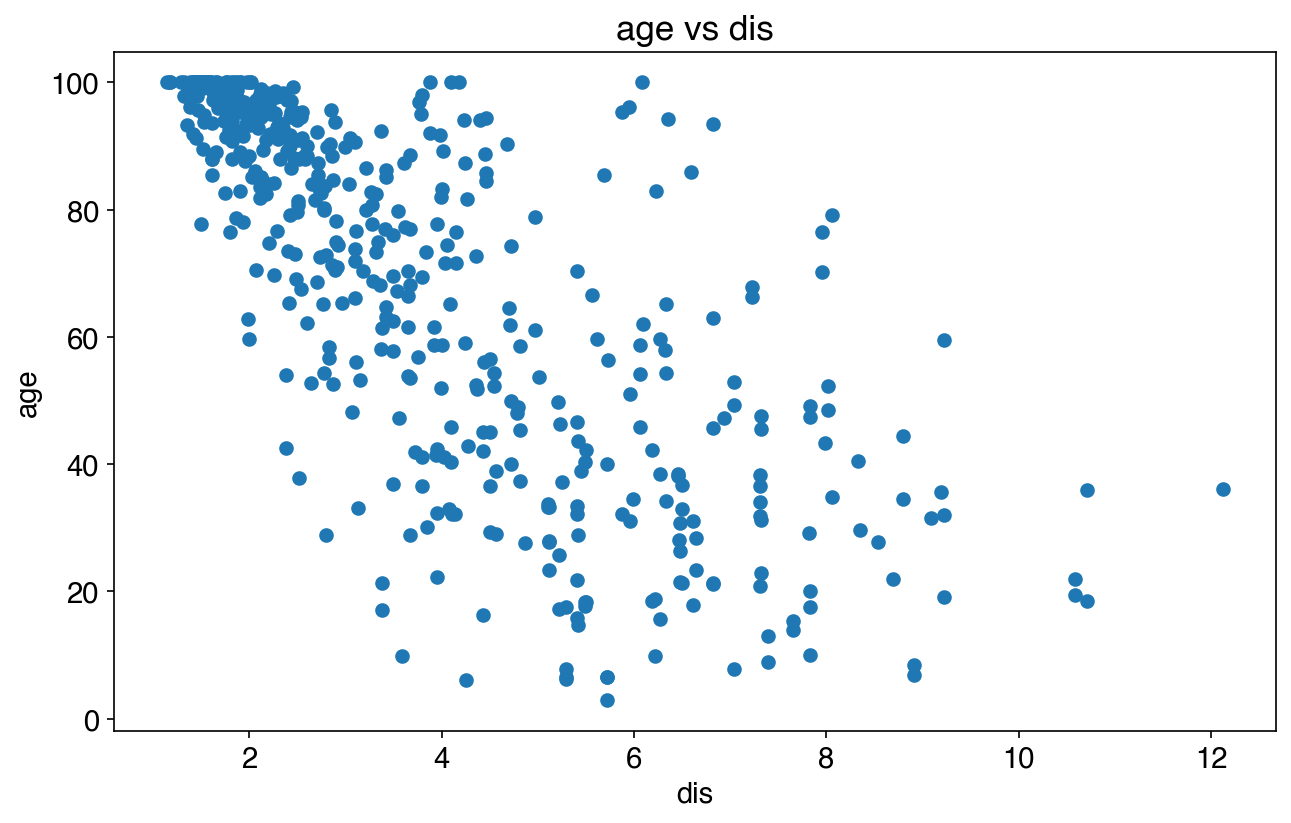

In [64]:
plt.scatter(data['dis'], data['age'])
plt.title('age vs dis')
plt.ylabel('age')
plt.xlabel('dis')
plt.savefig('AgeVsDis.png')
plt.show()

hide_toggle()

In [24]:
# Potential outliers related to age

lstat_out = data[(data.age < 10) & (data.lstat > 20)]
lstat_out

idx  crim   zn  indus  chas  nox   rm  age  dis  rad  tax  ptratio  \
214  215  0.29 0.00  10.59     0 0.49 5.41 9.80 3.59  low  277    18.60   

     black  lstat  medv  
214 348.93  29.55 23.70

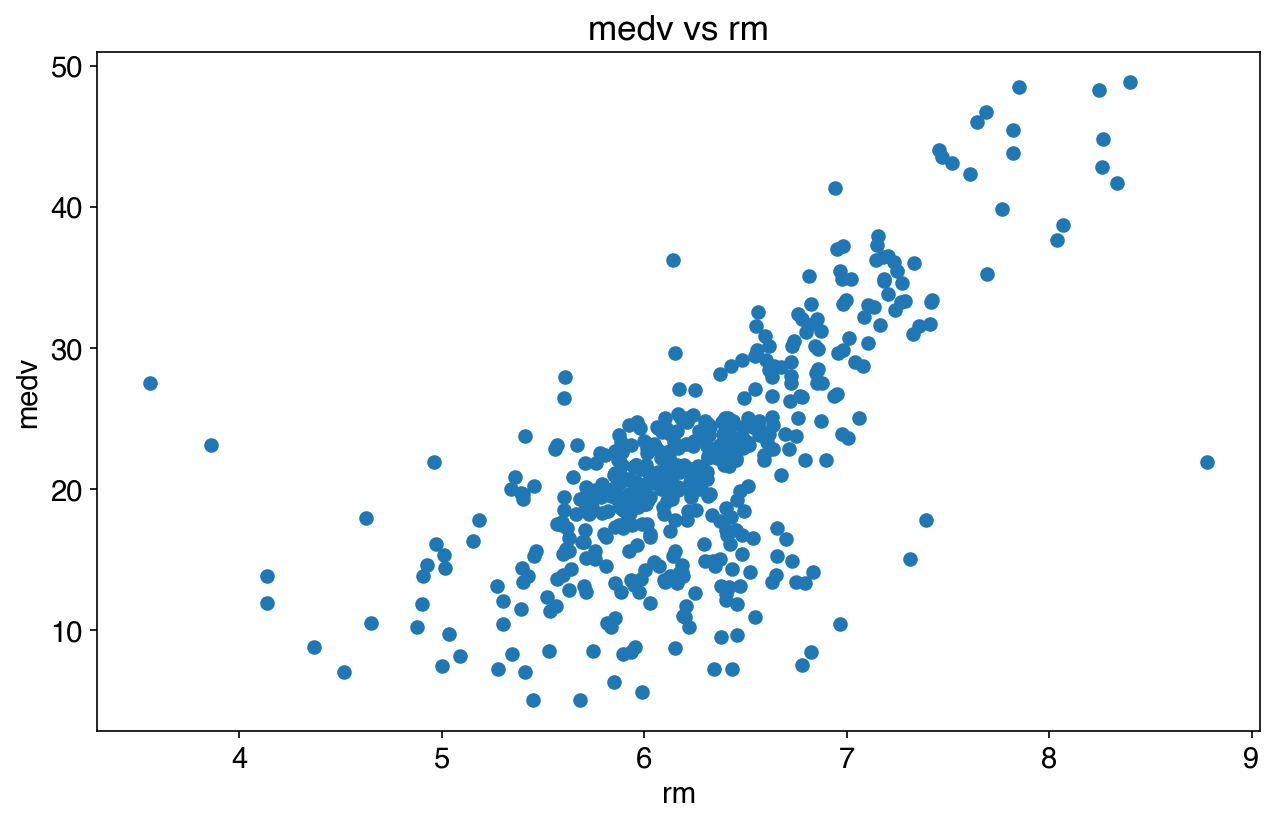

In [65]:
plt.scatter(data['rm'], data['medv'])
plt.title('medv vs rm')
plt.ylabel('medv')
plt.xlabel('rm')
plt.savefig('MedvVsRm0.png')
plt.show()

hide_toggle()

In [26]:
# Potential outliers related to rm

rm_out_1 = data[data.rm < 4]
rm_out_1

idx  crim   zn  indus  chas  nox   rm    age  dis   rad  tax  ptratio  \
365  366  4.56 0.00  18.10     0 0.72 3.56  87.90 1.61  high  666    20.20   
367  368 13.52 0.00  18.10     0 0.63 3.86 100.00 1.51  high  666    20.20   

     black  lstat  medv  
365 354.70   7.12 27.50  
367 131.42  13.33 23.10

In [27]:
# Potential outliers related to rm

rm_out_2 = data[data.rm > 8]
rm_out_2

idx  crim    zn  indus  chas  nox   rm   age  dis     rad  tax  ptratio  \
97    98  0.12  0.00   2.89     0 0.45 8.07 76.00 3.50     low  276    18.00   
224  225  0.32  0.00   6.20     0 0.50 8.27 78.30 2.89  medium  307    17.40   
226  227  0.38  0.00   6.20     0 0.50 8.04 86.50 3.22  medium  307    17.40   
232  233  0.58  0.00   6.20     0 0.51 8.34 73.30 3.84  medium  307    17.40   
233  234  0.33  0.00   6.20     0 0.51 8.25 70.40 3.65  medium  307    17.40   
253  254  0.37 22.00   5.86     0 0.43 8.26  8.40 8.91  medium  330    19.10   
262  263  0.52 20.00   3.97     0 0.65 8.40 91.50 2.29  medium  264    13.00   
364  365  3.47  0.00  18.10     1 0.72 8.78 82.90 1.90    high  666    20.20   

     black  lstat  medv  
97  396.90   4.21 38.70  
224 385.05   4.14 44.80  
226 387.38   3.13 37.60  
232 385.91   2.47 41.70  
233 378.95   3.95 48.30  
253 396.90   3.54 42.80  
262 386.86   5.91 48.80  
364 354.55   5.29 21.90

In [28]:
# Potential categorical outliers

chas_out = data[(data.chas == 1) & (data.medv > 40)]
chas_out

idx  crim    zn  indus  chas  nox   rm   age  dis     rad  tax  ptratio  \
282  283  0.06 20.00   3.33     1 0.44 7.64 49.70 5.21  medium  216    14.90   

     black  lstat  medv  
282 377.07   3.01 46.00

In [29]:
# Define dataframe that contains potential outliers

potential_outliers = pd.concat((crim_out, nox_out, tax_out, dis_out, lstat_out, rm_out_1, rm_out_2, chas_out))
potential_outliers.shape

(46, 15)

In [30]:
# Compute the number of duplicated rows

potential_outliers.duplicated().sum()

0

In [49]:
# Visualize set of all potential outliers based on bivariate distributions

potential_outliers.sort_values('idx')

idx  crim    zn  indus  chas  nox   rm    age   dis     rad  tax  \
97    98  0.12  0.00   2.89     0 0.45 8.07  76.00  3.50     low  276   
142  143  3.32  0.00  19.58     1 0.87 5.40 100.00  1.32  medium  403   
143  144  4.10  0.00  19.58     0 0.87 5.47 100.00  1.41  medium  403   
144  145  2.78  0.00  19.58     0 0.87 4.90  97.80  1.35  medium  403   
145  146  2.38  0.00  19.58     0 0.87 6.13 100.00  1.42  medium  403   
146  147  2.16  0.00  19.58     0 0.87 5.63 100.00  1.52  medium  403   
147  148  2.37  0.00  19.58     0 0.87 4.93  95.70  1.46  medium  403   
148  149  2.33  0.00  19.58     0 0.87 5.19  93.80  1.53  medium  403   
149  150  2.73  0.00  19.58     0 0.87 5.60  94.90  1.53  medium  403   
150  151  1.66  0.00  19.58     0 0.87 6.12  97.30  1.62  medium  403   
151  152  1.50  0.00  19.58     0 0.87 5.40 100.00  1.59  medium  403   
152  153  1.13  0.00  19.58     1 0.87 5.01  88.00  1.61  medium  403   
153  154  2.15  0.00  19.58     0 0.87 5.71  98.50  1.62  medium  403   
154  155  1.41  0.00  19.58     1 0.87 6.13  96.00  1.75  medium  403   
155  156  3.54  0.00  19.58     1 0.87 6.15  82.60  1.75  medium  403   
156  157  2.45  0.00  19.58     0 0.87 5.27  94.00  1.74  medium  403   
159  160  1.43  0.00  19.58     0 0.87 6.51 100.00  1.77  medium  403   
214  215  0.29  0.00  10.59     0 0.49 5.41   9.80  3.59     low  277   
224  225  0.32  0.00   6.20     0 0.50 8.27  78.30  2.89  medium  307   
226  227  0.38  0.00   6.20     0 0.50 8.04  86.50  3.22  medium  307   
232  233  0.58  0.00   6.20     0 0.51 8.34  73.30  3.84  medium  307   
233  234  0.33  0.00   6.20     0 0.51 8.25  70.40  3.65  medium  307   
253  254  0.37 22.00   5.86     0 0.43 8.26   8.40  8.91  medium  330   
262  263  0.52 20.00   3.97     0 0.65 8.40  91.50  2.29  medium  264   
282  283  0.06 20.00   3.33     1 0.44 7.64  49.70  5.21  medium  216   
351  352  0.08 60.00   1.69     0 0.41 6.58  35.90 10.71     low  411   
352  353  0.07 60.00   1.69     0 0.41 5.88  18.50 10.71     low  411   
353  354  0.02 90.00   2.02     0 0.41 6.73  36.10 12.13  medium  187   
354  355  0.04 80.00   1.91     0 0.41 5.66  21.90 10.59     low  334   
355  356  0.11 80.00   1.91     0 0.41 5.94  19.50 10.59     low  334   
364  365  3.47  0.00  18.10     1 0.72 8.78  82.90  1.90    high  666   
365  366  4.56  0.00  18.10     0 0.72 3.56  87.90  1.61    high  666   
367  368 13.52  0.00  18.10     0 0.63 3.86 100.00  1.51    high  666   
380  381 88.98  0.00  18.10     0 0.67 6.97  91.90  1.42    high  666   
398  399 38.35  0.00  18.10     0 0.69 5.45 100.00  1.49    high  666   
404  405 41.53  0.00  18.10     0 0.69 5.53  85.40  1.61    high  666   
405  406 67.92  0.00  18.10     0 0.69 5.68 100.00  1.43    high  666   
410  411 51.14  0.00  18.10     0 0.60 5.76 100.00  1.41    high  666   
414  415 45.75  0.00  18.10     0 0.69 4.52 100.00  1.66    high  666   
418  419 73.53  0.00  18.10     0 0.68 5.96 100.00  1.80    high  666   
427  428 37.66  0.00  18.10     0 0.68 6.20  78.70  1.86    high  666   
488  489  0.15  0.00  27.74     0 0.61 5.45  92.70  1.82     low  711   
489  490  0.18  0.00  27.74     0 0.61 5.41  98.30  1.76     low  711   
490  491  0.21  0.00  27.74     0 0.61 5.09  98.00  1.82     low  711   
491  492  0.11  0.00  27.74     0 0.61 5.98  98.80  1.87     low  711   
492  493  0.11  0.00  27.74     0 0.61 5.98  83.50  2.11     low  711   

     ptratio  black  lstat  medv  
97     18.00 396.90   4.21 38.70  
142    14.70 396.90  26.82 13.40  
143    14.70 396.90  26.42 15.60  
144    14.70 396.90  29.29 11.80  
145    14.70 172.91  27.80 13.80  
146    14.70 169.27  16.65 15.60  
147    14.70 391.71  29.53 14.60  
148    14.70 356.99  28.32 17.80  
149    14.70 351.85  21.45 15.40  
150    14.70 372.80  14.10 21.50  
151    14.70 341.60  13.28 19.60  
152    14.70 343.28  12.12 15.30  
153    14.70 261.95  15.79 19.40  
154    14.70 321.02  15.12 17.00  
155    14.70  88.01  15.02 15.60  
156    14.70 

## Clustering

In [32]:
# Define the two clusters

df_1 = data[data.indus == 18.1]
df_2 = data[data.indus != 18.1]

In [33]:
# The shapes are

print('Shape of dataframe for cluster 1 is: ' + str(df_1.shape[0]))
print('Shape of dataframe for cluster 2 is: ' + str(df_2.shape[0]))

Shape of dataframe for cluster 1 is: 127
Shape of dataframe for cluster 2 is: 363


### Cluster1

In [34]:
# Note that the variables indus, zn, tax, ptratio are fixed on this cluster

print('No. of unique values for indus: ' + str(df_1.indus.nunique()))
print('No. of unique values for zn: ' + str(df_1.zn.nunique()))
print('No. of unique values for tax: ' + str(df_1.tax.nunique()))
print('No. of unique values for ptratio: ' + str(df_1.ptratio.nunique()))

No. of unique values for indus: 1
No. of unique values for zn: 1
No. of unique values for tax: 1
No. of unique values for ptratio: 1


In [35]:
# Eliminate useless columns

df_1.drop(columns=['indus', 'zn', 'tax', 'ptratio'], inplace=True)
df_1.head(3)

idx  crim  chas  nox   rm   age  dis   rad  black  lstat  medv
356  357  8.98     1 0.77 6.21 97.40 2.12  high 377.73  17.60 17.80
357  358  3.85     1 0.77 6.39 91.00 2.51  high 391.34  13.27 21.70
358  359  5.20     1 0.77 6.13 83.40 2.72  high 395.43  11.48 22.70

In [36]:
# Also note that there is no rad = high in cluster 1

df_1[df_1.rad != 'high'].shape

(0, 11)

In [37]:
# Define restricted set of variables

num_var1 = ['crim', 'nox', 'rm', 'age', 'dis', 'black', 'lstat', 'medv']
num_var1

['crim', 'nox', 'rm', 'age', 'dis', 'black', 'lstat', 'medv']

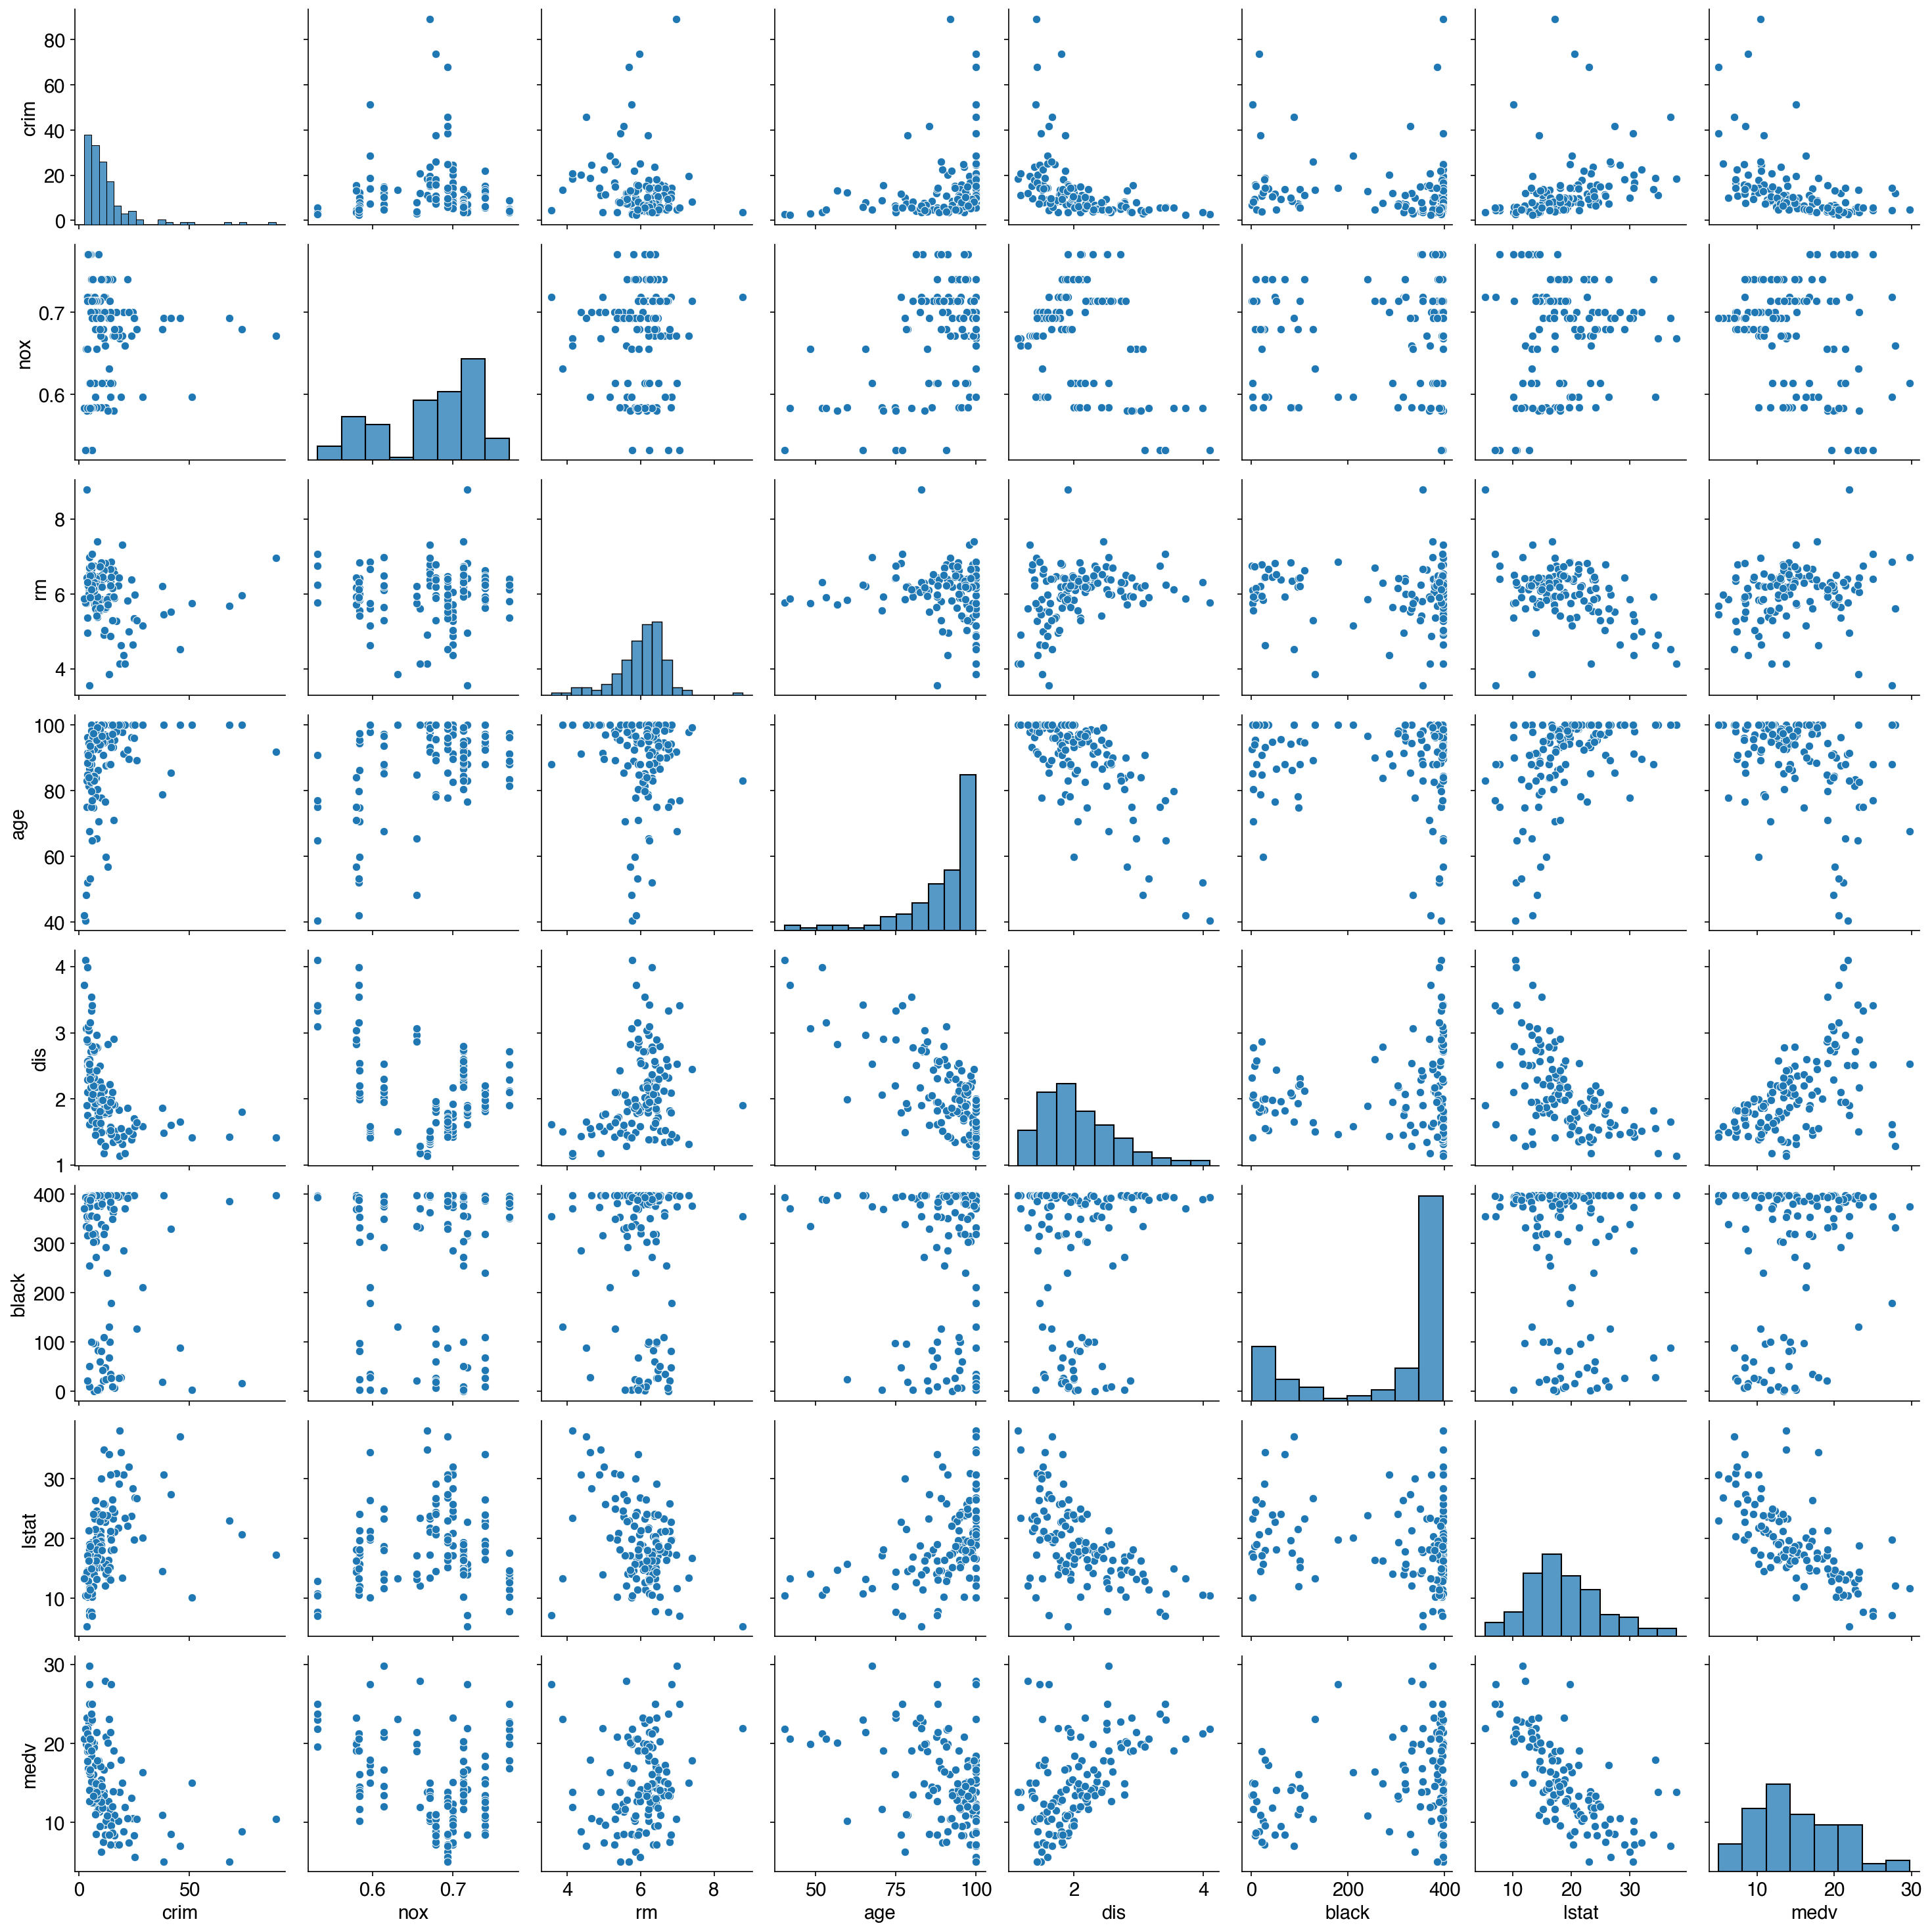

In [38]:
# Pairplot of cluster 1

sns.pairplot(df_1[num_var1])
plt.savefig('ScatterCluster1.png')

In [39]:
# Compute Mahalanobis distances

df_out = df_1

mean_vector = df_out[num_var1].mean()
inv_cov_matrix = np.linalg.inv(df_out[num_var1].cov())
df_mahal = df_out.copy()

# Calculate the Mahalanobis distance for each point
df_mahal['Mahalanobis'] = df_mahal[num_var1].apply(lambda row: distance.mahalanobis(row, mean_vector, inv_cov_matrix), axis=1)

# Calculate the threshold for the Mahalanobis distance
threshold = np.sqrt(chi2.ppf((1-0.01), df=df_mahal.shape[1]))  # 99% quantile of Chi-squared distribution

# Identify the outliers
outliers = df_mahal[df_mahal['Mahalanobis'] > threshold]

# Calculate the percentage of data points that were removed
percentage_removed = len(outliers) / len(df_mahal) * 100

# Outcome
print(f"Percentage of potential outliers: {percentage_removed:.2f}%")
print(f"The threshold is: {threshold:.2f}")

Percentage of potential outliers: 2.36%
The threshold is: 5.12


In [40]:
# The outliers according to the Mahalanobis method are

outliers

idx  crim  chas  nox   rm    age  dis   rad  black  lstat  medv  \
365  366  4.56     0 0.72 3.56  87.90 1.61  high 354.70   7.12 27.50   
380  381 88.98     0 0.67 6.97  91.90 1.42  high 396.90  17.21 10.40   
418  419 73.53     0 0.68 5.96 100.00 1.80  high  16.45  20.62  8.80   

     Mahalanobis  
365         5.55  
380         6.67  
418         5.30

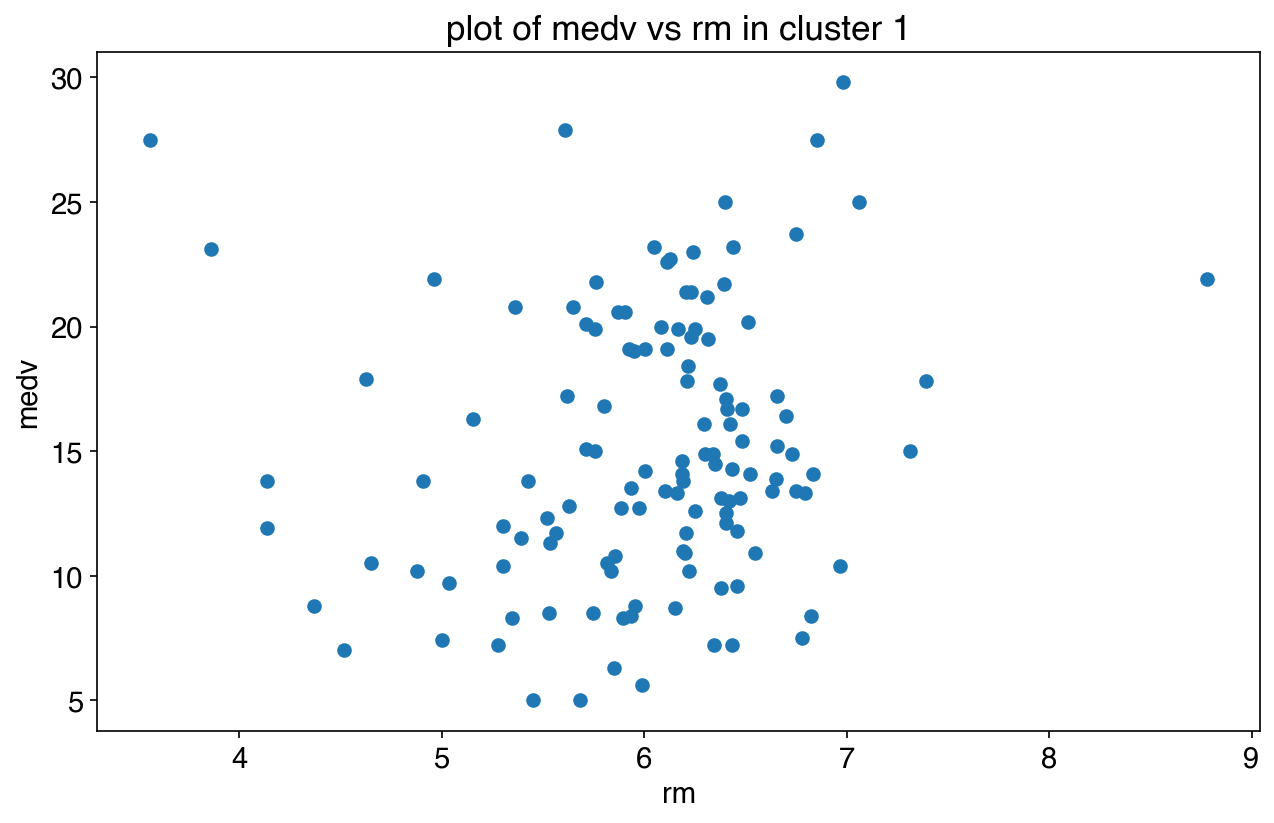

In [41]:
# The points idx = 366 corresponds to the leftmost point in the following plot

plt.scatter(df_1['rm'], df_1['medv'])
plt.title('plot of medv vs rm in cluster 1')
plt.ylabel('medv')
plt.xlabel('rm')
plt.savefig('MedvVsRm.png')
plt.show()

hide_toggle()

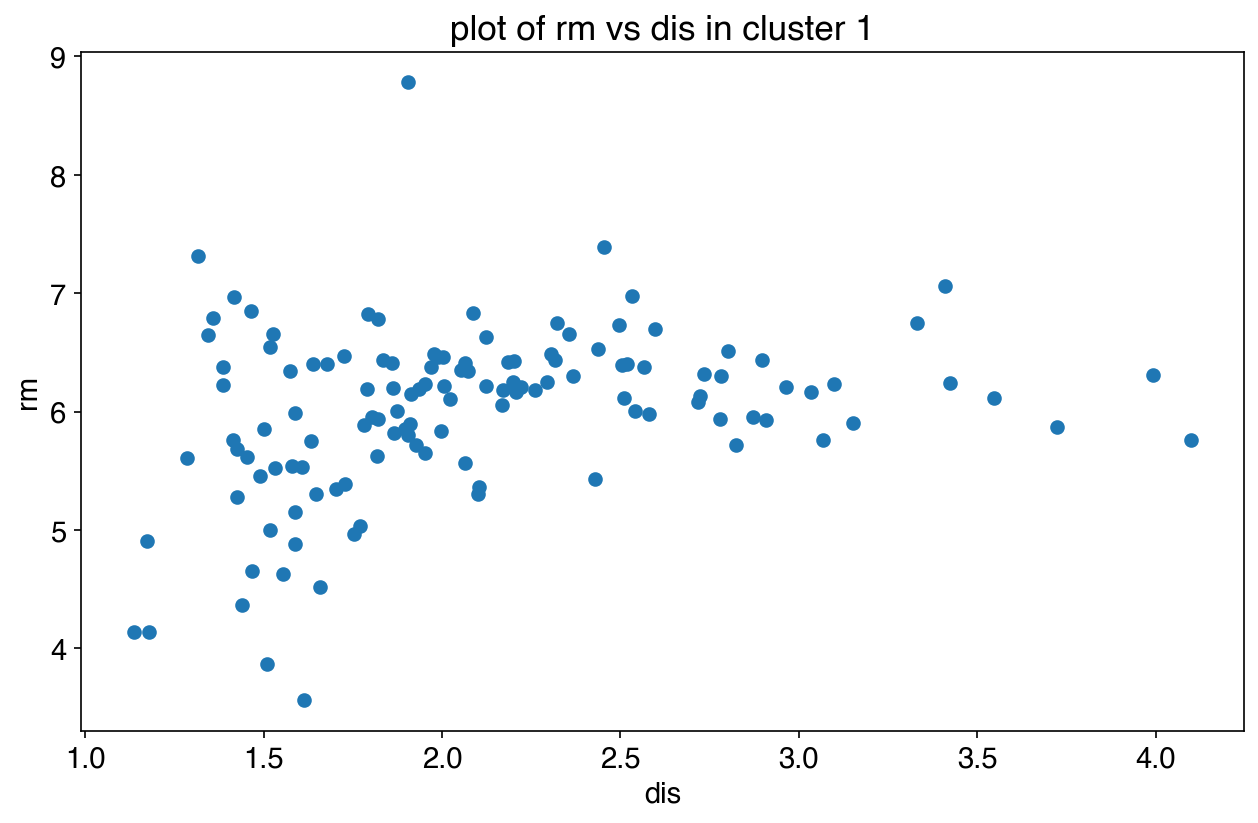

In [42]:
# The points idx = 366 corresponds to the leftmost point in the following plot

plt.scatter(df_1['dis'], df_1['rm'])
plt.title('plot of rm vs dis in cluster 1')
plt.ylabel('rm')
plt.xlabel('dis')
plt.savefig('RmVsDis_1.png')
plt.show()

hide_toggle()

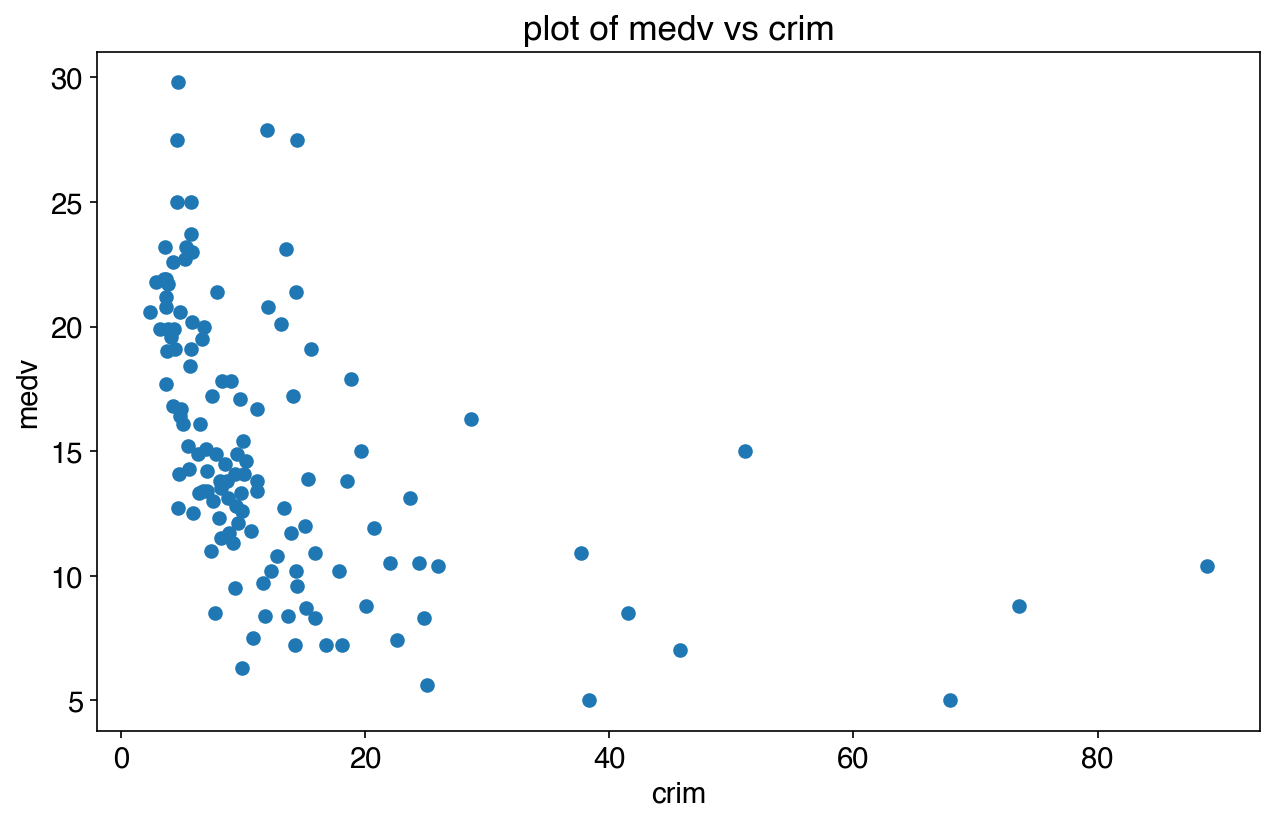

In [162]:
# The points idx = 381, 419 correspond to the rightmost points in the following plot

plt.scatter(df_1['crim'], df_1['medv'])
plt.title('plot of medv vs crim in cluster 1')
plt.ylabel('medv')
plt.xlabel('crim')
#plt.savefig('MedvVsRm.png')
plt.show()

hide_toggle()

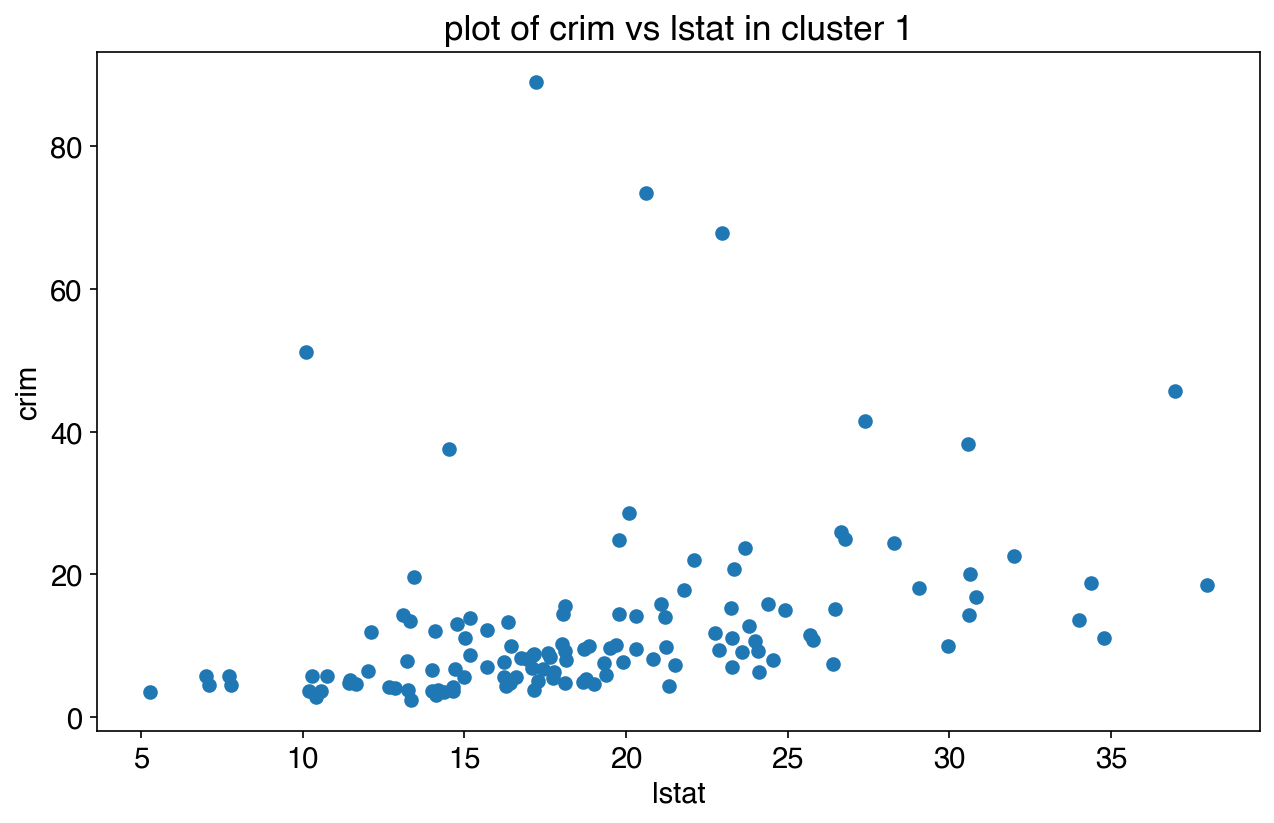

In [183]:
# The points idx = 366 corresponds to the leftmost point in the following plot

plt.scatter(df_1['lstat'], df_1['crim'])
plt.title('plot of crim vs lstat in cluster 1')
plt.ylabel('crim')
plt.xlabel('lstat')
plt.savefig('CrimVsLstat.png')
plt.show()

hide_toggle()

In [155]:
# Recall that these three points are already contained in the list of potential outliers idenitified above.

potential_outliers.idx.unique()

array([381, 399, 405, 406, 411, 415, 419, 428, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 489, 490,
       491, 492, 493, 352, 353, 354, 355, 356, 215, 366, 368,  98, 225,
       227, 233, 234, 254, 263, 365, 283])

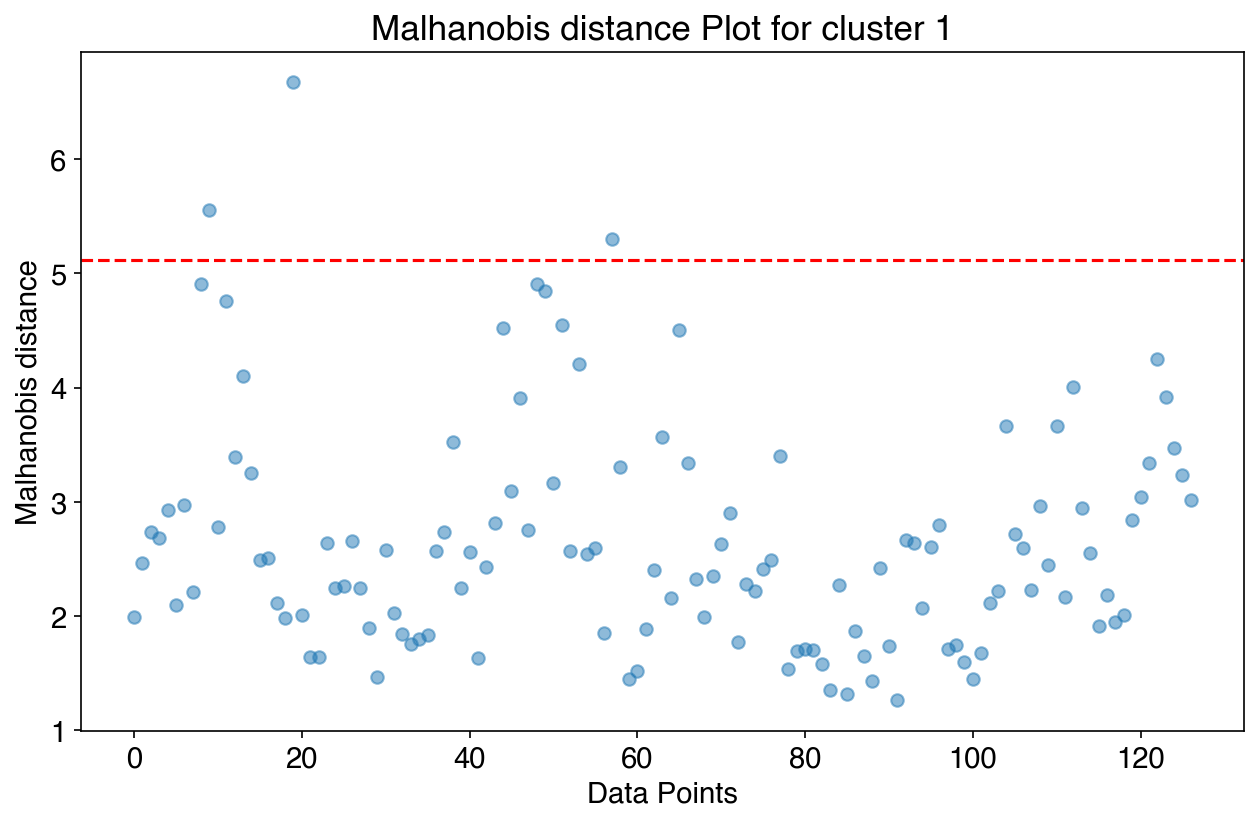

In [171]:
plt.scatter(range(len(df_mahal)), df_mahal.Mahalanobis, alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Malhanobis distance')
plt.title('Malhanobis distance Plot for cluster 1')
plt.savefig('Malahanobis1.png')
plt.show()

hide_toggle()

In [47]:
# Indices corresponding to the outliers

ind_out_1 = [380, 418]
ind_out_1

[380, 418]

In [48]:
# Remove the outliers from the dataset

df_1_cleaned = df_1.drop(index=ind_out_1)
df_1_cleaned.shape

(125, 11)

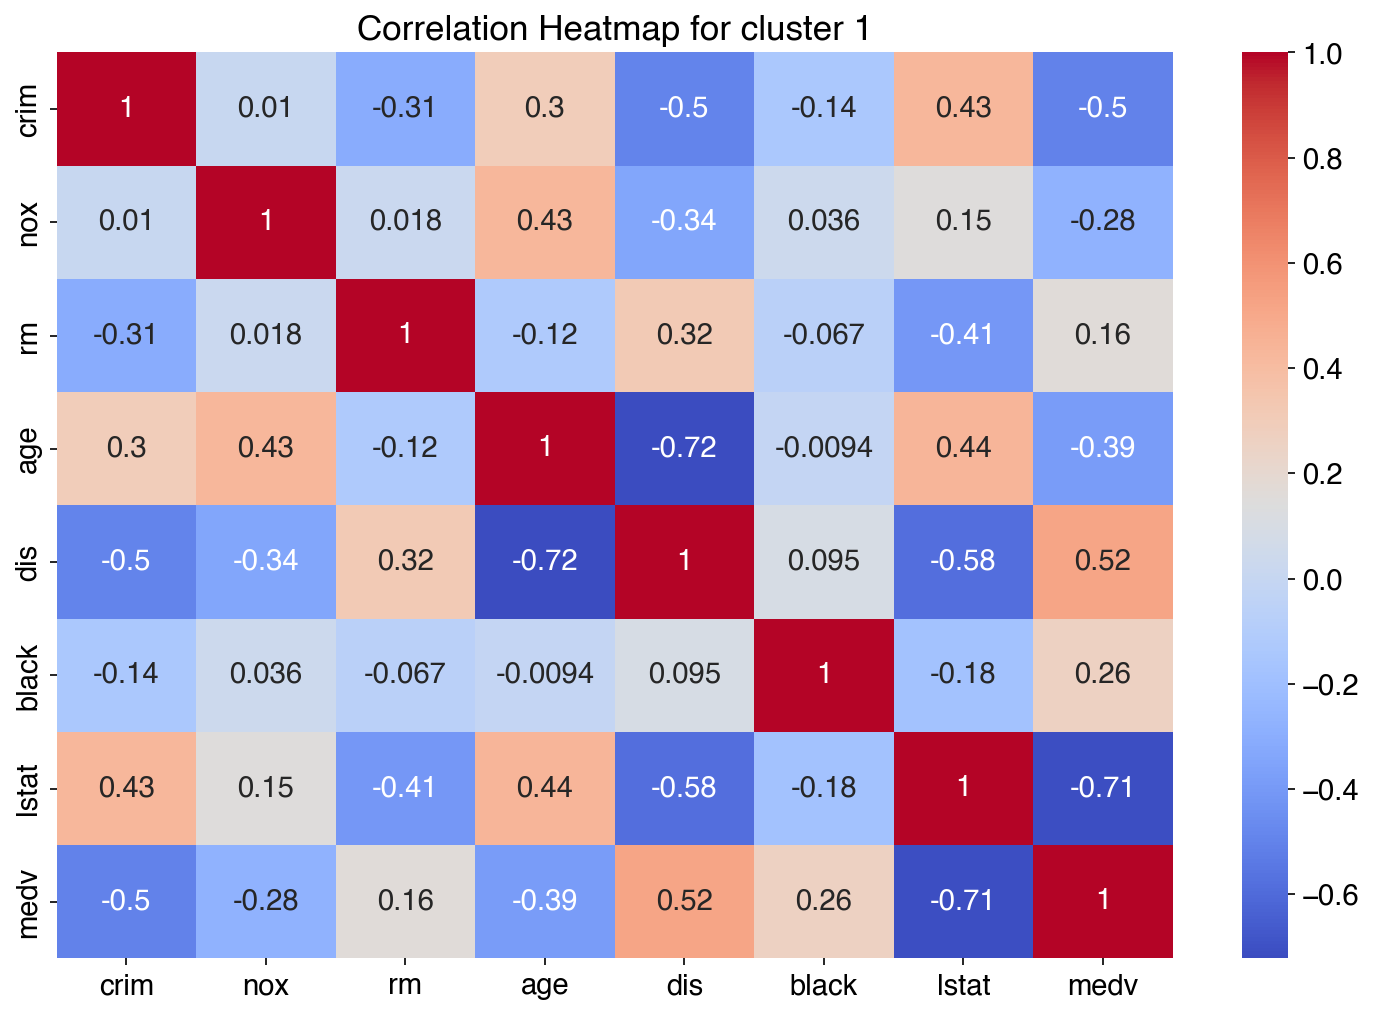

In [49]:
# Evaluate the correlation matrix and visualize it as a heatmap

corr_matrix_1 = df_1_cleaned[num_var1].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_1, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for cluster 1")
plt.savefig('HeatmapCluster1.png')
plt.show()

## Regression

### Model 1.1

In [192]:
# Define the dependent and independent variables
X1_1 = df_1_cleaned.drop(['idx', 'rad', 'medv'], axis=1)
y = df_1_cleaned['medv']

# Add a constant to the independent variables matrix for the linear regression
X1_1 = sm.add_constant(X1_1)

# Convert categorical variables into dummy/indicator variables
X1_1 = pd.get_dummies(X1_1, columns=['chas'], drop_first=True)

In [194]:
# Fit the OLS model
model_1_1 = sm.OLS(y, X1_1)
results_1_1 = model_1_1.fit()

# Compute p-values and VIF values 
p_values_1_1 = results_1_1.pvalues
vif_1_1 = pd.DataFrame()
vif_1_1["variables"] = X1_1.columns
vif_1_1["VIF"] = [variance_inflation_factor(X1_1.values, i) for i in range(X1_1.shape[1])]

# Display the model outcome
results_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     26.07
Date:                Fri, 28 Jul 2023   Prob (F-statistic):           1.18e-22
Time:                        18:59:21   Log-Likelihood:                -323.52
No. Observations:                 125   AIC:                             665.0
Df Residuals:                     116   BIC:                             690.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.0029      6.193      6.943      0.000      30.736      55.270
crim          -0.1420      0.036     -3.924      0.000      -0.214      -0.070
nox          -19.7833      5.705     -3.468      0.001     -31.082      -8.484
rm            -1.3890      0.483     -2.874      0.005      -2.346      -0.432
age            0.0298      0.036      0.828      0.409      -0.041       0.101
dis            0.5230      0.855      0.612      0.542      -1.170       2.216
black          0.0036      0.002      1.698      0.092      -0.001       0.008
lstat         -0.4918      0.062     -7.974      0.000      -0.614      -0.370
chas_1         3.1421      1.668      1.884      0.062      -0.162       6.446
==============================================================================
Omnibus:                       27.424   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.483
Skew:                           0.970   Prob(JB):                     1.80e-11
Kurtosis:                       5.395   Cond. No.                     8.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [203]:
# Display the VIF values

vif_1_1

variables    VIF
0     const 429.29
1      crim   1.47
2       nox   1.40
3        rm   1.34
4       age   2.37
5       dis   3.00
6     black   1.10
7     lstat   1.82
8    chas_1   1.20

### Model 1.2

In [204]:
# Define the independent variables
X1_2 = X1_1.copy()
X1_2.head()

const  crim  nox   rm   age  dis  black  lstat  chas_1
356   1.00  8.98 0.77 6.21 97.40 2.12 377.73  17.60       1
357   1.00  3.85 0.77 6.39 91.00 2.51 391.34  13.27       1
358   1.00  5.20 0.77 6.13 83.40 2.72 395.43  11.48       1
359   1.00  4.26 0.77 6.11 81.30 2.51 390.74  12.67       0
360   1.00  4.54 0.77 6.40 88.00 2.52 374.56   7.79       0

In [205]:
# Drop non significant variables

X1_2.drop(columns=['age', 'dis', 'black', 'chas_1'], inplace=True)
X1_2.head()

const  crim  nox   rm  lstat
356   1.00  8.98 0.77 6.21  17.60
357   1.00  3.85 0.77 6.39  13.27
358   1.00  5.20 0.77 6.13  11.48
359   1.00  4.26 0.77 6.11  12.67
360   1.00  4.54 0.77 6.40   7.79

In [206]:
# Fit OLS model
model_1_2 = sm.OLS(y, X1_2)
results_1_2 = model_1_2.fit()

# Compute p-values and VIF values again
p_values_1_2 = results_1_2.pvalues
vif_1_2 = pd.DataFrame()
vif_1_2["variables"] = X1_2.columns
vif_1_2["VIF"] = [variance_inflation_factor(X1_2.values, i) for i in range(X1_2.shape[1])]

# Display model results
results_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     48.60
Date:                Sat, 29 Jul 2023   Prob (F-statistic):           3.03e-24
Time:                        01:00:18   Log-Likelihood:                -327.63
No. Observations:                 125   AIC:                             665.3
Df Residuals:                     120   BIC:                             679.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6698      4.480     10.194      0.000      36.800      54.540
crim          -0.1523      0.034     -4.461      0.000      -0.220      -0.085
nox          -15.1777      4.981     -3.047      0.003     -25.040      -5.316
rm            -1.3916      0.472     -2.946      0.004      -2.327      -0.456
lstat         -0.5285      0.055     -9.539      0.000      -0.638      -0.419
==============================================================================
Omnibus:                       19.818   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.395
Skew:                           0.774   Prob(JB):                     2.51e-07
Kurtosis:                       4.854   Cond. No.                         503.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
# Output the results of the VIF analysis

vif_1_2.iloc[1:]

variables  VIF
1      crim 1.26
2       nox 1.03
3        rm 1.24
4     lstat 1.42

In [212]:
# Compute standard coefficients

sigma_X_1_2 = X1_2.drop(columns = 'const').std()
sigma_y = y.std()
nonstd_beta_1_2 = results_1_2.params.drop('const')
std_beta_1_2 = nonstd_beta_1_2 * sigma_X_1_2 / sigma_y
std_beta_1_2

crim    -0.28
nox     -0.17
rm      -0.19
lstat   -0.64
dtype: float64

In [214]:
# Evaluate the predictions
pred_1_2 = results_1_2.fittedvalues

# Evaluate the non-standard parameters
results_1.params

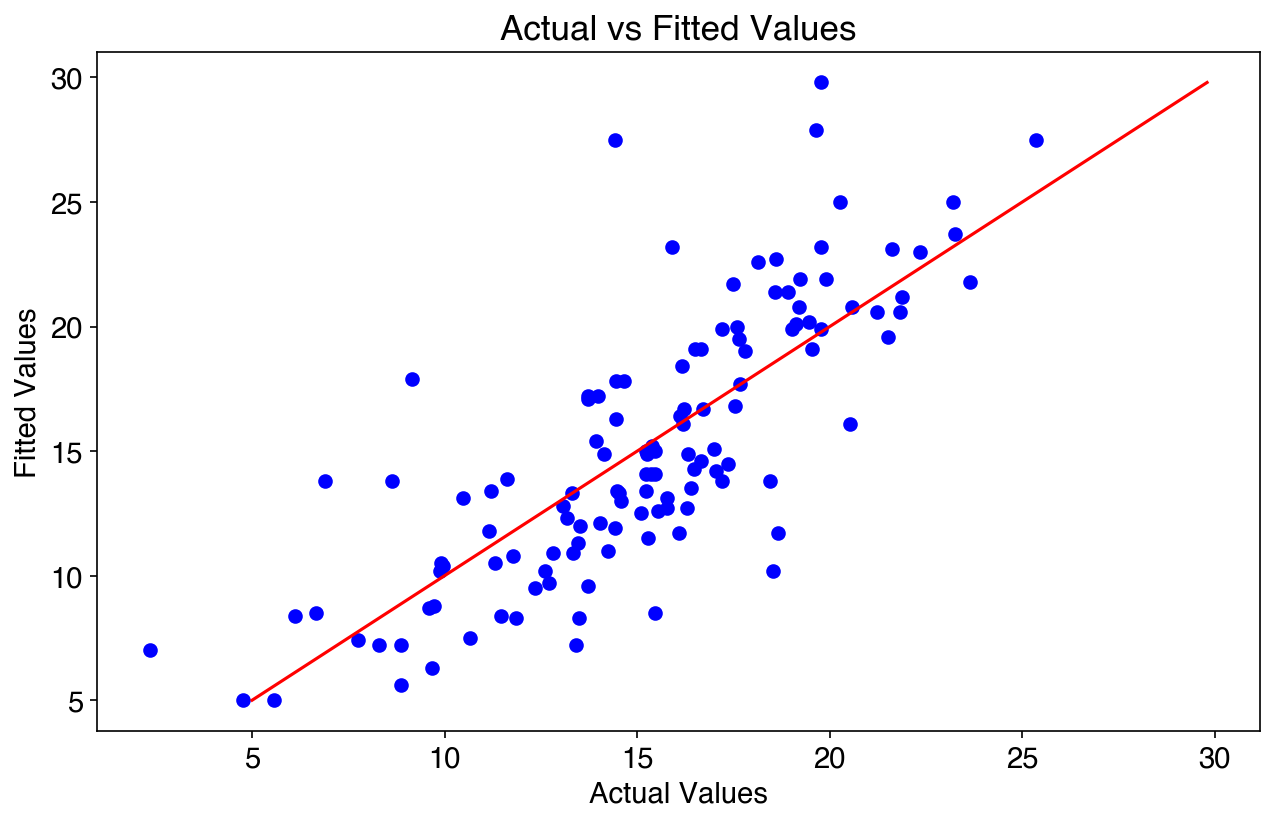

In [222]:
# Visualize regression results

plt.figure(figsize=(10,6))
plt.scatter(pred_1_2, y, color='b')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.title('Actual vs Fitted Values')
plt.savefig('ActualVsFitted_12.png')
plt.show()

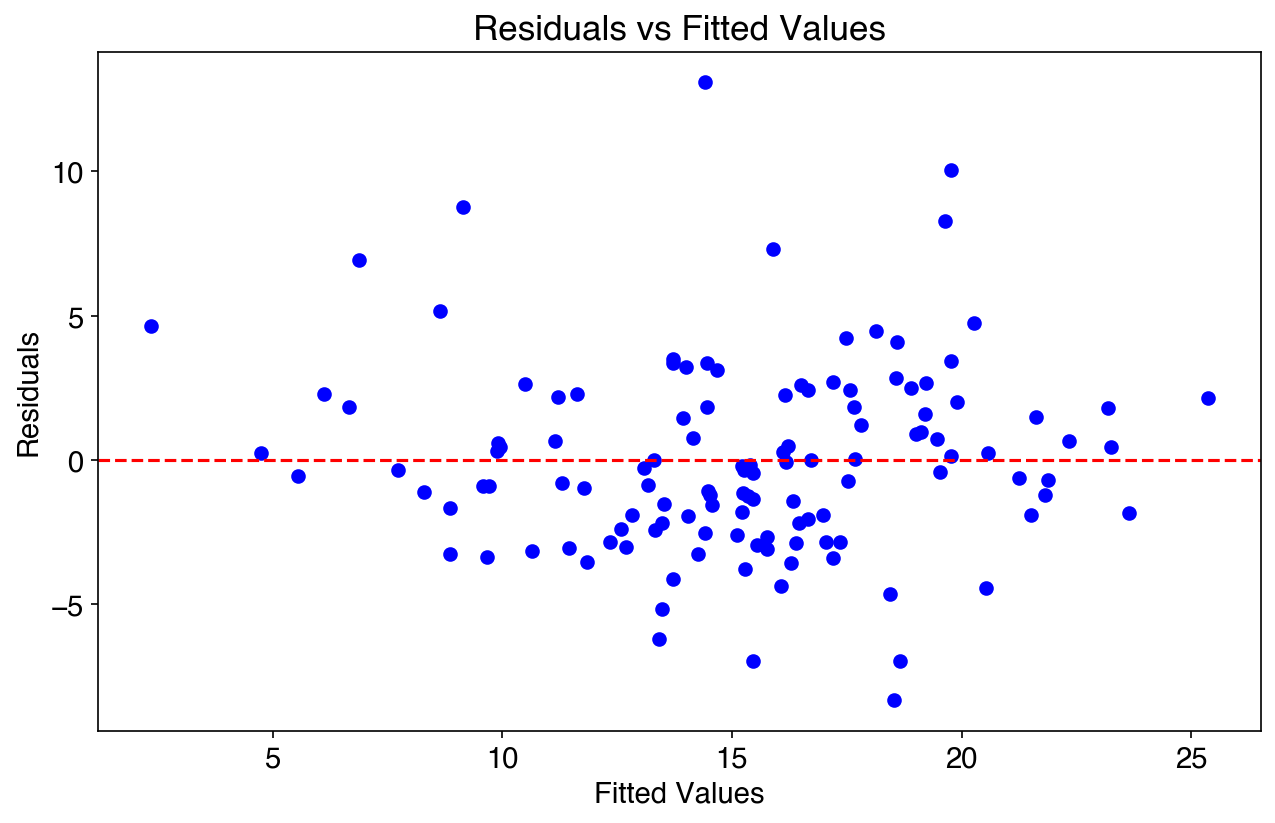

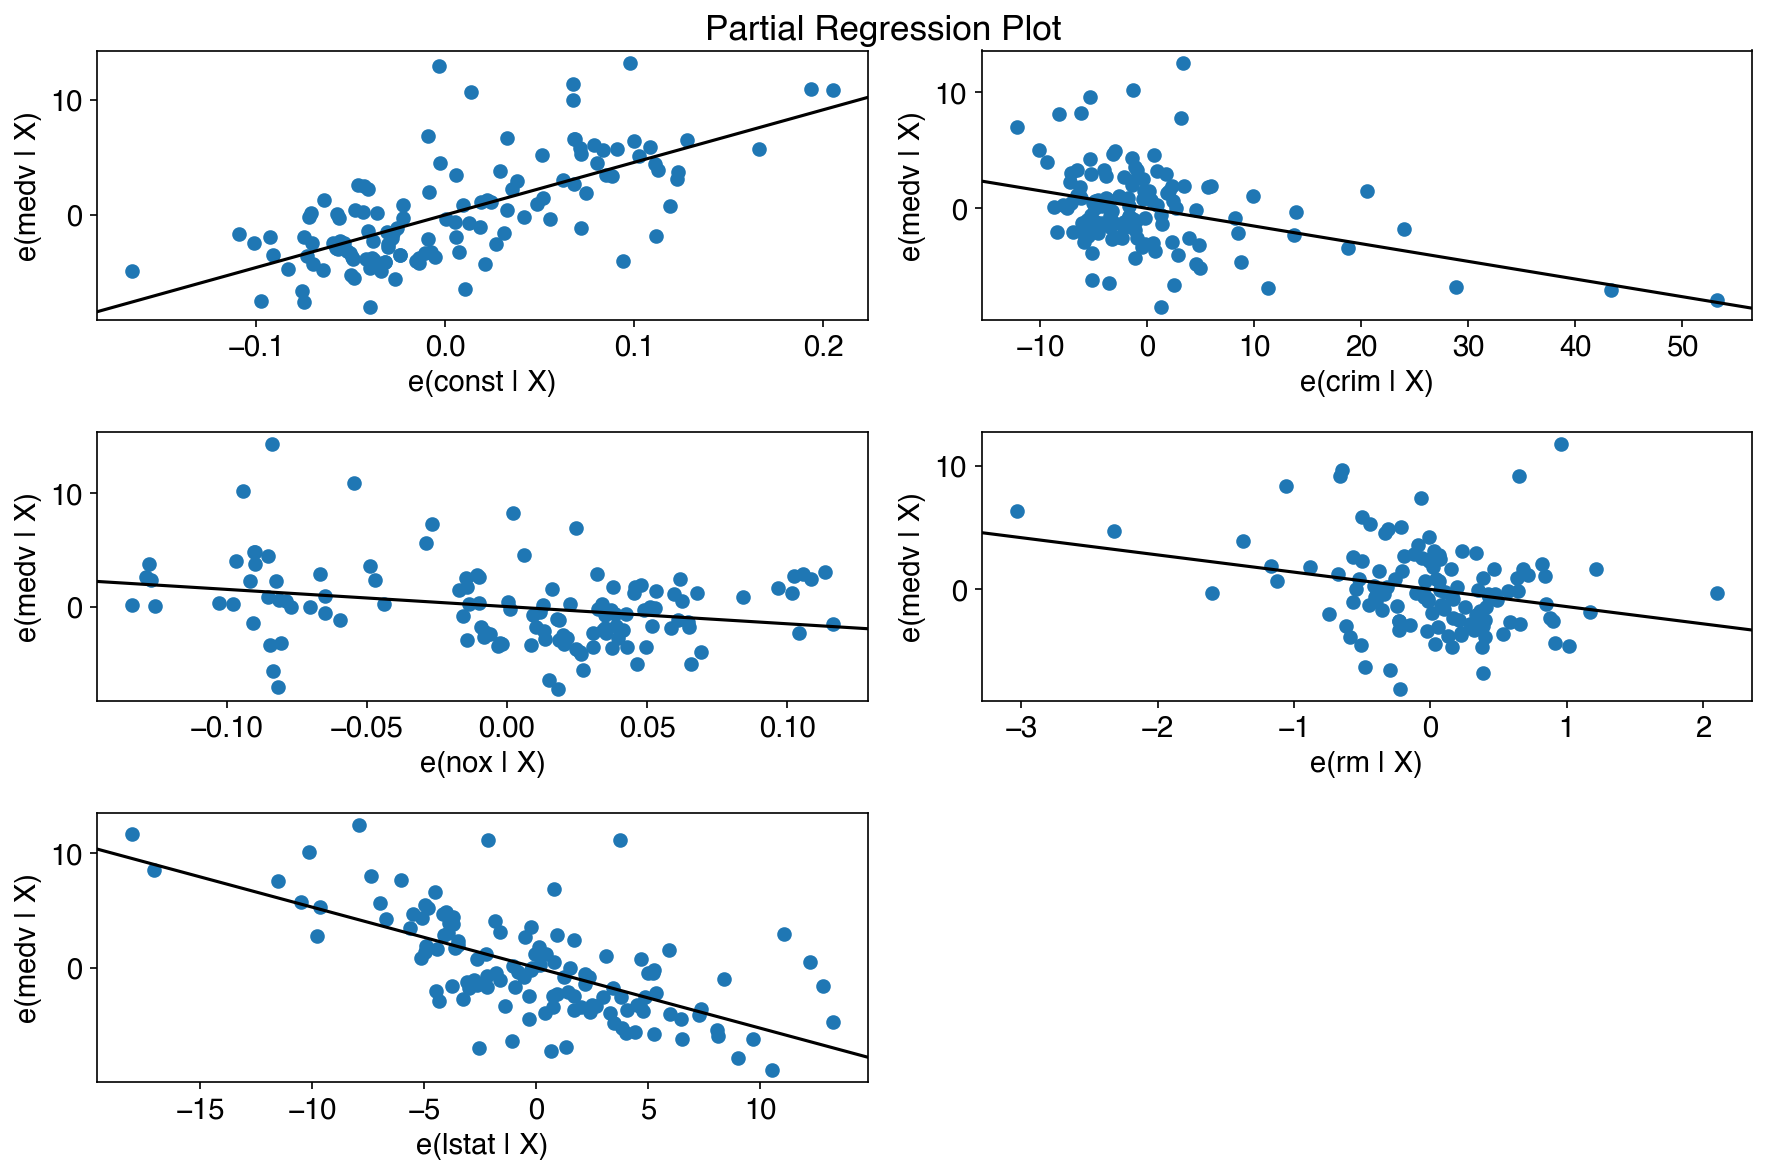

In [223]:
# Residual vs Fitted values plot
plt.figure(figsize=(10,6))
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.scatter(results_1_2.fittedvalues, results_1_2.resid, facecolors='b', edgecolors='b')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig('Residuals_12.png')
plt.show()

# Partial Regression Plots for each regressor
fig = plt.figure(figsize=(12,8))
sm.graphics.plot_partregress_grid(results_1_2, fig=fig)
plt.savefig('PartialRegression_12.png')
plt.show()

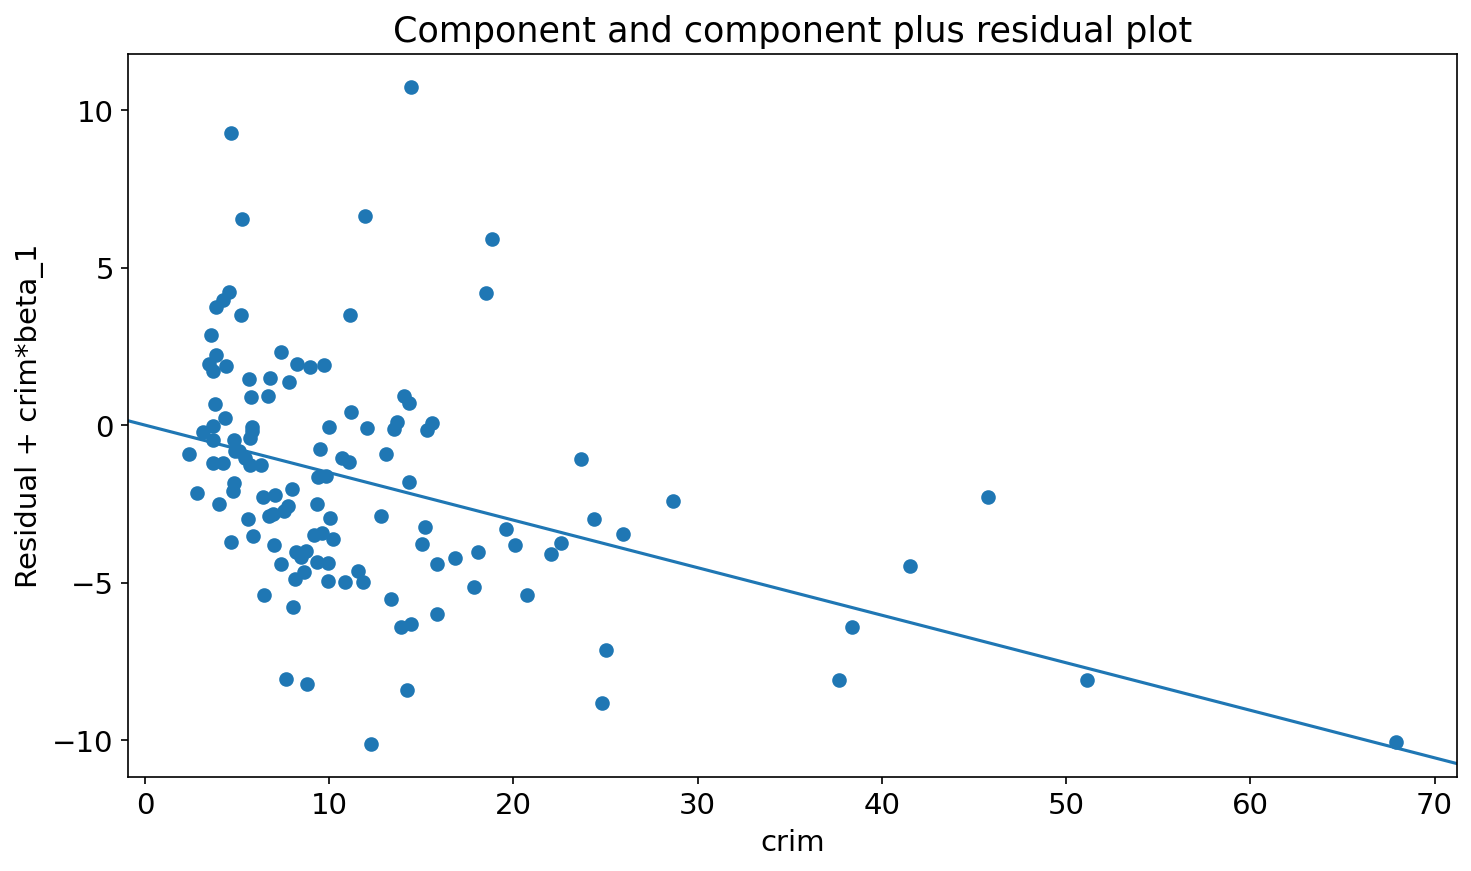

In [357]:
fig = sm.graphics.plot_ccpr(results_1, "crim")
fig.tight_layout(pad=1.0)

## Cluster 2

In [51]:
# Shape of cluster 2 dataframe

df_2.shape

(363, 15)

In [52]:
# Cluster 2 does not contain rad = high

df_2[df_2.rad == 'low'].shape[0] + df_2[df_2.rad == 'medium'].shape[0]

363

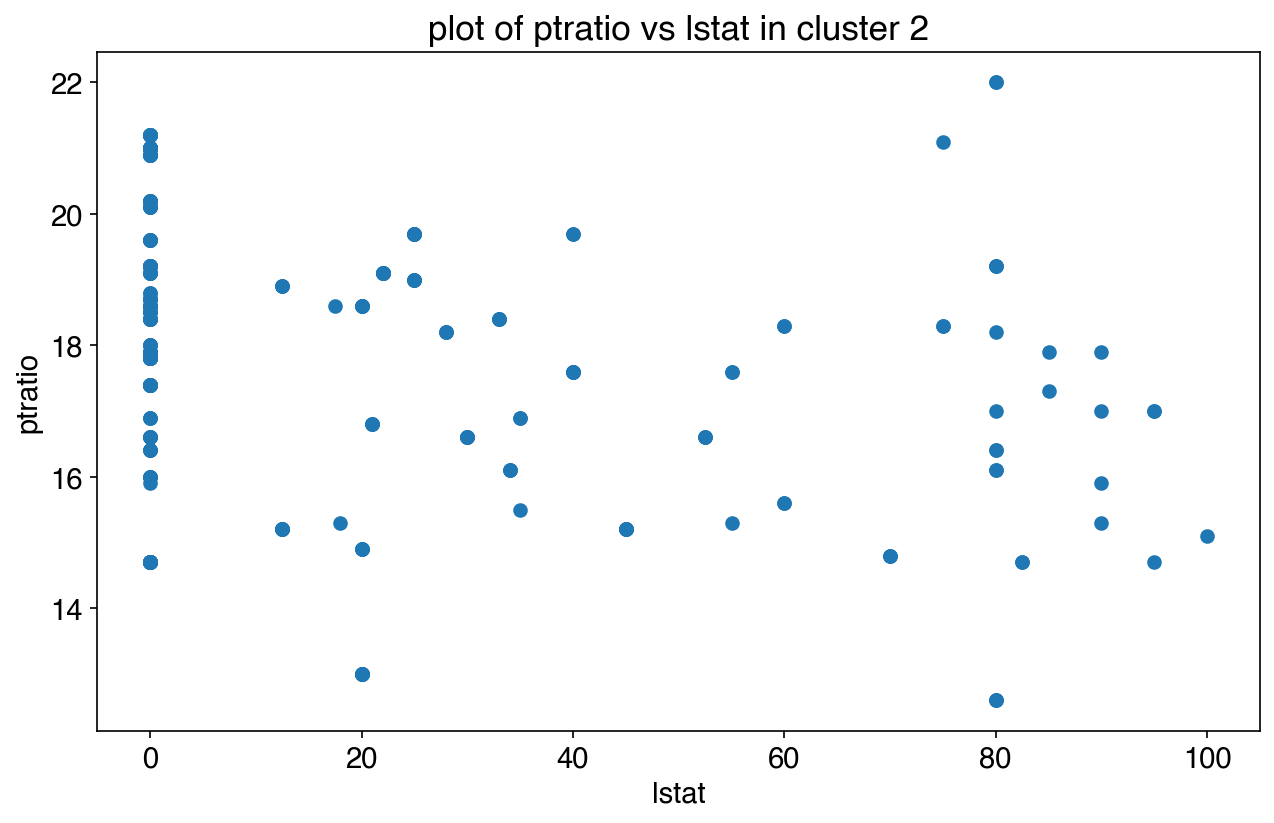

In [48]:
# The points idx = 366 corresponds to the leftmost point in the following plot

plt.scatter(df_2['zn'], df_2['ptratio'])
plt.title('plot of ptratio vs lstat in cluster 2')
plt.ylabel('ptratio')
plt.xlabel('lstat')
#plt.savefig('CrimVsLstat.png')
plt.show()

hide_toggle()

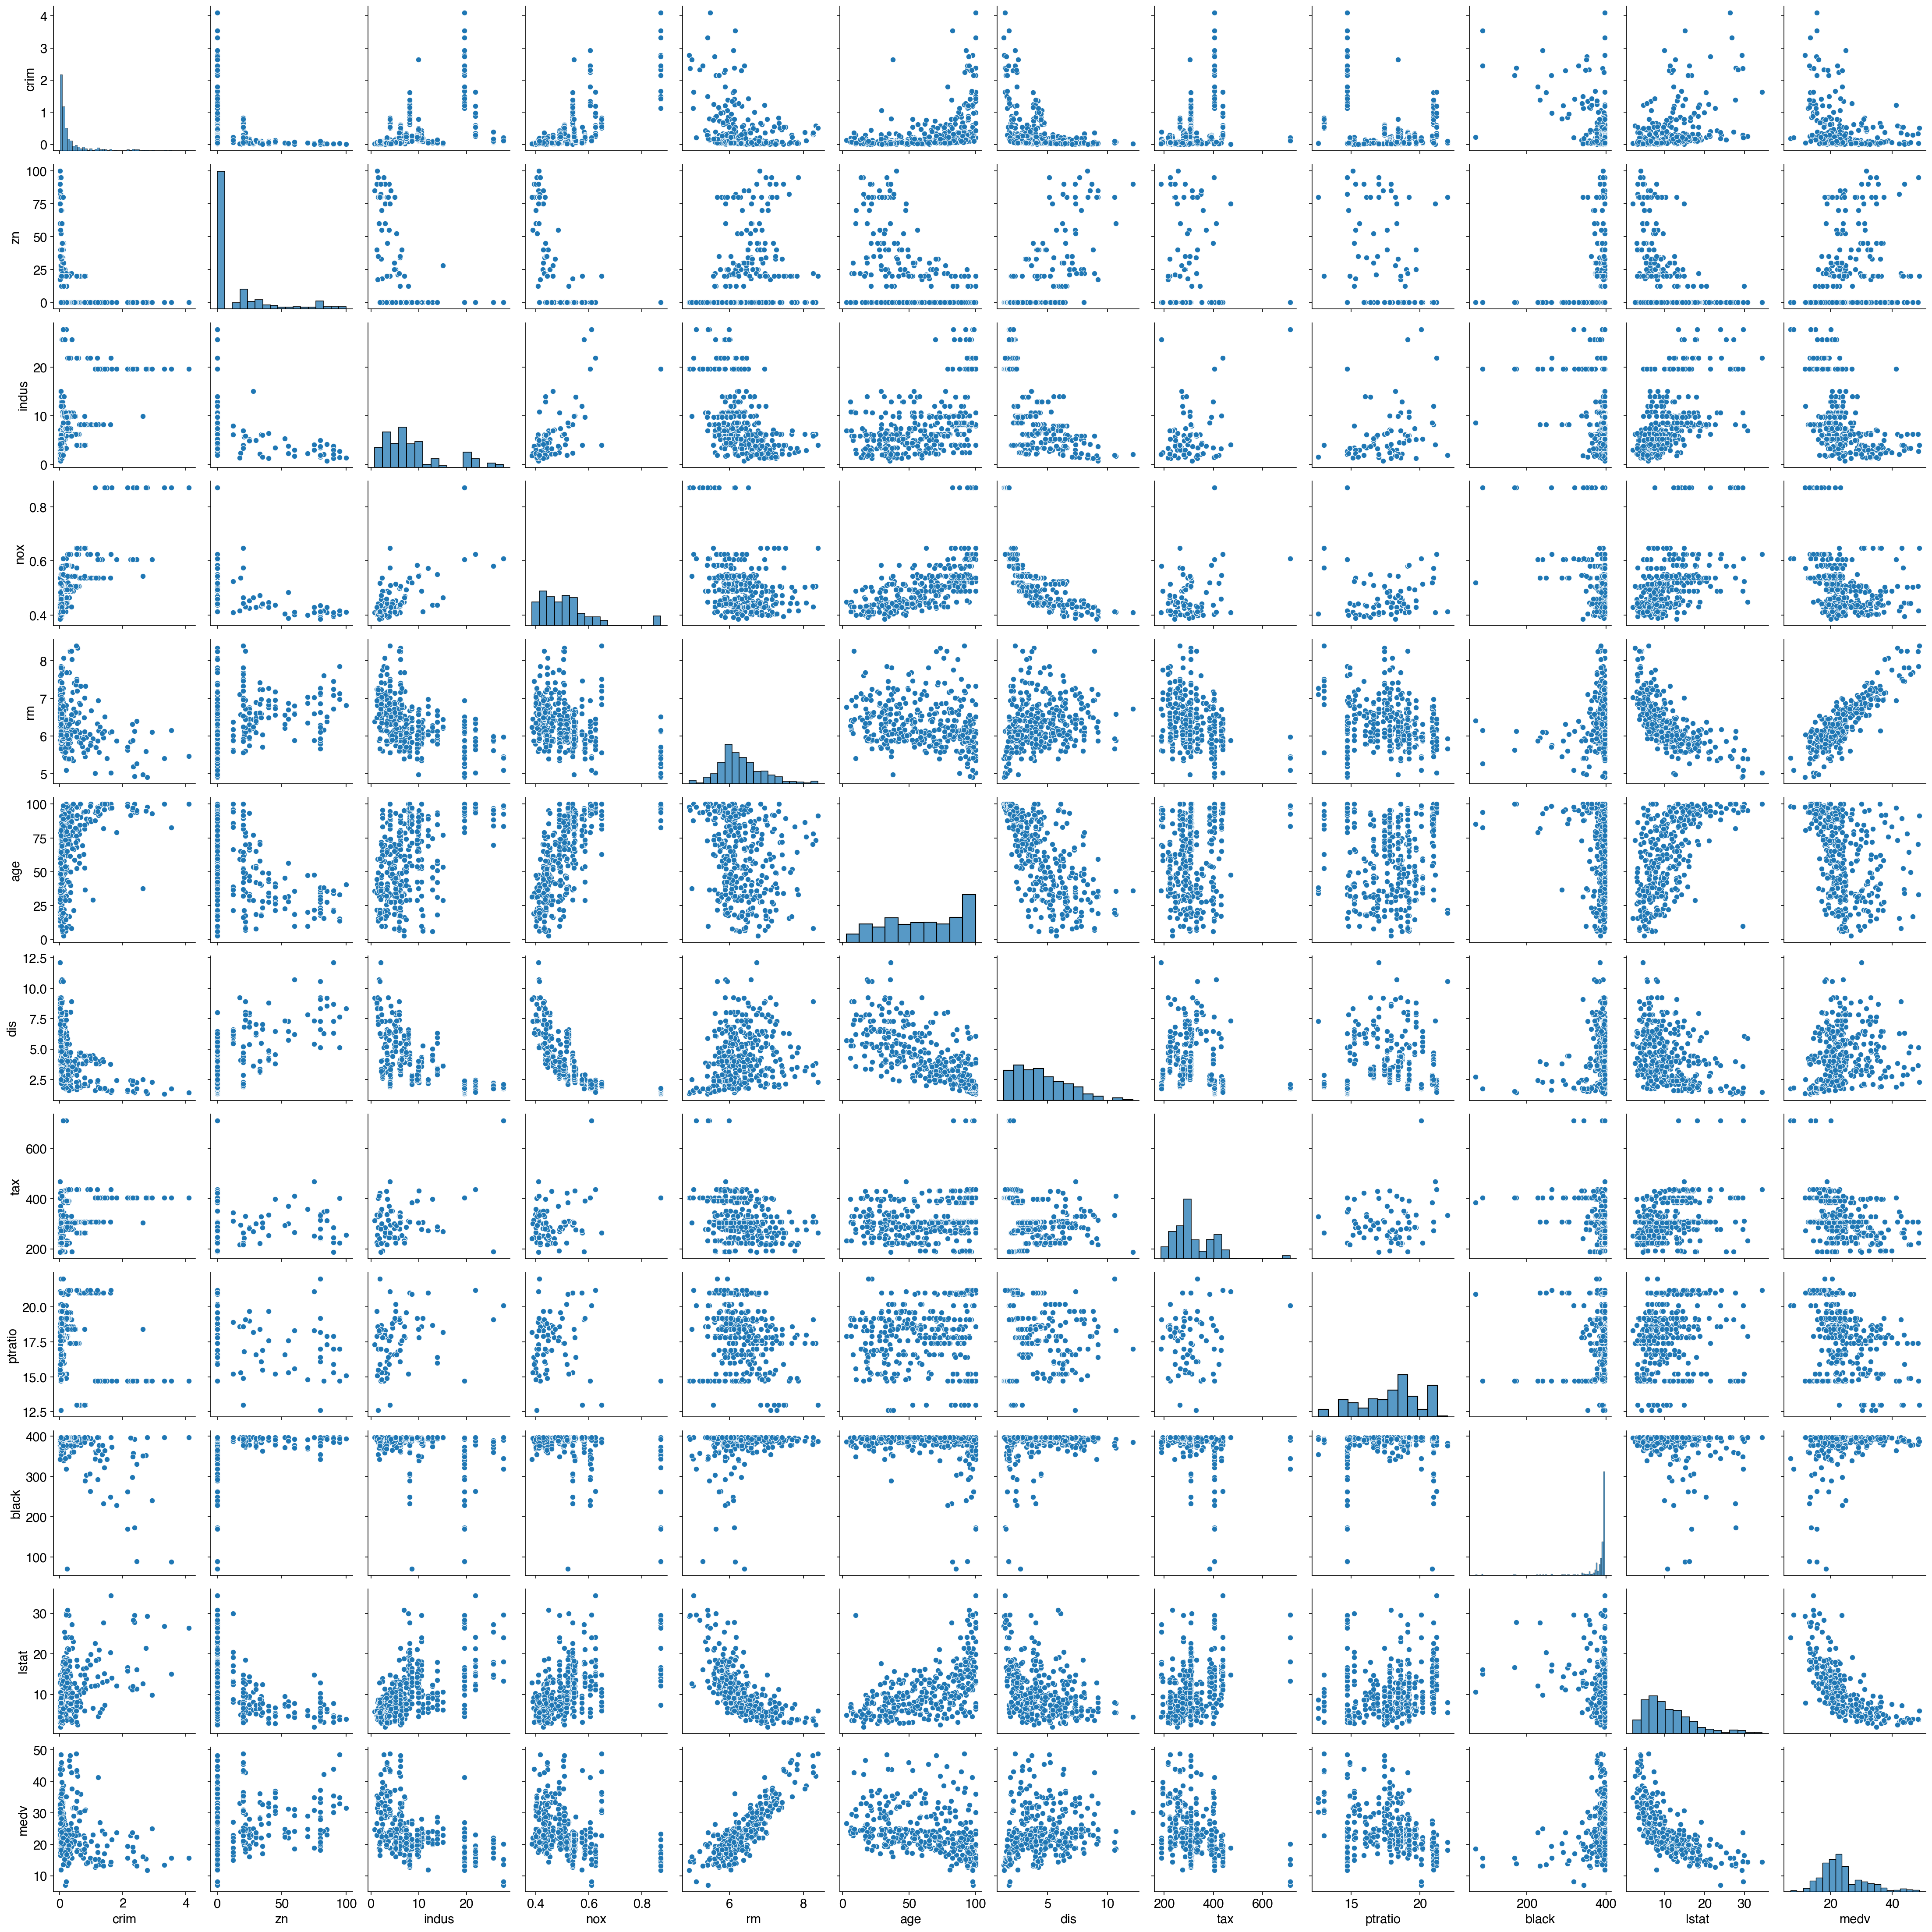

In [242]:
# Produce pairplot for cluster 2

sns.pairplot(df_2[num_var])
plt.savefig('ScatterCluster2.png')

In [53]:
# Compute Mahalanobis distances

df_out = df_2

mean_vector = df_out[num_var].mean()
inv_cov_matrix = np.linalg.inv(df_out[num_var].cov())
df_mahal = df_out.copy()

# Calculate the Mahalanobis distance for each point
df_mahal['Mahalanobis'] = df_mahal[num_var].apply(lambda row: distance.mahalanobis(row, mean_vector, inv_cov_matrix), axis=1)

# Calculate the threshold for the Mahalanobis distance
threshold = np.sqrt(chi2.ppf((1-0.01), df=df_mahal.shape[1]))  # 99% quantile of Chi-squared distribution

# Identify the outliers
outliers = df_mahal[df_mahal['Mahalanobis'] > threshold]

# Calculate the percentage of data points that were removed
percentage_removed = len(outliers) / len(df_mahal) * 100

# Show the percentage of data points that were removed
print(f"Percentage of potential outliers: {percentage_removed:.2f}%")
print(f"Mahalanobis threshold is: {threshold:.2f}")

Percentage of potential outliers: 5.23%
Mahalanobis threshold is: 5.66


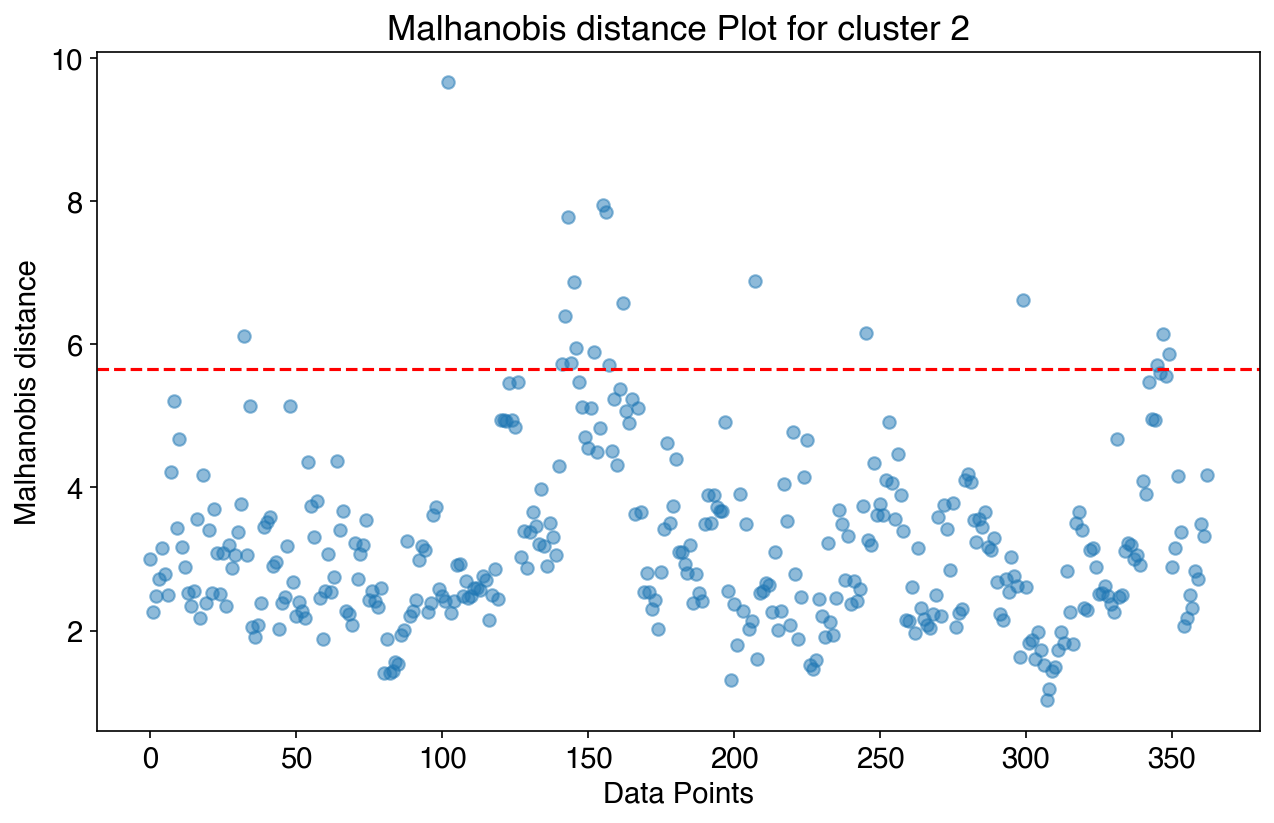

In [54]:
# Plot Mahalanobis distances

plt.scatter(range(len(df_mahal)), df_mahal.Mahalanobis, alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Data Points')
plt.ylabel('Malhanobis distance')
plt.title('Malhanobis distance Plot for cluster 2')
plt.savefig('Malahanobis2.png')
plt.show()

In [261]:
# List the potential outliers according to the Mahalanobis distance method

outliers

idx  crim    zn  indus  chas  nox   rm    age  dis     rad  tax  ptratio  \
32    33  1.39  0.00   8.14     0 0.54 5.95  82.00 3.99     low  307    21.00   
102  103  0.23  0.00   8.56     0 0.52 6.41  85.40 2.71  medium  384    20.90   
141  142  1.63  0.00  21.89     0 0.62 5.02 100.00 1.44     low  437    21.20   
142  143  3.32  0.00  19.58     1 0.87 5.40 100.00 1.32  medium  403    14.70   
143  144  4.10  0.00  19.58     0 0.87 5.47 100.00 1.41  medium  403    14.70   
144  145  2.78  0.00  19.58     0 0.87 4.90  97.80 1.35  medium  403    14.70   
145  146  2.38  0.00  19.58     0 0.87 6.13 100.00 1.42  medium  403    14.70   
146  147  2.16  0.00  19.58     0 0.87 5.63 100.00 1.52  medium  403    14.70   
152  153  1.13  0.00  19.58     1 0.87 5.01  88.00 1.61  medium  403    14.70   
155  156  3.54  0.00  19.58     1 0.87 6.15  82.60 1.75  medium  403    14.70   
156  157  2.45  0.00  19.58     0 0.87 5.27  94.00 1.74  medium  403    14.70   
157  158  1.22  0.00  19.58     0 0.60 6.94  97.40 1.88  medium  403    14.70   
165  166  2.92  0.00  19.58     0 0.60 6.10  93.00 2.28  medium  403    14.70   
214  215  0.29  0.00  10.59     0 0.49 5.41   9.80 3.59     low  277    18.60   
253  254  0.37 22.00   5.86     0 0.43 8.26   8.40 8.91  medium  330    19.10   
310  311  2.64  0.00   9.90     0 0.54 4.97  37.80 2.52     low  304    18.40   
488  489  0.15  0.00  27.74     0 0.61 5.45  92.70 1.82     low  711    20.10   
490  491  0.21  0.00  27.74     0 0.61 5.09  98.00 1.82     low  711    20.10   
492  493  0.11  0.00  27.74     0 0.61 5.98  83.50 2.11     low  711    20.10   

     black  lstat  medv  Mahalanobis  
32  232.60  27.71 13.20         6.12  
102  70.80  10.63 18.60         9.66  
141 396.90  34.41 14.40         5.73  
142 396.90  26.82 13.40         6.39  
143 396.90  26.42 15.60         7.78  
144 396.90  29.29 11.80         5.73  
145 172.91  27.80 13.80         6.86  
146 169.27  16.65 15.60         5.94  
152 343.28  12.12 15.30         5.90  
155  88.01  15.02 15.60         7.94  
156  88.63  16.14 13.10         7.84  
157 363.43   4.59 41.30         5.70  
165 240.16   9.81 25.00         6.58  
214 348.93  29.55 23.70         6.88  
253 396.90   3.54 42.80         6.15  
310 350.45  12.64 16.10         6.62  
488 395.09  18.06 15.20         5.72  
490 318.43  29.68  8.10         6.15  
492 396.90  13.35 20.10         5.86

In [263]:
# Data to remove: idx = 103, 215

index_out = [102, 214]

In [264]:
# Define cleaned dataset

df_2_cleaned = df_2.drop(index = index_out)

In [268]:
# The new shape of df_2 after outlier removal is

df_2_cleaned.shape

(361, 15)

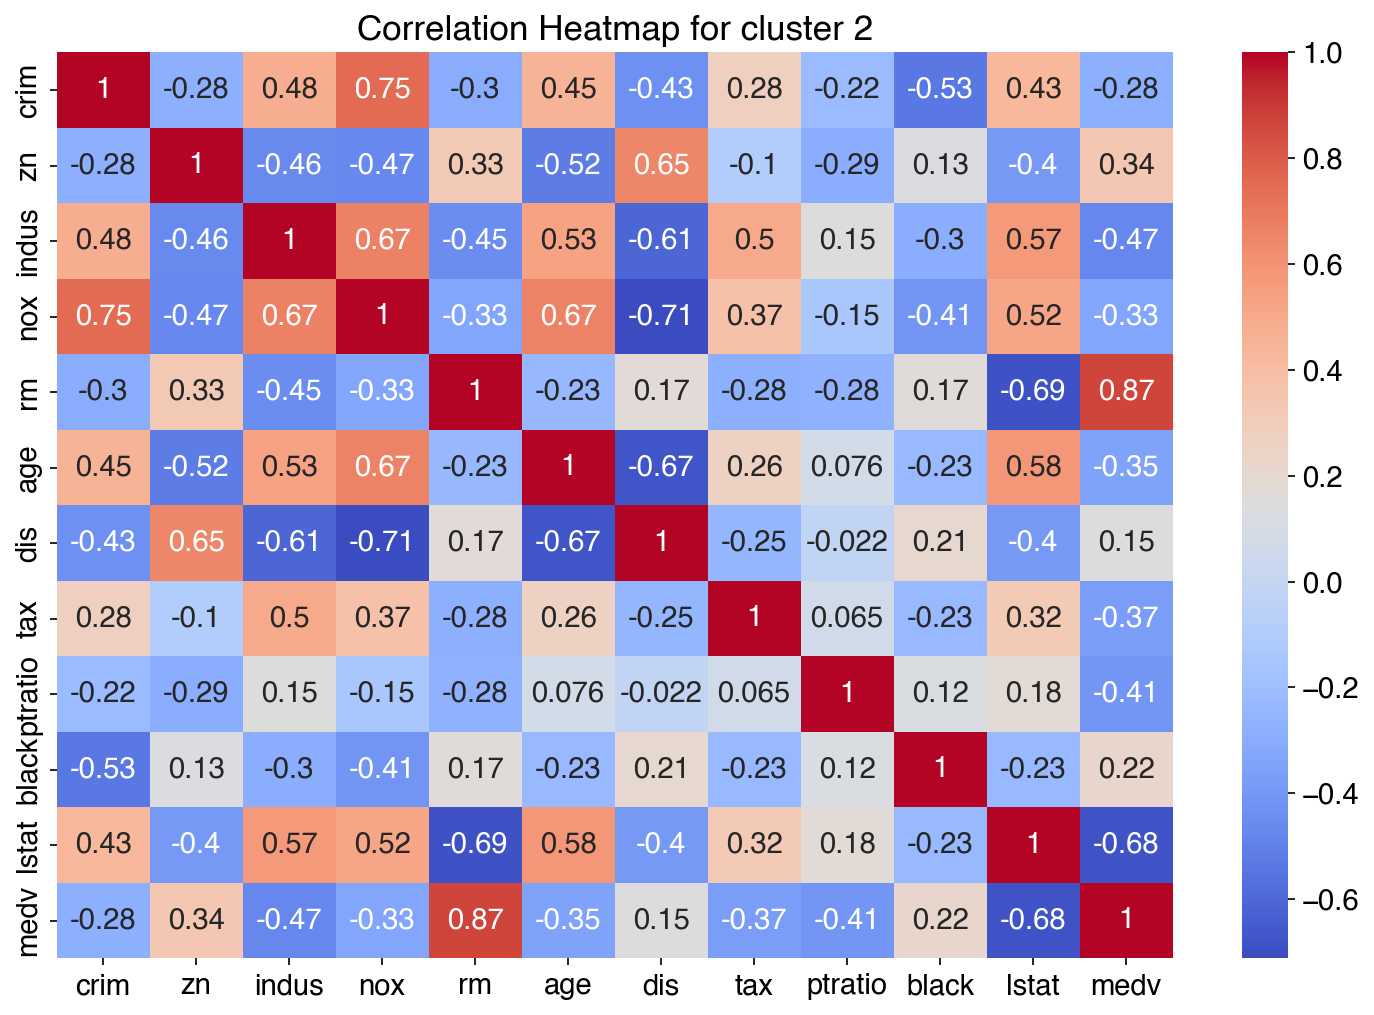

In [269]:
# Compute correlation matrix

corr_matrix_2 = df_2[num_var].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_2, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for cluster 2")
plt.savefig('HeatmapCluster2.png')
plt.show()

# Regression

### Model 2.1

In [272]:
# Define the dependent and independent variables
X2_1 = df_2_cleaned.drop(['idx', 'medv'], axis=1)
y = df_2_cleaned['medv']

# Add a constant to the independent variables matrix for the linear regression
X2_1 = sm.add_constant(X2_1)

# Convert categorical variables into dummy/indicator variables
X2_1 = pd.get_dummies(X2_1, columns=['chas', 'rad'], drop_first=True)
X2_1.head()

const  crim    zn  indus  nox   rm   age  dis  tax  ptratio  black  lstat  \
0   1.00  0.01 18.00   2.31 0.54 6.58 65.20 4.09  296    15.30 396.90   4.98   
1   1.00  0.03  0.00   7.07 0.47 6.42 78.90 4.97  242    17.80 396.90   9.14   
2   1.00  0.03  0.00   7.07 0.47 7.18 61.10 4.97  242    17.80 392.83   4.03   
3   1.00  0.03  0.00   2.18 0.46 7.00 45.80 6.06  222    18.70 394.63   2.94   
4   1.00  0.07  0.00   2.18 0.46 7.15 54.20 6.06  222    18.70 396.90   5.33   

   chas_1  rad_medium  rad_high  
0       0           0         0  
1       0           0         0  
2       0           0         0  
3       0           0         0  
4       0           0         0

In [273]:
# Recall that radd = 'high' is not present in cluster 2

X2_1.drop(columns='rad_high', inplace = True)

In [275]:
# Fit the OLS model
model_2_1 = sm.OLS(y, X2_1)
results_2_1 = model_2_1.fit()

# Compute p-values and VIF values
p_values_2_1 = results_2_1.pvalues
vif_2_1 = pd.DataFrame()
vif_2_1["variables"] = X2_1.columns
vif_2_1["VIF"] = [variance_inflation_factor(X2_1.values, i) for i in range(X2_1.shape[1])]

# Display regression results
results_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     149.3
Date:                Sat, 29 Jul 2023   Prob (F-statistic):          2.37e-133
Time:                        03:24:55   Log-Likelihood:                -888.73
No. Observations:                 361   AIC:                             1805.
Df Residuals:                     347   BIC:                             1860.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.0186      4.600     -2.395      0.017     -20.066      -1.971
crim           0.5199      0.422      1.232      0.219      -0.310       1.350
zn             0.0167      0.009      1.855      0.064      -0.001       0.034
indus         -0.0194      0.041     -0.477      0.633      -0.100       0.061
nox           -5.3774      3.401     -1.581      0.115     -12.067       1.312
rm             8.3230      0.389     21.414      0.000       7.559       9.087
age           -0.0504      0.009     -5.452      0.000      -0.069      -0.032
dis           -0.8658      0.134     -6.482      0.000      -1.128      -0.603
tax           -0.0101      0.002     -4.391      0.000      -0.015      -0.006
ptratio       -0.5598      0.090     -6.223      0.000      -0.737      -0.383
black          0.0143      0.005      2.736      0.007       0.004       0.025
lstat         -0.0723      0.047     -1.532      0.126      -0.165       0.021
chas_1         0.6549      0.629      1.041      0.299      -0.582       1.892
rad_medium     0.4794      0.354      1.355      0.176      -0.216       1.175
==============================================================================
Omnibus:                       25.811   Durbin-Watson:                   1.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.516
Skew:                           0.548   Prob(JB):                     3.20e-08
Kurtosis:                       4.046   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [276]:
# Display results of the VIF analysis

vif_2_1

variables    VIF
0        const 912.01
1         crim   2.93
2           zn   2.26
3        indus   2.85
4          nox   5.15
5           rm   2.41
6          age   2.93
7          dis   3.42
8          tax   1.53
9      ptratio   1.63
10       black   1.58
11       lstat   3.27
12      chas_1   1.06
13  rad_medium   1.35

### Model 2.2

In [277]:
# Define the dependent and independent variables
X2_2 = X2_1.drop(['const', 'crim', 'zn', 'indus', 'nox', 'lstat', 'chas_1', 'rad_medium'], axis=1)

# Add a constant to the independent variables matrix for the linear regression
X2_2 = sm.add_constant(X2_2)

In [279]:
# Fit the OLS model 
model_2_2 = sm.OLS(y, X2_2)
results_2_2 = model_2_2.fit()

# Compute p-values and VIF values 
p_values_2_2 = results_2_2.pvalues
vif_2_2 = pd.DataFrame()
vif_2_2["variables"] = X2_2.columns
vif_2_2["VIF"] = [variance_inflation_factor(X2_2.values, i) for i in range(X2_2.shape[1])]

# Display regression results
results_2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     317.7
Date:                Sat, 29 Jul 2023   Prob (F-statistic):          3.56e-139
Time:                        03:33:02   Log-Likelihood:                -894.60
No. Observations:                 361   AIC:                             1803.
Df Residuals:                     354   BIC:                             1830.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.6358      3.060     -5.436      0.000     -22.654     -10.617
rm             8.9476      0.281     31.894      0.000       8.396       9.499
age           -0.0620      0.008     -8.178      0.000      -0.077      -0.047
dis           -0.6674      0.099     -6.708      0.000      -0.863      -0.472
tax           -0.0105      0.002     -5.155      0.000      -0.015      -0.006
ptratio       -0.6379      0.076     -8.381      0.000      -0.788      -0.488
black          0.0144      0.005      3.164      0.002       0.005       0.023
==============================================================================
Omnibus:                       23.698   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.610
Skew:                           0.488   Prob(JB):                     5.03e-08
Kurtosis:                       4.132   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [471]:
# Display the outcome of the VIF analysis

vif_2_2

variables    VIF
0     const 466.38
1        rm   1.23
2       age   1.91
3       dis   1.84
4       tax   1.16
5   ptratio   1.12
6     black   1.11

In [280]:
# Compute standard coefficients

sigma_X_2_2 = X2_2.drop(columns = 'const').std()
sigma_y = y.std()
nonstd_beta_2_2 = results_2_2.params.drop('const')
std_beta_2_2 = nonstd_beta_2_2 * sigma_X_2_2 / sigma_y
std_beta_2_2

rm         0.75
age       -0.24
dis       -0.19
tax       -0.12
ptratio   -0.19
black      0.07
dtype: float64

In [283]:
# Evaluate the predictions

pred_2_2 = results_2_2.fittedvalues

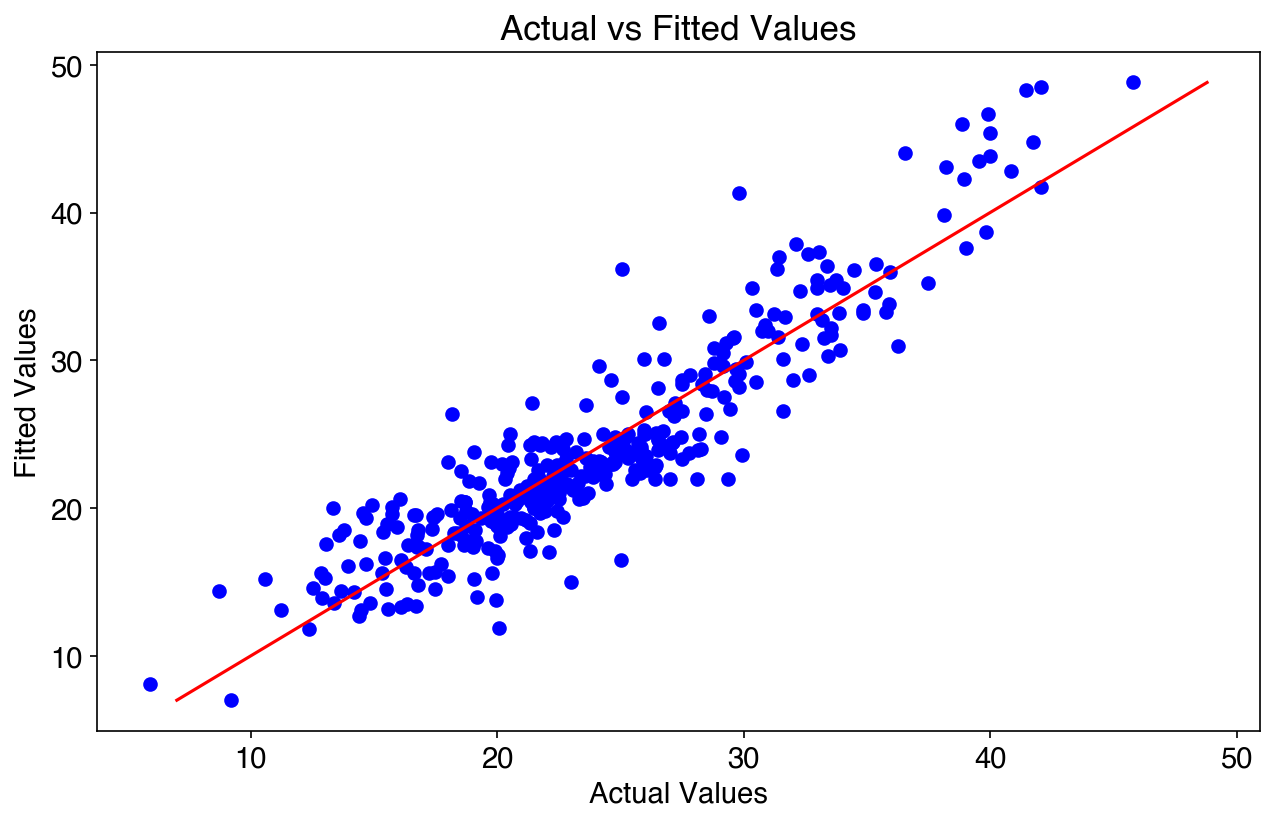

In [287]:
# Visualize regression results

plt.figure(figsize=(10,6))
plt.scatter(pred_2_2, y, color='b')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.title('Actual vs Fitted Values')
plt.savefig('ActualVsFitted_22.png')
plt.show()

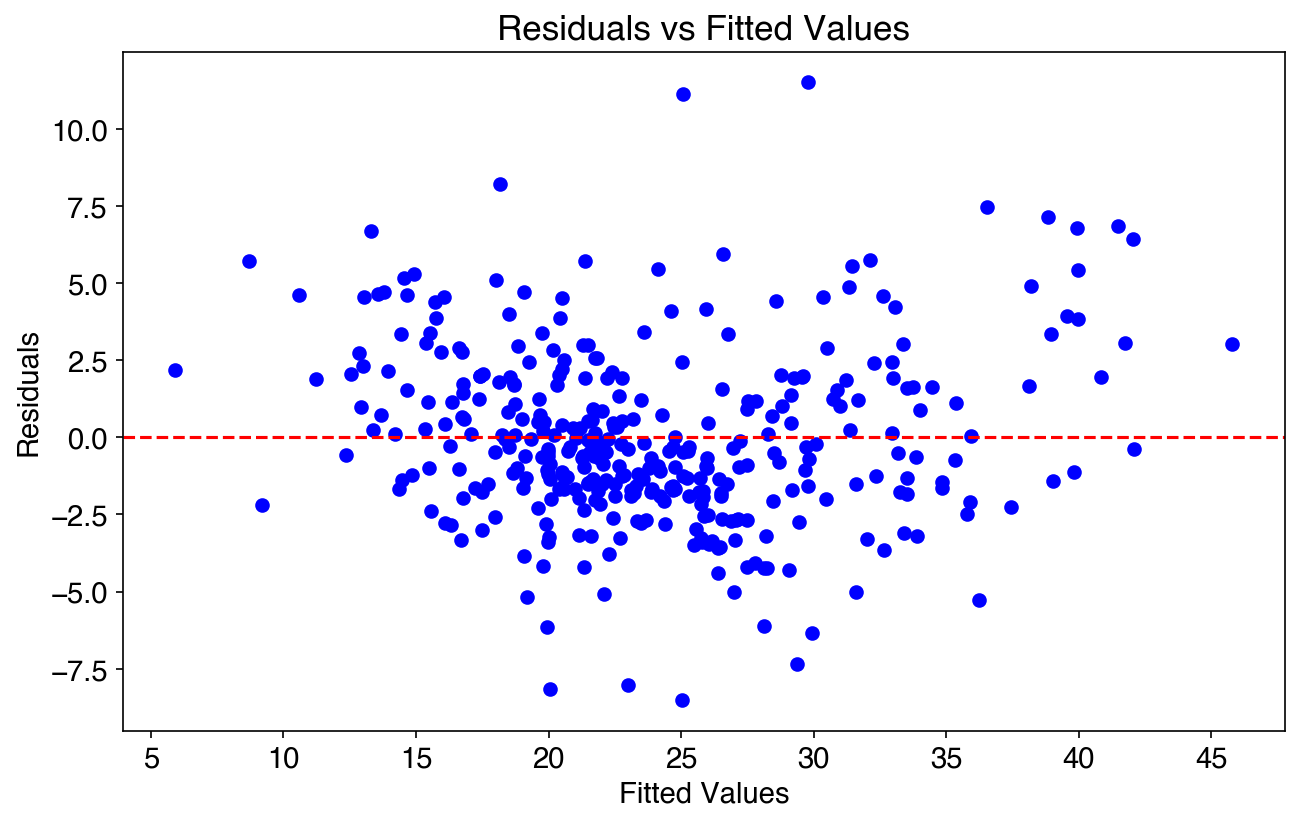

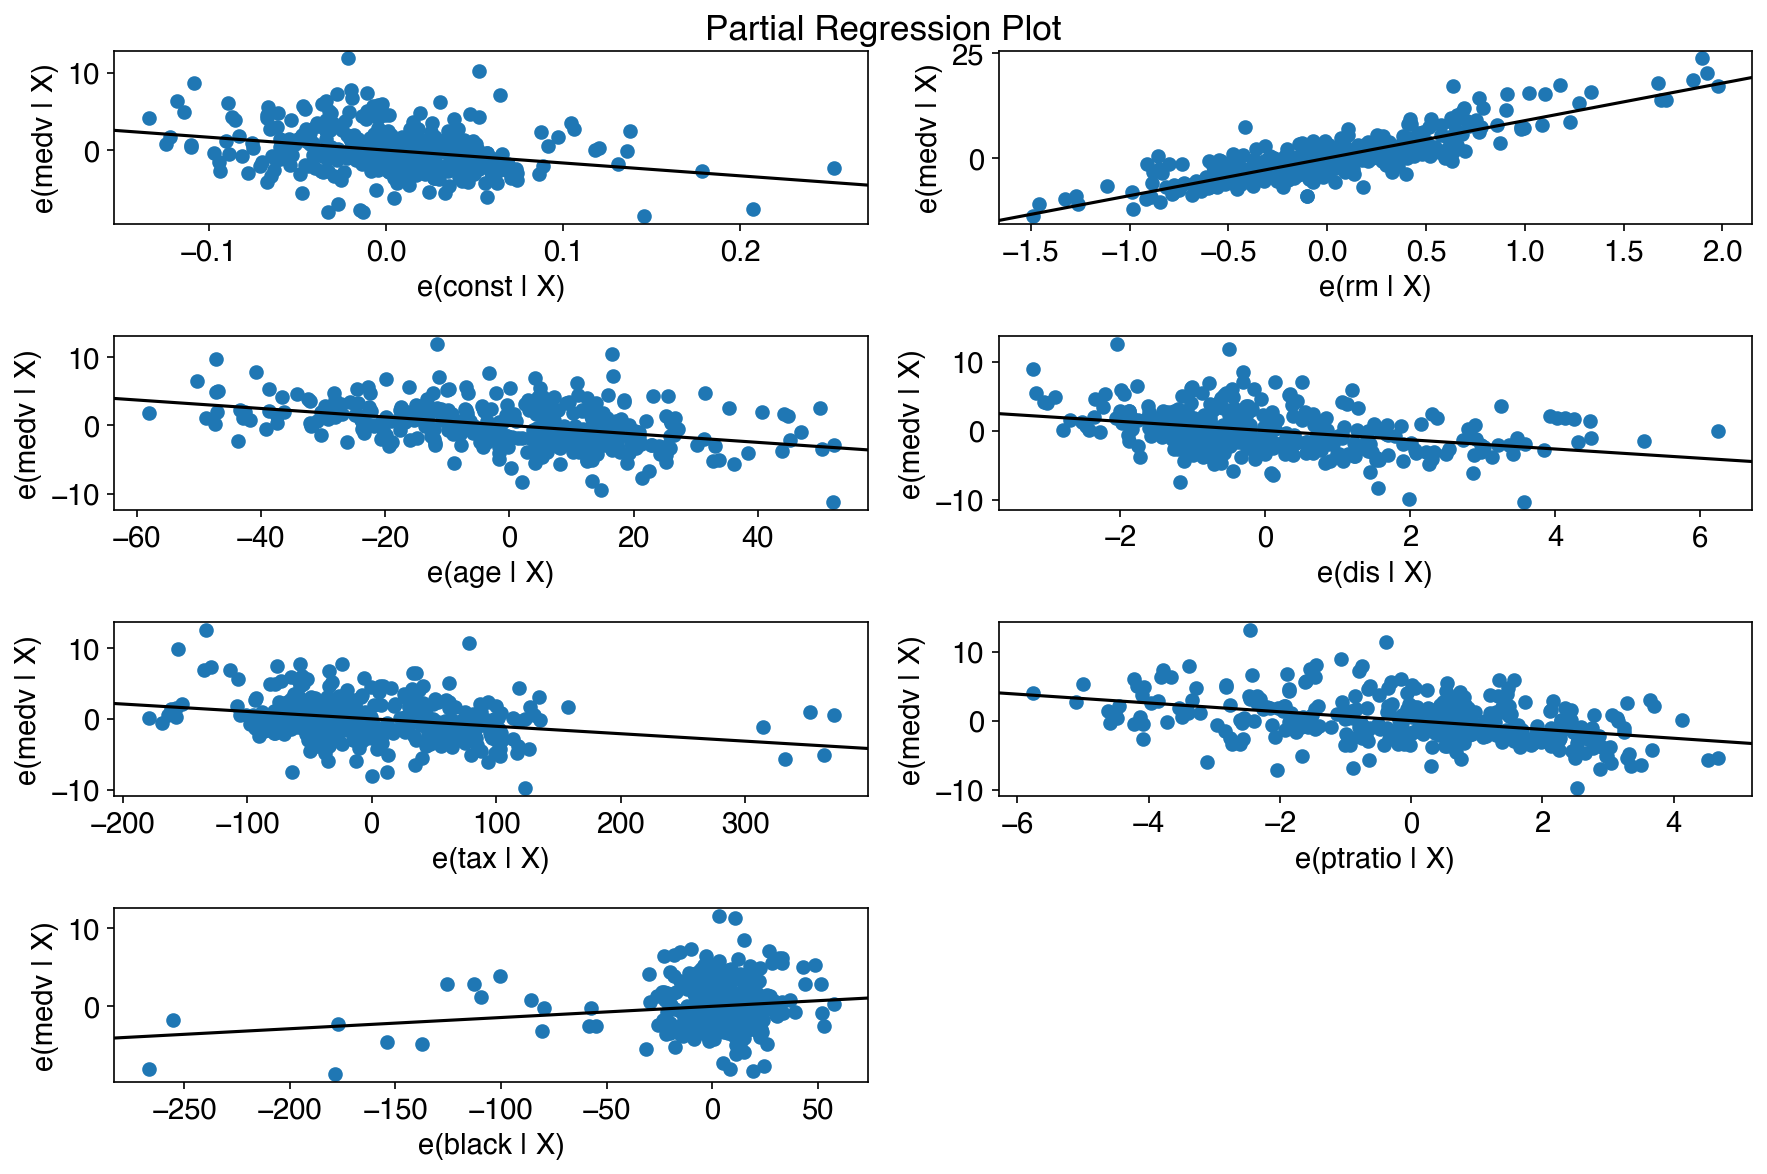

In [286]:
# Residual vs Fitted values plot
plt.figure(figsize=(10,6))
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.scatter(results_2_2.fittedvalues, results_2_2.resid, facecolors='b', edgecolors='b')
plt.axhline(y=0, color='red', linestyle='--')
plt.savefig('Residuals_22.png')
plt.show()

# Partial Regression Plots for each regressor
fig = plt.figure(figsize=(12,8))
sm.graphics.plot_partregress_grid(results_2_2, fig=fig)
plt.savefig('PartialRegression_22.png')
plt.show()